---
title: "Single Cell Analysis Tutorial"
author:
    - name: Samuele Soraggi
      orcid: 0000-0002-1159-5535
      email: samuele@birc.au.dk
---

---
format:
  html:
   theme: default
   number-sections: true
   code-fold: false
   self-contained: false
   toc: true
   highlight-style: pygments
  ipynb:
    number-sections: false
    highlight-style: pygments
jupyter: R
bibliography: references.bib
---

This tutorial will give you the extensive basic commands and explanations for the single cell analysis of your own dataset. 

- The **first part of the tutorial** (@sec-preprocessing) is focused on **preprocessing** the data, which means primarily filtering and normalizing it.

- The **second part of the tutorial** (@sec-integration) is focused on **integrating** all sixteen datasets produced from the lab sessions (you will perform this integration analysis in groups), identifying cell types and find a population of cells expressing the HAR1 gene to analyze different conditions of mutant VS wild type Lotus japonicus.

- The **third part of the tutorial** (@sec-geneanalysis) applies tipycal gene analysis to detect genes conserved and differentially expressed between conditions
  
- The **fourth part of the tutorial** (@sec-networks) pivots around the study of groups of genes co-expressed in the data and in specific clusters and conditions

The first two parts follow the phylosophy of the best practices explained in @luecken_current_2019 and @heumos_best_2023. The third part applies standard statistical tests on the average gene expressions in subsets of the data. The last part is based pulling cells transcripts together with different granularities to improve the statistical power of calculations based on their gene expression (as in @morabito_hdwgcna_2023).

The tutorial is based on four samples of Lotus Japonicus (two rhizobia-infected and two wild types) from [@frank_single-cell_2023](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10630511/pdf/41467_2023_Article_42911.pdf). The last section follows some of the [tutorials from hdWGCNA](https://smorabit.github.io/hdWGCNA/).

:::{.callout-note title="Learning outcomes" icon=false}
At the end of this tutorial **you will be able to use `R` to**

- **Filter** your data selecting specific criteria
- **Preprocess** your data for advanced analysis
- **Merge and integrate** datasets and perform **cross-data analysis**
- **Identify potential cell types** by markers and exploiting other datasets 
- Perform and elaborate **differential and conserved** gene expression
- Infer **gene modules** from your data and isolate significant ones related to a cell type
- **Visualize gene modules** and extract their **gene ontology** to draw biological conclusions
:::

## A (rather very) short biological background

Lotus Japonicus is a legume characterized by the legume-rhizobium symbiotic interaction (rhizobia are soil microorganisms that can interact with leguminous plants to form root nodules within which conditions are favourable for bacterial nitrogen fixation. Legumes allow the development of very large rhizobial populations in the vicinity of their roots). @fig-nitrogenfixing and text below it from @wang_genetic_2018. 

![Symbiosis signaling and plant immunity involved in recognition specificity in the legume-rhizobial interactions (indicated by the red stars). **A** The process of infection and nodule development. A mature indeterminate nodule contains a meristem zone (I), an infection zone (II), an interzone (IZ), a nitrogen fixing zone (III), and a senescent zone (IV). **B** The host secretes flavonoids to induce the expression of bacterial nodulation (nod) gene through the activation of NodD proteins. The enzymes encoded by the nod genes lead to the synthesis of Nod factors (NF) that are recognized by host Nod factor receptors (NFRs). Recognition specificity occurs both between Flavonoids and NodDs and between NF and NFRs. **C** In addition to NF signaling, bacteria also produce extracellular polysaccharides (EPS) and type III effectors to facilitate their infection in compatible interactions, but these molecules may also induce immune responses causing resistance to infection in incompatible interactions. **D** Certain legumes such as Medicago encode antimicrobial nodule-specific cysteine-rich (NCR) peptides to drive their bacterial partners to terminal differentiation that is required for nitrogen fixation. However, some rhizobial strains cannot survive the antibacterial activity of certain peptide isoforms, leading to formation of nodules defective in nitrogen fixation.](images/nitrogenfixing.jpg){#fig-nitrogenfixing width=800}

Rhizobial invasion of legumes is primarily mediated by a plant-made tubular invagination called an infection thread (IT). Research has shown that various genes are involved in some of the processes of the legume-rhizobia interaction. @fig-ljinfection and text below it from @szczyglowski_nodule_1998. 

![Primary infection of Lotus japonicus roots inoculated with Mesorhizobium loti strain NZP2235. **A**, Brightfield micrograph of root hair curlings resembling shepherd's-crook structures (arrows). **B–C**, Phase contrast micrographs of the intracellular infection threads within curled root hairs. Arrows point to infection threads with papilla-like structures on their outer surface. Bar, 70 µm **A**, 25 µm **B**, and 20 µm **C**.](images/LJinfection.png){#fig-ljinfection width=800}

- **RINRK1** (Rhizobial Infection Receptor-like Kinase1), that is induced by Nod factors (NFs) and is involved in IT formation but not nodule organogenesis. A paralog, RINRK2, plays a relatively minor role in infection. RINRK1 is required for full induction of early infection genes, including Nodule Inception (NIN), encoding an essential nodulation transcription factor. See @li_atypical_2019.
- **HAR1** mediates nitrate inhibition and autoregulation of nodulation. Autoregulation of nodulation involves root-to-shoot-to-root long-distance communication, and HAR1 functions in shoots. HAR1 is critical for the inhibition of nodulation at 10 mM nitrate. The nitrate-induced CLE-RS2 glycopeptide binds directly to the HAR1 receptor, this result suggests that CLE-RS2/HAR1 long-distance signaling plays an important role in the both nitrate inhibition and the autoregulation of nodulation. See @okamoto_shoot_2015.
- **SYMRKL1**, encodes a protein with an ectodomain predicted to be nearly identical to that of SYMRK and is required for normal infection thread formation. See @frank_single-cell_2023.

# UMI-based single cell data from microdroplets



The dataset is based on a **microdroplet-based method from 10X chromium**. We remember that a microdroplet single cell sequencing protocol works as follow:

- each cell is isolated together with a barcode bead in a gel/oil droplet

![Isolation of cells and beads into microdroplets.](images/dropletisolation.jpg){#fig-beads width=600}

- each transcript in the cell is captured via the bead and assigned a cell barcode and a transcript unique molecular identifier (UMI)
- 3' reverse transcription of mRNA into cDNA is then performed in preparation to the PCR amplification
- the cDNA is amplified through PCR cycles
  
![steps for the microdroplet-based single cell RNA sequencing after isolation.](images/10X.png){#fig-steps width=600}



## The raw data in practice

Let's look at a specific read and its UMI and cell barcode. The data is organized in paired-end reads (written on `fastq` files), where the first `fastq` file contains reads in the following format 

```
@SRR8363305.1 1 length=26
NTGAAGTGTTAAGACAAGCGTGAACT
+SRR8363305.1 1 length=26
#AAFFJJJJJJJJJJJJJJJJFJJJJ
```

Here, the first 16 characters `NTGAAGTGTTAAGACA` represent the cell barcode, while the last 10 characters `AGCGTGAACT` are the transcript UMI tag. The last line represents the quality scores of the 26 characters of barcode+UMI.

The associated second `fastq` file contains reads of 98nt as the following
```
@SRR8363305.1 1 length=98
NCTAAAGATCACACTAAGGCAACTCATGGAGGGGTCTTCAAAGA
    CCTTGCAAGAAGTACTAACTATGGAGTATCGGCTAAGTCAANCN
    TGTATGAGAT
+SRR8363305.1 1 length=98
#A<77AFJJFAAAJJJ7-7-<7FJ-7----<77--7FAAA--
    <JFFF-7--7<<-F77---FF---7-7A-777777A-<
    -7---#-#A-7-7--7--
```
The 98nt-long string of characters in the second line is a partial sequence of the cDNA transcript. Specifically, the 10X chromium protocol used for sequencing the data is biased towards the 3' end, because the sequencing is oriented from the 3' to the 5' end of the transcripts. The last line contains the corresponding quality scores.

## Alignment and expression matrix

The data is aligned with `cellranger`, a completely automatized [pipeline implemented by 10X](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/what-is-cell-ranger) for 10X-genomics data.

Apart from the data, the output contains an interactive document reporting the quality of the data and a small preliminary UMAP plot and clustering. In this report it is especially instructive to look at the **knee plot**. 

The knee plot is created by plotting the number of unique molecular identifiers (UMIs) or reads against the number of cells sequenced, sorted in descending order. The UMIs or reads are a measure of the amount of RNA captured for each cell, and thus a measure of the quality of the data. The plot typically shows a **steep slope at the beginning, followed by a plateau, and then a gradual decrese into a second slope and a final plateau**. 

* The steep slope represents the initial cells that are of **high quality** and have the highest number of UMIs or reads. 
* The first plateau represents the cells that have **lower quality data**, and the gradual decrease represents the addition of droplets with even lower quality data. 
* Usually, beyond the first slope, you have droplets that are **either empty or of so poor quality**, that they are not worth keeping for analysis.
* The height of the last plateau gives you an idea of the **presence of ambient RNA** inside droplets. If the last plateau is located high up, then the corresponding amount of UMIs consist of background ambient RNA which likely pollutes all cells in your data.

Below, the knee plot from the `control 1` sample used in this analysis. You can see that around 10,000 cells with above ~1000 UMIs seems to be coinsidered of decent quality by `cellranger` (the part of line coloured in blue). Note that the last plateau is located at a very low amount of UMIs, meaning there is not really any relevant contamination from ambient RNA.

![Knee plot of the Control 1 sample of the tutorial. Note the lower plateau of ambient RNA](images/knee.png){width=600px #fig-knee}

::: {.callout-note title="Exercise" icon=false}

In this same folder you have the document `web_summary.html` that shows you the quality report of an example dataset produced using the `10X cellranger` pipeline for alignment. **Take some time to look at it and explore what it contains** (Click on `Trust HTML` on the top menu if the html remains blank after opening it). Get an idea of how many UMIs there are in cells of decent quality. We will work more on filtering out cells based on their quality in this tutorial.

You can read a [technical note](https://www.10xgenomics.com/support/single-cell-gene-expression/documentation/steps/sequencing/interpreting-cell-ranger-web-summary-files-for-single-cell-gene-expression-assays) on interpreting cellranger reports.

:::

:::{.callout-tip title="Something more about knee plots" collapse="true"}

The background RNA (sequenced together with the transcript coming from the cell of interest) makes up the *ambient plateau*: the same background RNA is contained in empty droplets. If your dataset has extremely few UMI counts in empty droplets, then there is not much background RNA present - This is the best situation in which you can find yourself. See Exhibit A in @fig-bender.

If you have a dataset where you can identify an *empty droplet plateau* by eye (Exhibit B in @fig-bender), and these empty droplets have 50 or 100 or several hundred counts, then it can be advisable to use a specific software to remove the background transcripts (e.g. `CellBender` (@fleming_unsupervised_2023), `SoupX` (@young_soupx_2020)).

If you have a dataset with so much background RNA that you cannot identify the *empty droplet plateau* yourself by eye (Exhibit C in @fig-bender), then any software to remove background transcripts will also likely have a difficult time. Such the algorithms might be worth a try, but you should **strongly consider re-running the experiment, as the knee plot points to a real QC failure**

![Various cases of knee plot you can encounter from sequenced data. Figure from [the webpage of Cellbender.](https://cellbender.readthedocs.io/)](images/UMI_curve_tropes.png){width=600px #fig-bender}

:::

# Preprocessing {#sec-preprocessing}

::: {.callout-note title="Learning outcome"}
We will answer to the following questions:

* How can I **import single-cell data** into R?
* How are different types of data/information (e.g. cell information, gene information, etc.) **stored and manipulated**?
* How can I obtain basic **summary metrics** for cells and genes and **filter the data** accordingly?
* How can I **visually explore** these metrics?
:::

We start by loading all the packages necessary for the analysis and setup a few things

In [8]:
suppressPackageStartupMessages({
library(SeuratDisk); 
library(Seurat);
library(DoubletFinder);
library(parallel);
library(multtest);
library(metap);
library(purrr);
library(dplyr);
library(stringr);
library(tibble);
library(ggplot2);
library(MAST);
library(WGCNA);
library(hdWGCNA);
library(patchwork);
library(doFuture);})

In [13]:
source("../Scripts/script.R")

In [10]:
options(future.seed=TRUE)

In [11]:
plan("multicore", workers = 8)
options(future.globals.maxSize = 8 * 1024^3)

## Download data

We check if the data exists, otherwise a script will download the missing data files in the appropriate folder, which should be `../Data`.

In [14]:
downloadData()

Data folder exists. Check for files and eventually downloads them. Please wait.

Done!



## Import data

We import the data reading the matrix files aligned by 10X. Those are usually contained in a folder with a name of the type `aligned_dataset/outs/filtered_bc_matrix`, that 10X Cellranger creates automatically after the alignment. You need to use such a folder when your own data is aligned and you need to import it. In this tutorial, the aligned data is in the folder `../Data/control_1` used below. The command for reading the data is simply `Read10X`. 

In [16]:
Control1 <- Read10X("../Data/control_1/")

::: {.callout-warning title="Preprocessing multiple datasets"}
Note that we are loading only one dataset (`control_1`, one of the two control replicates). Another control dataset, and two infected datasets, have already been preprocessed and will be used later - so **we will now focus on the preprocessing of a single dataset**. In general, when you have multiple datasets, you must preprocess them one at a time before integrating them together.
:::

What we obtain in the command above is an expression matrix. Look at the first 10 rows and columns of the matrix (whose rows represent genes and columns droplets/cells) - the dots are zeros (they are not stored in the data, which has a compressed format called `dgCMatrix`), and **are the majority of the expression values obtained in scRNA data!**

In [17]:
Control1[1:10,1:10]

  [[ suppressing 10 column names ‘AAACCCAAGGGCAGTT-1’, ‘AAACCCAAGTCAGCGA-1’, ‘AAACCCACACTAACCA-1’ ... ]]



10 x 10 sparse Matrix of class "dgCMatrix"
                                         
LotjaGi0g1v0000100    . . . . . . . . . .
LotjaGi0g1v0000200    . . . . . . . . . .
LotjaGi0g1v0000300    . . . . . . . . . .
LotjaGi0g1v0000400    . . . . . . 1 1 . .
LotjaGi0g1v0000500    . . . . . . . . . .
LotjaGi0g1v0000600    . . . . . . . . . .
LotjaGi0g1v0000700    . . . . . . . . . .
LotjaGi0g1v0000800    . . . . 1 . . . . .
LotjaGi0g1v0000900_LC . . . . . . . . . .
LotjaGi0g1v0001000_LC . . . . . . . . . .

What is the percentage of zeros in this matrix? You can see it for yourself below - it is a lot, but quite surprisingly we can get a lot of information from the data!

In [18]:
cat("Number of zeros: ")
zeros <-  sum(Control1==0)
cat( zeros )

Number of zeros: 307060673

In [19]:
cat("Number of expression entries: ")
total <- dim(Control1)[1] * dim(Control1)[2]
cat( total )

Number of expression entries: 329798055

In [20]:
cat("Percentage of zeros: ")
cat( zeros / total * 100 )

Percentage of zeros: 93.10567

## Create a single cell object in Seurat

We use our count matrix to create a Seurat object. A Seurat object allows you to **store the count matrix** and future modifications of it (for example its normalized version), together with **information regarding cells and genes** (such as clusters of cell types) and their **projections** (such as PCA and tSNE). We will go through these elements, but first we create the object with `CreateSeuratObject`:

In [52]:
Control1_seurat <- CreateSeuratObject(counts = Control1, 
                                               project = "Control1_seurat", 
                                               min.cells = 3, 
                                               min.features = 200)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


The arguments of the command are 
* `counts`: the count matrix
* `project`: a project name
* `min.cells`: a minimum requirement for genes, in our case saying they must be expressed in at least 3 cells. If not, they are filtered out already now when creating the object.
* `min.features`: a minimum requirement for cells. Cells having less than 200 expressed genes are removed from the beginning from the data.

Values for the minimum requirements chosen above are standard checks when running the analysis. Droplets not satisfying those requirements are of extremely bad quality and not worth carrying on during the analysis (remember the knee plot). 

How many genes and cells have been filtered out?

In [53]:
cat("Starting Genes and Cells:\n")
cat( dim(Control1) )

cat("\nFiltered Genes and Cells:\n")
cat( dim(Control1) - dim(Control1_seurat) )

cat("\nRemaining Genes and Cells:\n")
cat( dim(Control1_seurat) )

Starting Genes and Cells:
30585 10783
Filtered Genes and Cells:
6747 11
Remaining Genes and Cells:
23838 10772

We want to use this data later in the analysis with other `Control` and `Infected` datasets. Therefore we add a `Condition` to the metadata table, and for this dataset we establish that each cell is `Control`.

In [54]:
Control1_seurat <- AddMetaData(object = Control1_seurat, 
                                        metadata = "Control", 
                                        col.name = "Condition")

### Content of a Seurat Object
What is contained in the Seurat object? We can use the command `str` to list the various *slots* of the object.

In [55]:
str(Control1_seurat, max.level = 2)

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 1
  ..@ meta.data   :'data.frame':	10772 obs. of  4 variables:
  ..@ active.assay: chr "RNA"
  ..@ active.ident: Factor w/ 1 level "Control1_seurat": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..- attr(*, "names")= chr [1:10772] "AAACCCAAGGGCAGTT-1" "AAACCCAAGTCAGCGA-1" "AAACCCACACTAACCA-1" "AAACCCACATGATCTG-1" ...
  ..@ graphs      : list()
  ..@ neighbors   : list()
  ..@ reductions  : list()
  ..@ images      : list()
  ..@ project.name: chr "Control1_seurat"
  ..@ misc        : list()
  ..@ version     :Classes 'package_version', 'numeric_version'  hidden list of 1
  ..@ commands    : list()
  ..@ tools       : list()


The first slot is called `assays`, and it contains all the count matrices we have collected during our analysis when, for example, normalizing data or doing other transformations of it. Right now we only have the `RNA` assay with the raw counts:

In [56]:
Control1_seurat@assays

$RNA
Assay data with 23838 features for 10772 cells
First 10 features:
 LotjaGi0g1v0000100, LotjaGi0g1v0000200, LotjaGi0g1v0000300,
LotjaGi0g1v0000400, LotjaGi0g1v0000500, LotjaGi0g1v0000700,
LotjaGi0g1v0000800, LotjaGi0g1v0001100, LotjaGi0g1v0001200,
LotjaGi0g1v0001400 


You can always select which matrix is currently in use for the analysis by assigning it to `DefaultAssay()`. The default assay is often changed automatically by Seurat, for example the normalized assay is used as default after normalization is performed.

In [57]:
DefaultAssay(object = Control1_seurat) <- "RNA"

In [58]:
cat("Your default assay is ")
cat(DefaultAssay(object = Control1_seurat))

Your default assay is RNA

The second slot is the one that contains the metadata for each cell. It is easily visualized as a table (the command `head` shows only the first 6 rows of the table):

In [59]:
head( Control1_seurat@meta.data )

orig.ident      nCount_RNA nFeature_RNA Condition
AAACCCAAGGGCAGTT-1 Control1_seurat  3567      1919         Control  
AAACCCAAGTCAGCGA-1 Control1_seurat  7015      2751         Control  
AAACCCACACTAACCA-1 Control1_seurat  1484       828         Control  
AAACCCACATGATCTG-1 Control1_seurat 20942      4711         Control  
AAACCCAGTAGCTTGT-1 Control1_seurat 29105      5157         Control  
AAACCCAGTCTCTCAC-1 Control1_seurat  6115      2124         Control

The table contains a name for the dataset (`orig.ident`, useful to distinguish multiple datasets merged together), how many RNA transcripts are contained in each cell (`nCount_RNA`), the number of expressed genes in each cell (`nFeature_RNA`), and the `Condition` (added by us previously). More metadata can be added along the analysis, and some is added automatically by Seurat when running specific commands.

The `assays` and `meta.data` slots are the most relevant and useful to know - the other ones are mostly for internal use by Seurat and we do not go into detail with those.

## Finding filtering criteria

We want to look in depth at which droplets do not contain good quality data, so that we can filter them out. The standard approach - which works quite well - is to study the **distribution of various quality measures and remove doublets** (droplets containing more than one cell) which can confound the analysis results. We will look at some plots and decide some threshold, then we will apply them at the end after looking at all the histograms.

### Quality measure distributions

A first step is to calculate the percentage of mitochondrial and chloroplastic genes. A high percentage indicates the presence of spilled material from broken cells. We use the command `PercentageFeatureSet` and provide the pattern of the gene ID which corresponds to mitochondrial and ribosomal genes. The percentages are saved into the metadata simply by using the double squared brackets `[[`.

In [60]:
Control1_seurat[["percent.mt"]] <- PercentageFeatureSet(Control1_seurat, 
                                                                 pattern = "LotjaGiM1v")
Control1_seurat[["percent.chloroplast"]] <- PercentageFeatureSet(Control1_seurat, 
                                                                          pattern = "LotjaGiC1v")

You can see the new metadata is now added for each cell

In [61]:
head( Control1_seurat@meta.data )

orig.ident      nCount_RNA nFeature_RNA Condition percent.mt
AAACCCAAGGGCAGTT-1 Control1_seurat  3567      1919         Control   4.6818054 
AAACCCAAGTCAGCGA-1 Control1_seurat  7015      2751         Control   0.7127584 
AAACCCACACTAACCA-1 Control1_seurat  1484       828         Control   6.6037736 
AAACCCACATGATCTG-1 Control1_seurat 20942      4711         Control   0.4775093 
AAACCCAGTAGCTTGT-1 Control1_seurat 29105      5157         Control   0.2954819 
AAACCCAGTCTCTCAC-1 Control1_seurat  6115      2124         Control   1.6026165 
                   percent.chloroplast
AAACCCAAGGGCAGTT-1 0.02803476         
AAACCCAAGTCAGCGA-1 0.04276550         
AAACCCACACTAACCA-1 0.06738544         
AAACCCACATGATCTG-1 0.12415242         
AAACCCAGTAGCTTGT-1 0.05497337         
AAACCCAGTCTCTCAC-1 0.01635323

#### Number of transcripts per cell

We plot a histogram of the number of transcripts per cell in @fig-rnacount below. On the right, we zoom into the histogram. We want to **filter out the cells with the lowest number of transcripts** - often there is a peak we can identify with a group of low-quality cells. Here we can choose to remove cells with less than ~700 transcripts (some people prefere to do a lighter filtering, and would for example set a threshold to a lower value). We remove also **cells with too many transcripts** that might contain some weird transcripts - which is also helpful for normalization because it removes some outlying values. For those we can set a limit to 30000, where there is a very thin tail in the histogram.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 7668 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


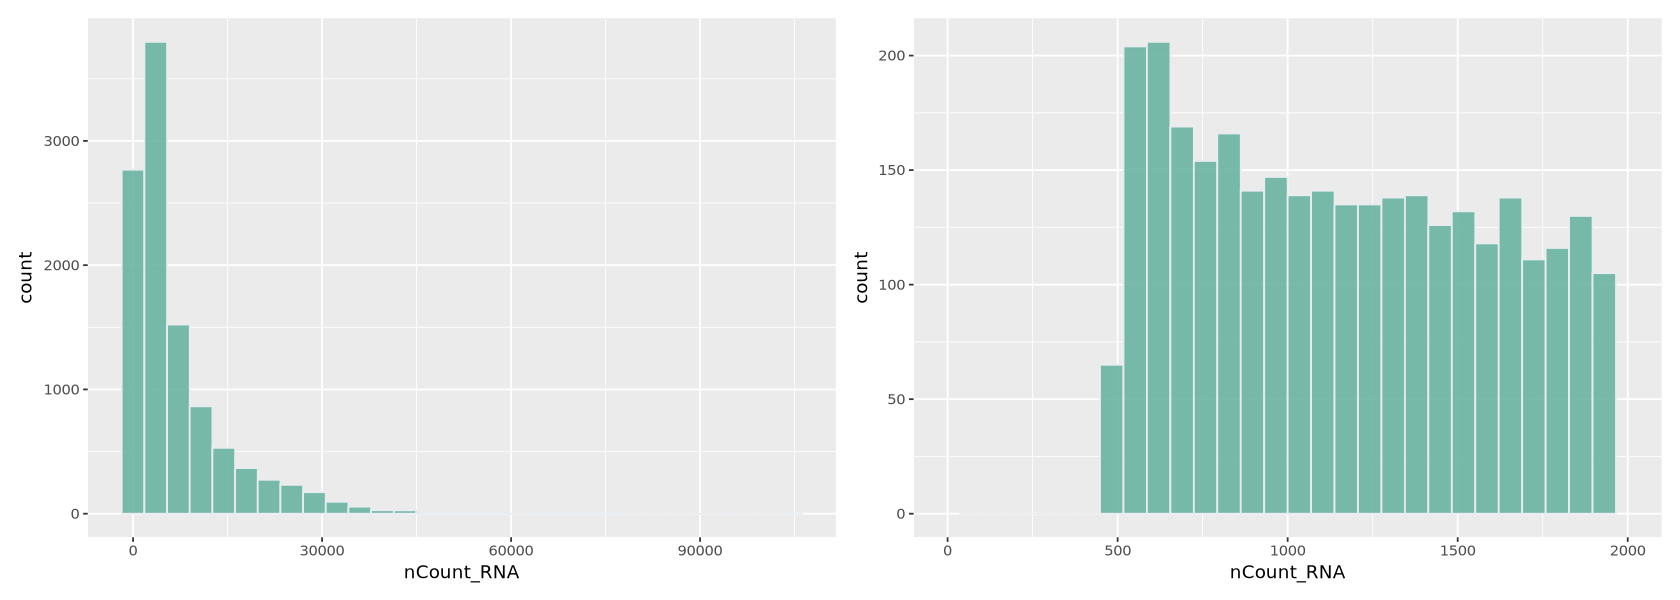

In [62]:
#| label: fig-rnacount
#| fig-cap: "Histogram of transcripts per cell (left) and a zoom onto the histogram (right)"

options(repr.plot.width=14, repr.plot.height=5)

plot1 <- ggplot(Control1_seurat@meta.data, aes(x=nCount_RNA)) + 
     geom_histogram(fill="#69b3a2", color="#e9ecef", alpha=0.9)

plot2 <- ggplot(Control1_seurat@meta.data, aes(x=nCount_RNA)) + 
     geom_histogram(fill="#69b3a2", color="#e9ecef", alpha=0.9) +
     xlim(0,2000)

plot1 + plot2

#### Number of detected genes per cell
Here we work similarly to filter out cells based on how many genes are detected (@fig-genecounts). The right-side plot is a zoom into the histogram. It seems easy to set the thresholds at ~400 and ~7000 detected genes.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 7793 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


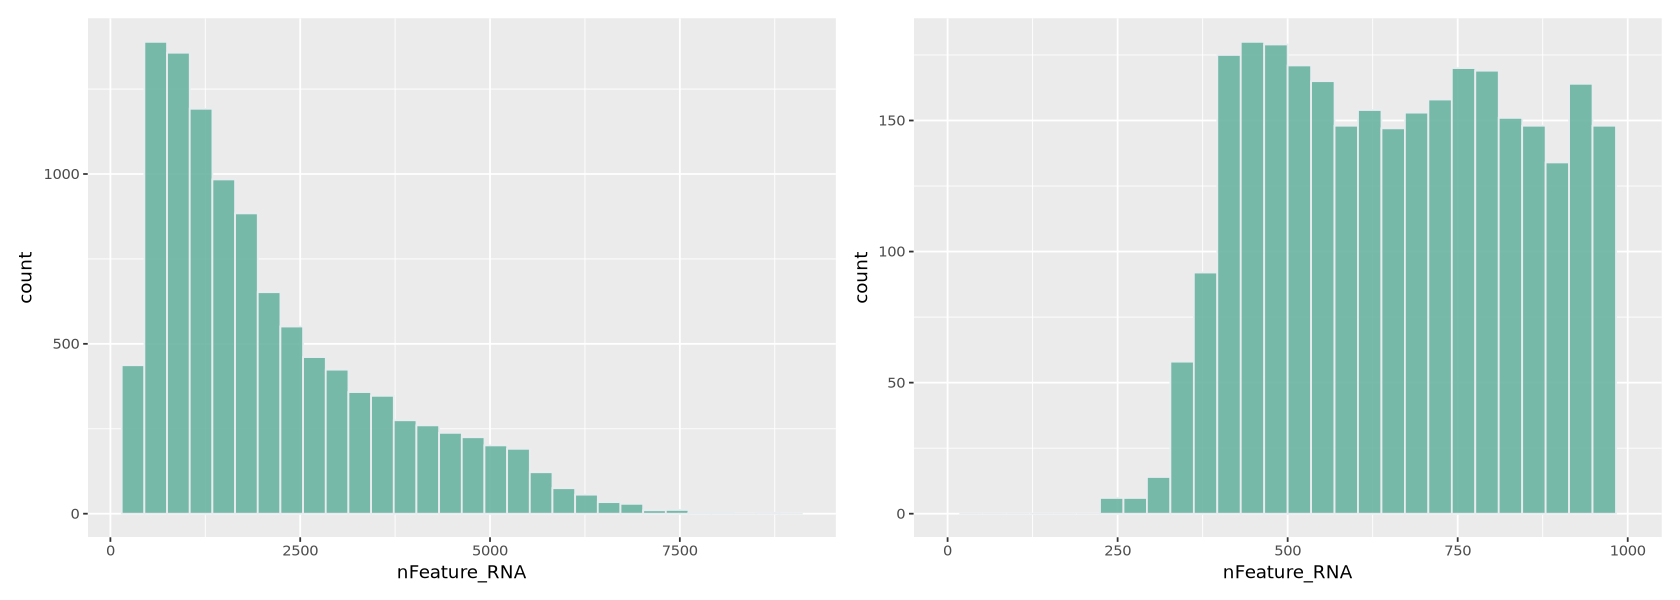

In [63]:
#| label: fig-genecounts
#| fig-cap: "Histogram of detected counts per cell (left) and a zoom onto the histogram (right)"


options(repr.plot.width=14, repr.plot.height=5)

plot1 <- ggplot(Control1_seurat@meta.data, aes(x=nFeature_RNA)) + 
     geom_histogram(fill="#69b3a2", color="#e9ecef", alpha=0.9)

plot2 <- ggplot(Control1_seurat@meta.data, aes(x=nFeature_RNA)) + 
     geom_histogram(fill="#69b3a2", color="#e9ecef", alpha=0.9) +
     xlim(0,1000)


plot1 + plot2

#### Mitochondrial and Chloroplast percentages

The percentages of mitochondrial and chloroplastic transcripts tells us the data is of good quality, since most cells have low values of those (@fig-mt). Thresholds are usually set between 5% and 20% in single cell data analysis. In the paper, thresholds were for example set at 20%.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


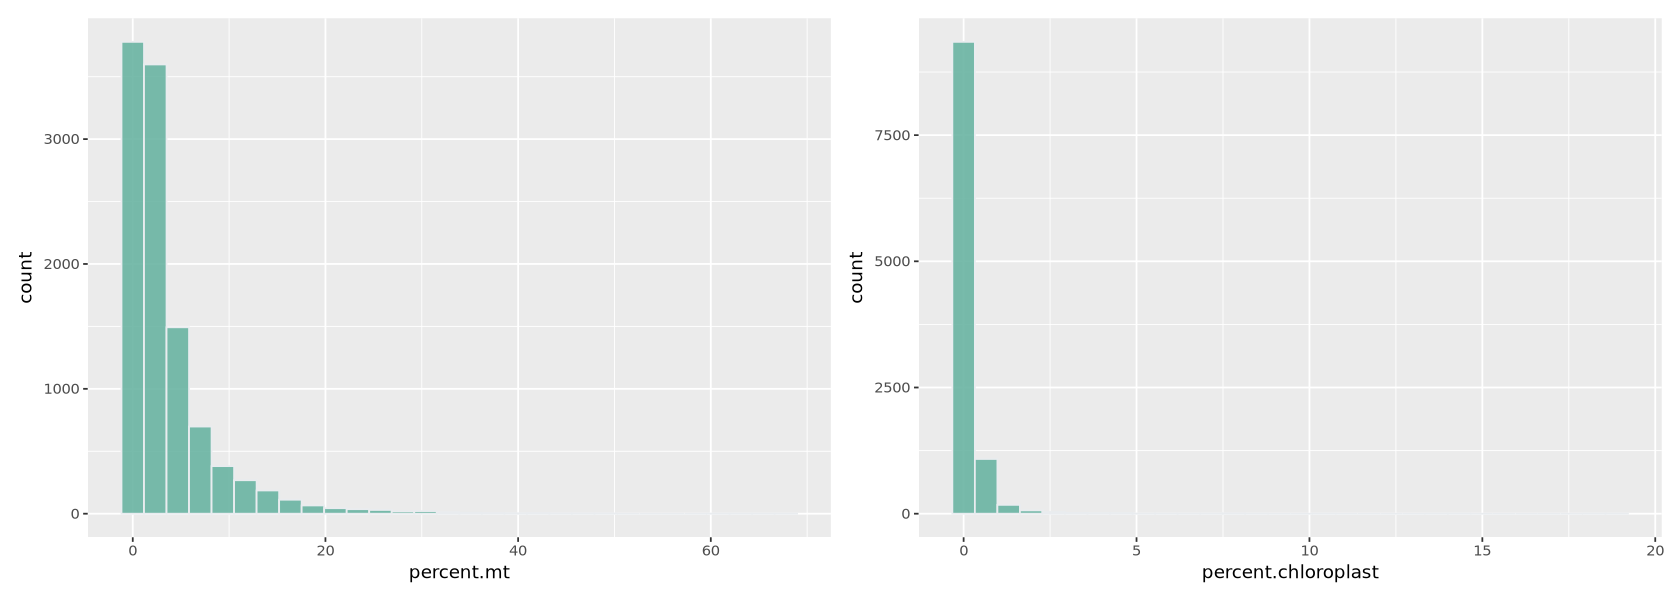

In [64]:
#| label: fig-mt
#| fig-cap: "Histogram of mitochondrial (left) and chloroplastic (right) percentage of transcripts in each cell"

options(repr.plot.width=14, repr.plot.height=5)

plot1 <- ggplot(Control1_seurat@meta.data, aes(x=percent.mt)) + 
     geom_histogram(fill="#69b3a2", color="#e9ecef", alpha=0.9)

plot2 <- ggplot(Control1_seurat@meta.data, aes(x=percent.chloroplast)) + 
     geom_histogram(fill="#69b3a2", color="#e9ecef", alpha=0.9)

plot1 + plot2

#### Counts-Features relationship

In @fig-gentra below, we look at the plot of the number of transcripts per cell vs the number of detected genes per cell. Usually, those two measure grow simultaneously. At lower counts the relationship is quite linear, then becomes a curve, typically bending in favour of the number of transcripts per cell. You can see below that each dot (representing a droplet) is coloured by percentage of mitochondria. Droplets with a high percentage of mitochondrial genes also have very low amount of transcripts and detected genes, **confirming that high mitochondrial content is a measure of low quality**.

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“The following aesthetics were dropped during statistical transformation: colour
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


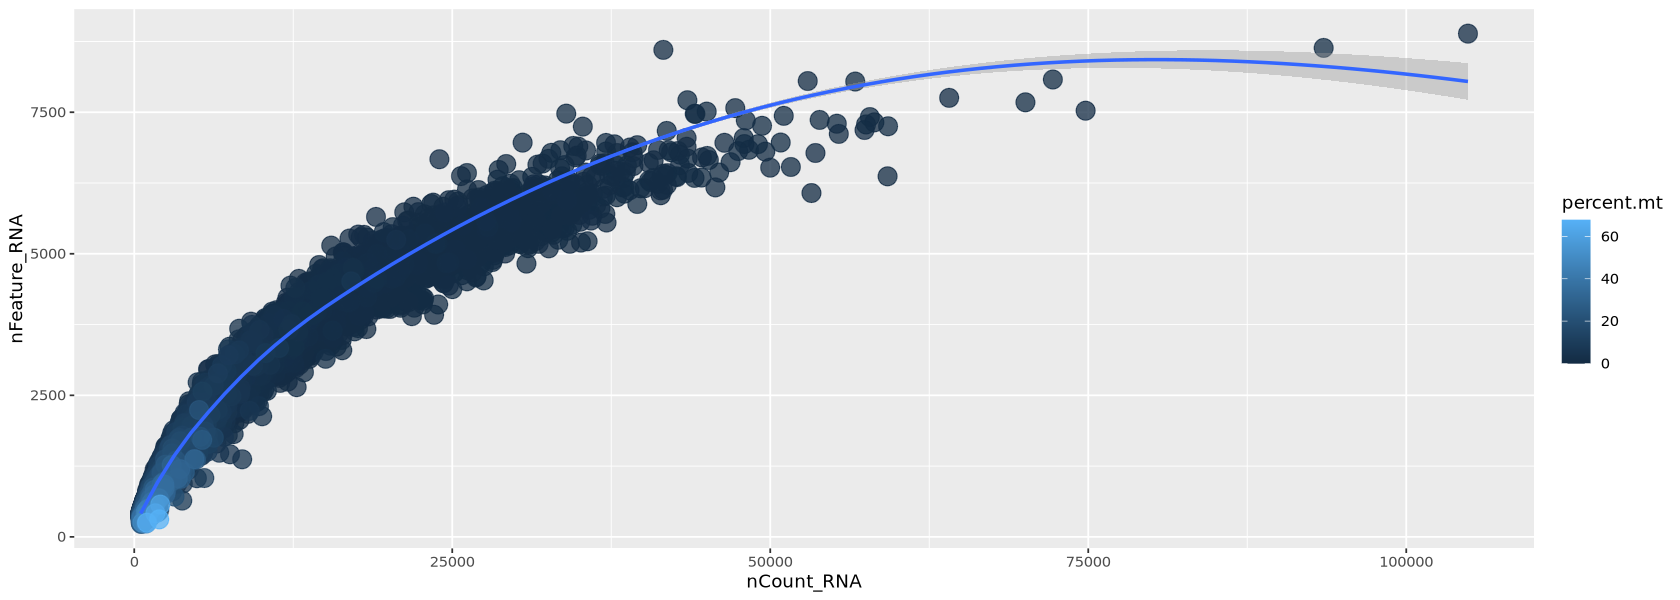

In [65]:
#| label: fig-gentra
#| fig-cap: "Histogram of the relationship between detected genes and transcripts per cell, coloured by mitochondrial content."


options(repr.plot.width=14, repr.plot.height=5)

meta <- Control1_seurat@meta.data %>% arrange(percent.mt)

plot1 <- ggplot( meta, aes(x=nCount_RNA, y=nFeature_RNA, colour=percent.mt)) + 
         geom_point(alpha=0.75, size=5)+
         geom_smooth(se=TRUE, method="loess")

plot1

In a similar way the chloroplastic genes confirm the pattern of low quality droplets.

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“The following aesthetics were dropped during statistical transformation: colour
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


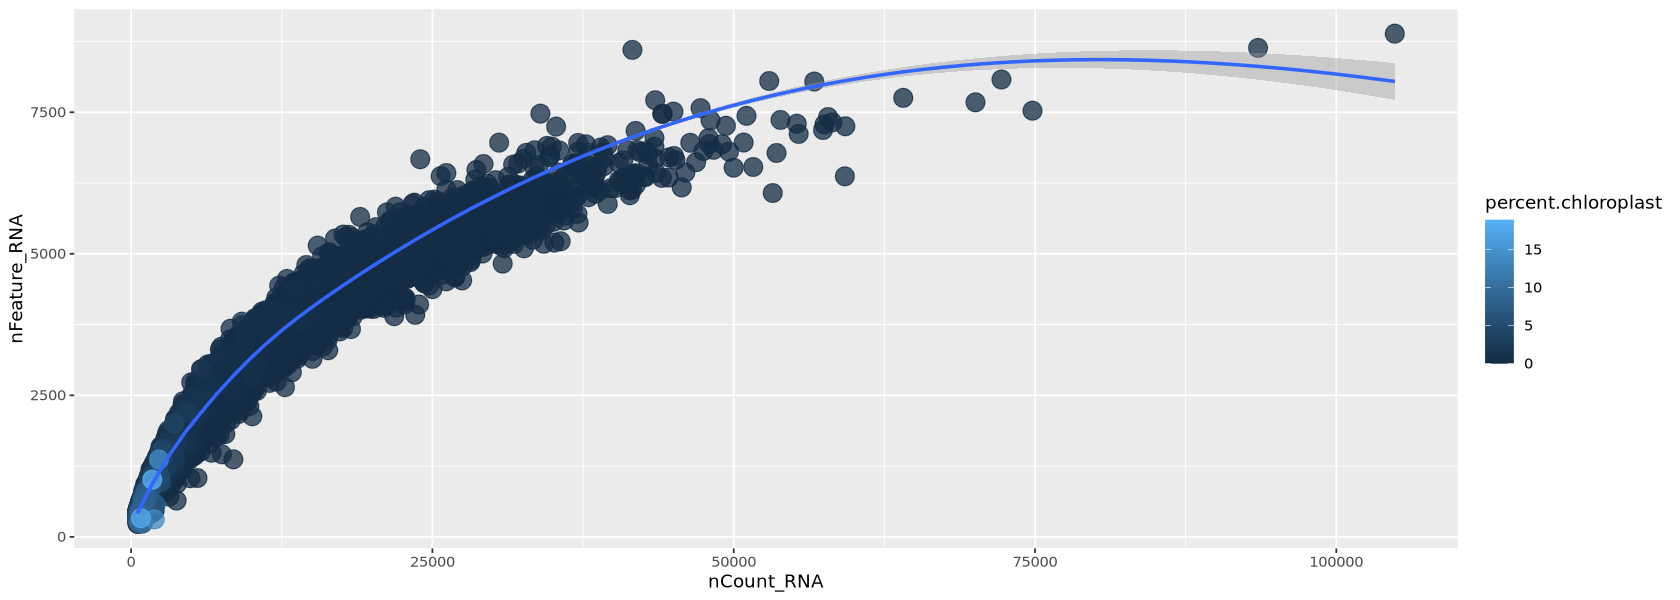

In [66]:
#| label: fig-gentrach
#| fig-cap: "Histogram of the relationship between detected genes and transcripts per cell, coloured by chloroplastic content."

options(repr.plot.width=14, repr.plot.height=5)

meta <- Control1_seurat@meta.data %>% arrange(percent.chloroplast)

plot1 <- ggplot( meta, aes(x=nCount_RNA, y=nFeature_RNA, colour=percent.chloroplast)) + 
         geom_point(alpha=0.75, size=5)+
         geom_smooth(se=TRUE, method="loess")

plot1

### Filtering with the chosen criteria

Here we use the command `subset` and impose the criteria we chose above looking at the histograms. We set each criteria for keeping cells of good quality using the names of the features in metadata. We print those names to remember them.

In [67]:
cat("Meta data names:\n")
cat( names(Control1_seurat@meta.data), sep='; ' )

Meta data names:
orig.ident; nCount_RNA; nFeature_RNA; Condition; percent.mt; percent.chloroplast

The filtered object is called `Control1_seurat_filt`

In [68]:
Control1_seurat_filt <- subset(x = Control1_seurat, 
                                        subset = nCount_RNA > 700 &
                                                 nCount_RNA < 35000 &
                                                 nFeature_RNA > 400 & 
                                                 nFeature_RNA < 7000 & 
                                                 percent.mt < 5 & 
                                                 percent.chloroplast < 5)

cat("Filtered Genes and Cells: ")
cat( dim(Control1_seurat) - dim(Control1_seurat_filt) )
cat("\nRemaining Genes and Cells: ")
cat( dim(Control1_seurat_filt) )

Filtered Genes and Cells: 0 2762
Remaining Genes and Cells: 23838 8010

Now the transcripts vs genes can be seen in @fig-filtrelationship. The relationship is much more linear than previously after the removal of extreme values for transcripts and detected genes.

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“The following aesthetics were dropped during statistical transformation: colour
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


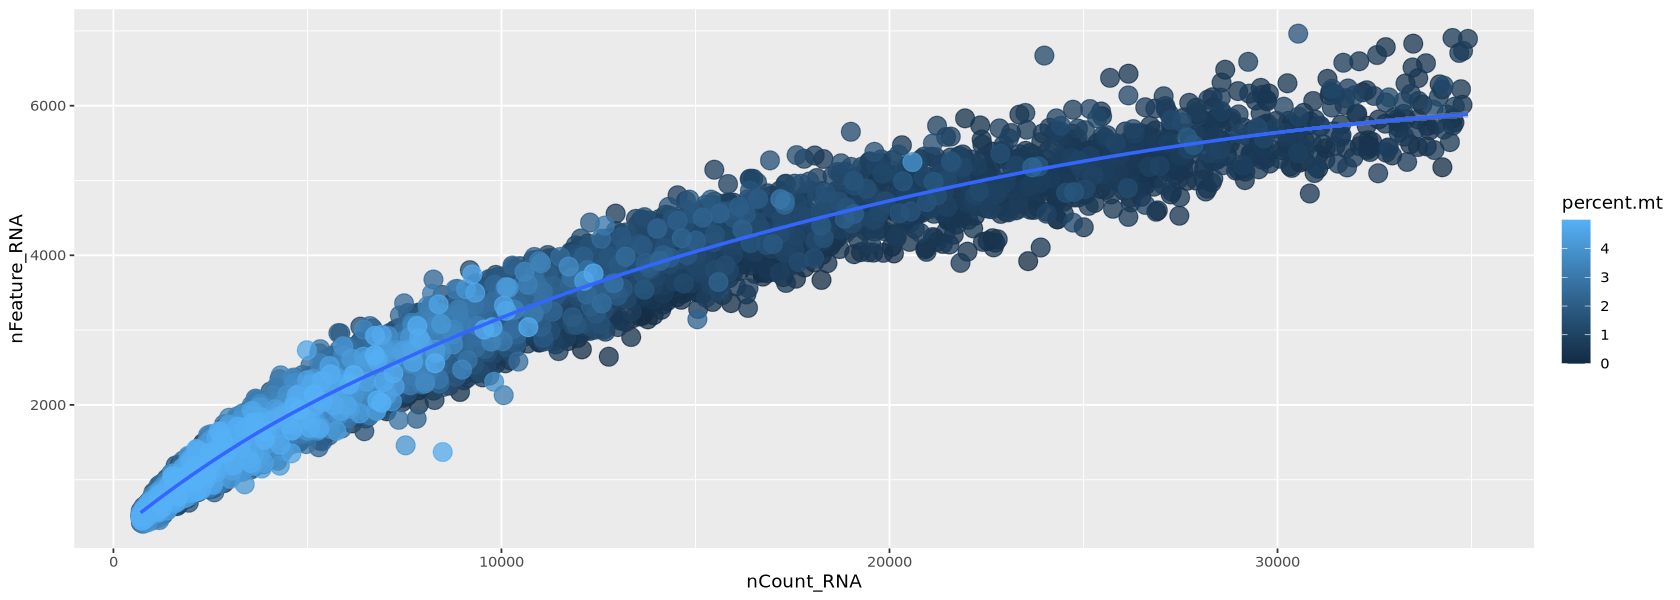

In [69]:
#| label: fig-filtrelationship
#| fig-cap: "Count vs features after filtering with the chosen criteria"


options(repr.plot.width=14, repr.plot.height=5)

meta <- Control1_seurat_filt@meta.data %>% arrange(percent.mt)

plot1 <- ggplot( meta, aes(x=nCount_RNA, y=nFeature_RNA, colour=percent.mt)) + 
         geom_point(alpha=0.75, size=5)+
         geom_smooth(se=TRUE, method="loess")

plot1

## Normalization

scRNA-seq data is **affected by highly variable RNA quantities and qualities** across different cells. Furthermore, it is often subject to **batch effects, sequencing depth differences, and other technical biases** that can confound downstream analyses.

Normalization methods are used to **adjust for these technical variations so that true biological differences between cells can be accurately identified**.

Some commonly used normalization methods in scRNA-seq data include the following:

* **Total count normalization**: Normalizing the read counts to the total number of transcripts in each sample
* **TPM (transcripts per million)** normalization: Normalizing the read counts to the total number of transcripts in each sample, scaled to a million
* **Library size normalization:** Normalizing the read counts to the total number of reads or transcripts in each sample, adjusted for sequencing depth

All the above suffer from distorting some gene expressions, especially if the data varies a lot in term of sequencing depth. A new and more advanced method, at the moment the state-of-the-art, is `SCTransform` (@hafemeister_normalization_2019), a software package that can **correct for technical sources of variation and remove batch effects**.

### Finding technical sources of variation

Before normalizing we want to check for technical sources of variation in the data. One of those is the total number of transcripts: two similar cells might be sequenced at different depth. This influences of course normalization. The influence of the number of transcripts per cell is however always removed by `SCtransform`. 

We want to look into other possible sources of variation. Those are usually quantities we calculate for each cell, for example the percentage of mitochondrial and chloroplastic genes. 

To see if those quantities actually influence our data a lot, we check how much is their highest correlation with the first 10 components of the PCA of the dataset. In short, **we see if any technical variation is such that it explains much of the variability of the data, covering possibly biological signal**.

We now use the function `plotCorrelations` to plot the highest correlation of three quantities with the PCA: number of transcripts, percent of mitochondrial genes and percent of chloroplastic genes. You will see in @fig-corr how **there is little correlation for the two percentages**, for which we do not need to worry about, while **there is correlation with the total number of transcripts per cell** (this is always expected and, as mentioned before, is removed automatically by the normalization process). We created the function `plotCorrelations` specifically for the course, together with a few others, mostly for plotting or handling tables. You can find them in the file `script.R`.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


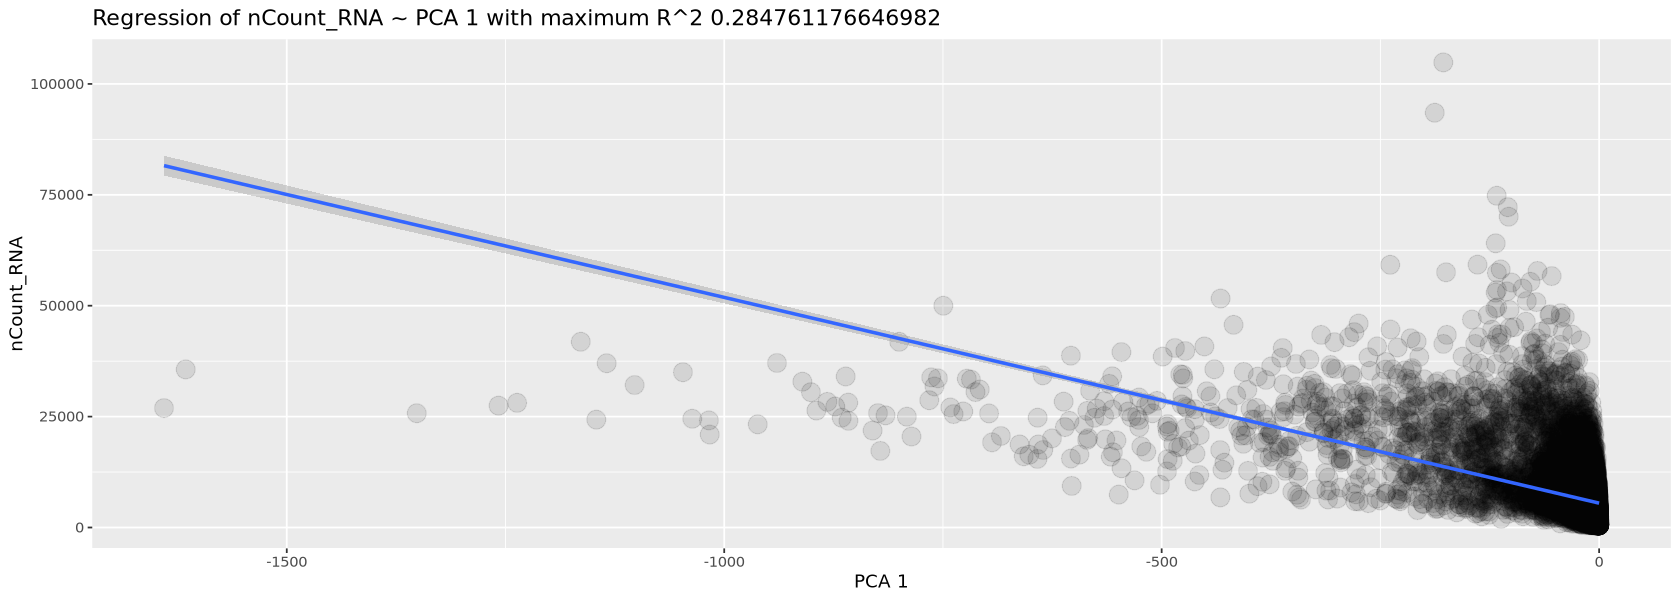

`geom_smooth()` using formula = 'y ~ x'


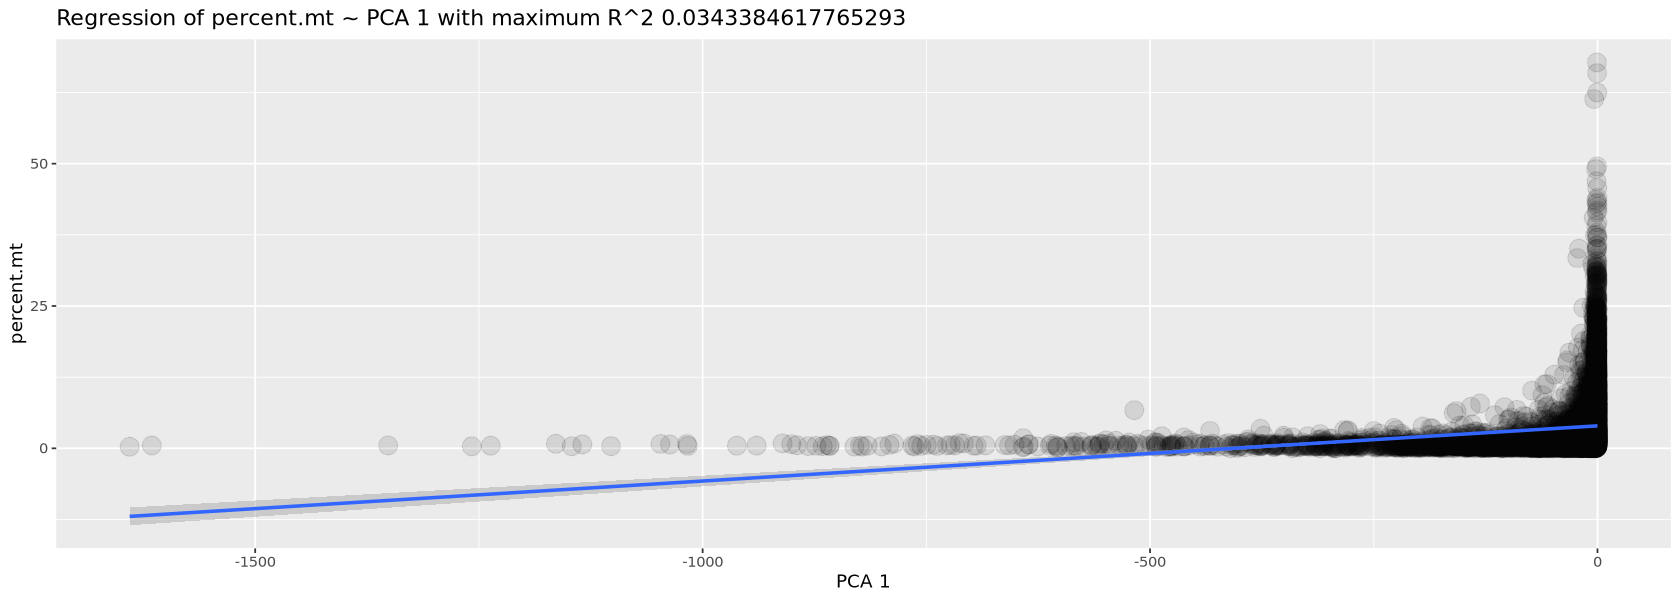

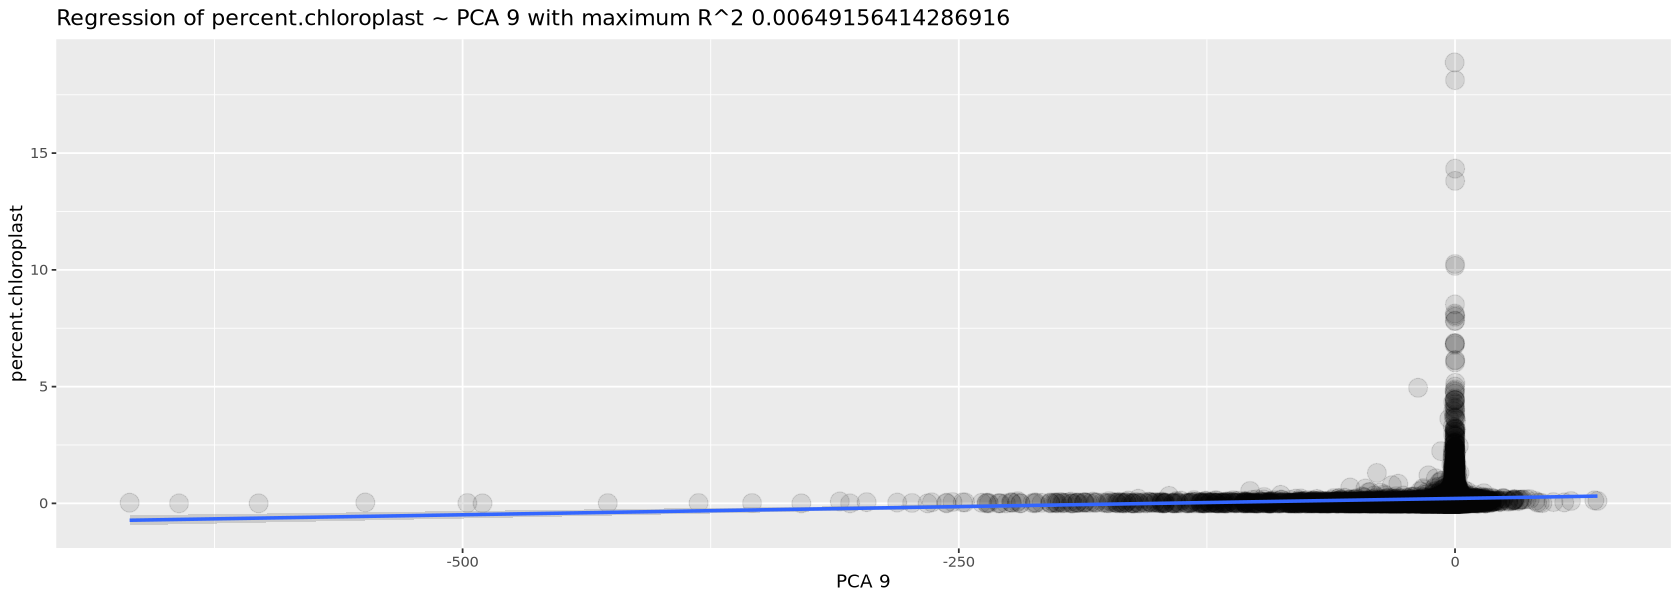

In [70]:
#| label: fig-corr
#| fig-cap: "Relationships of maximal correlation between cell quantities and principal components"

plotCorrelations( object=Control1_seurat, measures=c('nCount_RNA', 'percent.mt', 'percent.chloroplast') )

### Executing normalization

We run `SCtransform` normalization below. Here you can choose to subsample some cells to do the normalization (`ncells` option): this is **useful to avoid ending up waiting for a long time**. A few thousands cells is enough. 

You can also choose how many genes to consider for normalization (`variable.features.n` option): in this case it is best to **use the genes that vary the most their expression across cells**. We look at a histogram (@fig-hvg) of the variance of each gene to choose a threshold to identify highly-variable genes.

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.4 GiB”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 3289 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


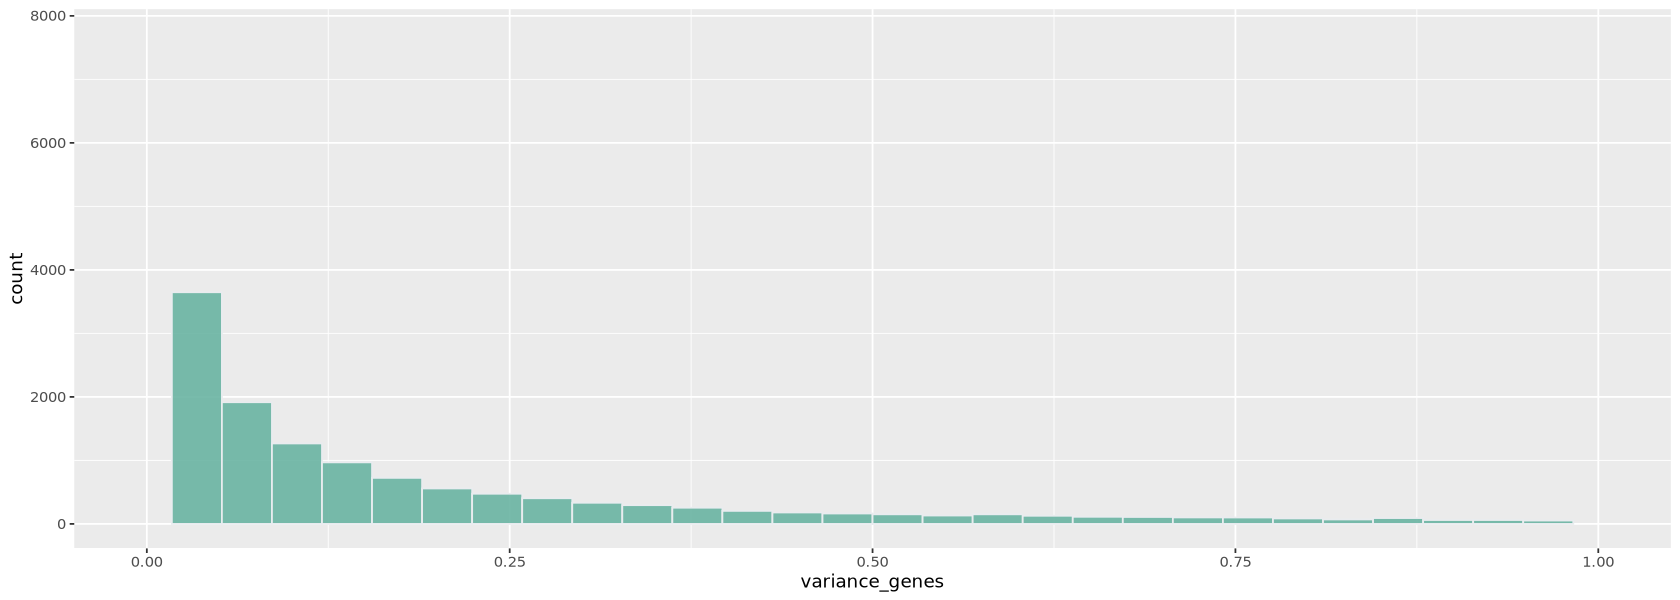

In [71]:
#| label: fig-hvg
#| fig-cap: "Histogram of genes variance. We choose the threshold 0.1 to identify highly variable genes."

variance_genes <- apply( as.matrix(Control1_seurat_filt[['RNA']]@counts), 1, var)

options(repr.plot.width=14, repr.plot.height=5)

plot1 <- ggplot(data.frame(variance_genes), aes(variance_genes)) + 
     geom_histogram(fill="#69b3a2", color="#e9ecef", alpha=0.9) + xlim(0,1)

plot1

In [72]:
hvighly_var_genes <- variance_genes > .25
cat("The total number of highly variable genes selected is: ")
cat(sum( hvighly_var_genes ))

The total number of highly variable genes selected is: 6652

In [73]:
Control1_seurat_norm <- SCTransform(Control1_seurat_filt, 
                                             return.only.var.genes = FALSE, 
                                             ncells = 3000, 
                                             variable.features.n = sum( hvighly_var_genes ),
                                             verbose = FALSE)

Normalized data is now in the object `Control1_seurat_norm`, in a new assay called `SCT`. This assay is now the default used for data analysis: you can verify it very easily below:

In [74]:
cat("Your default assay is: ")
cat(DefaultAssay(object = Control1_seurat_norm))

Your default assay is: SCT

### Visualizing the result

Now we plot the UMAP plot of the data to have a first impression of how the data is structured (presence of clusters, how many, etc.). First of all, we create a PCA plot, which tells us how many PCA components are of relevance with the elbow plot of @fig-elbow. In the elbow plot, we see the variability of each component in descending order. Note how, after a few rapidly descending components, there is an elbow. We schoose a threshold just after the elbow (for example at 15), which means those components will be used to calculate some other things of relevance in the data, such as distance between cells and the UMAP projection of @fig-umap: specific commands using PCA allow to choose the components, and we will set 10 with the option `dims = 1:15`.

In [75]:
Control1_seurat_norm <- FindVariableFeatures(Control1_seurat_norm,
                                                     nfeatures = sum( hvighly_var_genes ))

In [76]:
Control1_seurat_norm <- RunPCA(object = Control1_seurat_norm, 
                                        verbose = FALSE, seed.use = 123)

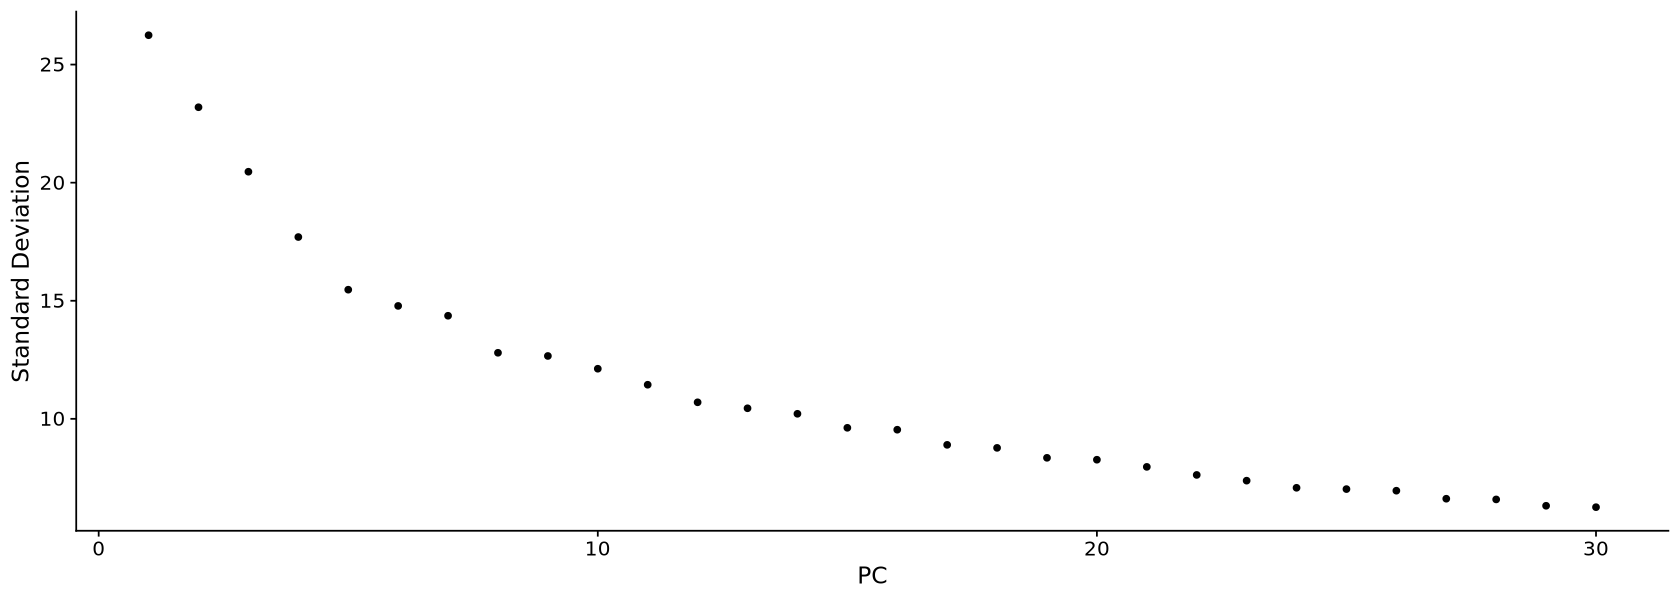

In [77]:
#| label: fig-elbow
#| fig-cap: "Elbow plot of the first 30 principal components calculated from the data"

ElbowPlot(Control1_seurat_norm, ndims = 30)

We calculate the projection using the UMAP algorithm (@mcinnes_umap_2018, @becht_dimensionality_2019). The parameters `a` and `b` will change how stretched and scattered the data looks like. When you do your own UMAP projection, you can avoid setting `a` and `b`, and those will be chosen automatically by the command.

In [78]:
Control1_seurat_norm <- RunUMAP(object = Control1_seurat_norm, 
                                         a = .8, b=1,
                                         dims = 1:15, 
                                         verbose = FALSE, 
                                         seed.use = 123)

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’



In @fig-umap we can see the resulting projection. The result looks pretty neat and structured (we can clearly see there are various clusters).

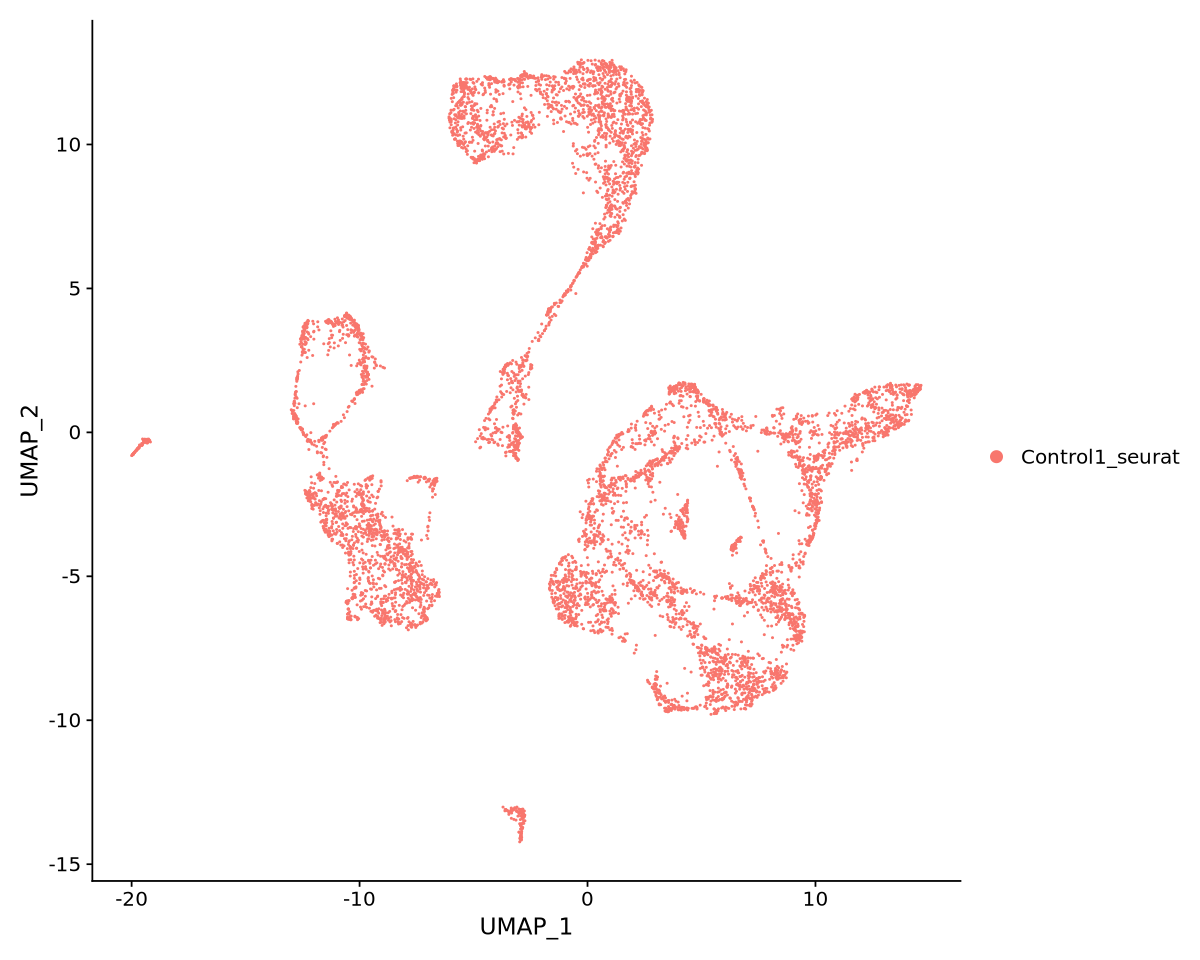

In [79]:
#| label: fig-umap
#| fig-cap: "UMAP projection of the data"

options(repr.plot.width=10, repr.plot.height=8)
UMAPPlot(object = Control1_seurat_norm)

## Removing doublets

Doublets removal is part of filtering, but it needs normalized data to work. This is why we do it after using `SCtransform`.

Doublets (and the very rare multiplets) refer to droplets that **contain the transcriptional profiles of two or more distinct cells**. Doublets can occur during the cell dissociation process or when two or more cells are captured in the same droplet during the library preparation step.

It is quite obvious that a doublet transcriptional profile can confound downstream analyses, such as cell clustering and differential gene expression analysis. Most doublet detectors, like `DoubletFinder` (@mcginnis_doubletfinder_2019) which we will use, **simulates doublets and then finds cells in the data which are similar to the simulated doublets**. Most such packages need an idea of the number/proportion of expected doublets in the dataset. **As indicated from the Chromium user guide, expected doublet rates are about as follows:**

![Table of expected doublet rates based on the number of cells.](./images/doublet_rates.png){width=600, #fig-doubletrates}

The data we are using contained about 10000 cells per sample (as in the knee plot at the beginning), hence we can assume that it originates from around 18000 loaded cells and should have a doublet rate at about 7.6%.

::: {.callout-warning}
Doublet prediction, like the rest of the filtering, **should be run on each sample separately**.
:::

Here, we apply `DoubletFinder` to predict doublet cells. Most parameters are quite standard, we mostly need to choose `nExp` (expected number of doublets), `PCs` (number of principal components to use), `sct` (use the normalized data). The last three option are not part of the package, but have been added by creating a slightly modified version ([here](https://github.com/SamueleSoraggi/DoubletFinder)) - they allow to use multiple cores and a subset of cells for calculations for a considerable speedup. However, the code takes some time to run, so be patient. There will be a lot of printout as well, but don't worry.

In [80]:
nExp <- round(ncol(Control1_seurat_norm) * 0.076)  # expected doublet rate

In [81]:
Control1_seurat_norm <- doubletFinder_v3(Control1_seurat_norm,
                                                  pN = 0.25, #proportion of doublets to simulate)
                                                  pK = 0.09, 
                                                  nExp = nExp, 
                                                  PCs = 1:15, 
                                                  sct=TRUE, 
                                                  workers=8, 
                                                  future.globals.maxSize = 8*1024^13,
                                                  seurat.ncells=3000)

Loading required package: fields

Loading required package: spam

Spam version 2.8-0 (2022-01-05) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following object is masked from ‘package:stats4’:

    mle


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: viridisLite


Try help(fields) to get started.

Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009



[1] "Creating 2670 artificial doublets..."


Loading required package: sctransform



[1] "Creating Seurat object..."
[1] "Running SCTransform..."


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 23388 by 10680

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 3000 cells



  |======================================================================| 100%


Found 151 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 23388 genes



  |======================================================================| 100%


Computing corrected count matrix for 23388 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 1.02049 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



[1] "Running PCA..."


PC_ 1 
Positive:  LotjaGi2g1v0360900, LotjaGi5g1v0359500, LotjaGi6g1v0155900, LotjaGi6g1v0155800, LotjaGi3g1v0321700, LotjaGi3g1v0414900, LotjaGi3g1v0030500, LotjaGi5g1v0211100, LotjaGi3g1v0506700, LotjaGi4g1v0109600 
	   LotjaGi3g1v0009600, LotjaGi1g1v0539300, LotjaGi3g1v0450900, LotjaGi2g1v0269100, LotjaGi3g1v0010900, LotjaGi3g1v0530000, LotjaGi3g1v0373700, LotjaGi4g1v0137700, LotjaGi3g1v0380900, LotjaGi4g1v0309700 
	   LotjaGi1g1v0014300, LotjaGi5g1v0359400, LotjaGi6g1v0071000, LotjaGi3g1v0012400, LotjaGi3g1v0162300, LotjaGi3g1v0554100, LotjaGi1g1v0516900, LotjaGi2g1v0316800, LotjaGi2g1v0285600, LotjaGi2g1v0358600 
Negative:  LotjaGi6g1v0254300, LotjaGi3g1v0068000, LotjaGi6g1v0286800-LC, LotjaGi1g1v0080000, LotjaGi5g1v0005800, LotjaGi5g1v0269800-LC, LotjaGi5g1v0293100-LC, LotjaGi3g1v0222100, LotjaGi1g1v0006200, LotjaGi6g1v0254700 
	   LotjaGi3g1v0358300, LotjaGi3g1v0329100, LotjaGi3g1v0445300, LotjaGi1g1v0646500-LC, LotjaGi2g1v0157900, LotjaGi3g1v0505900, LotjaGi1g1v0022100, LotjaGi

[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


We visualize the UMAP plot and which cells are estimated doublets in @fig-doublets. Fortunately, there are only a few potential doublets.

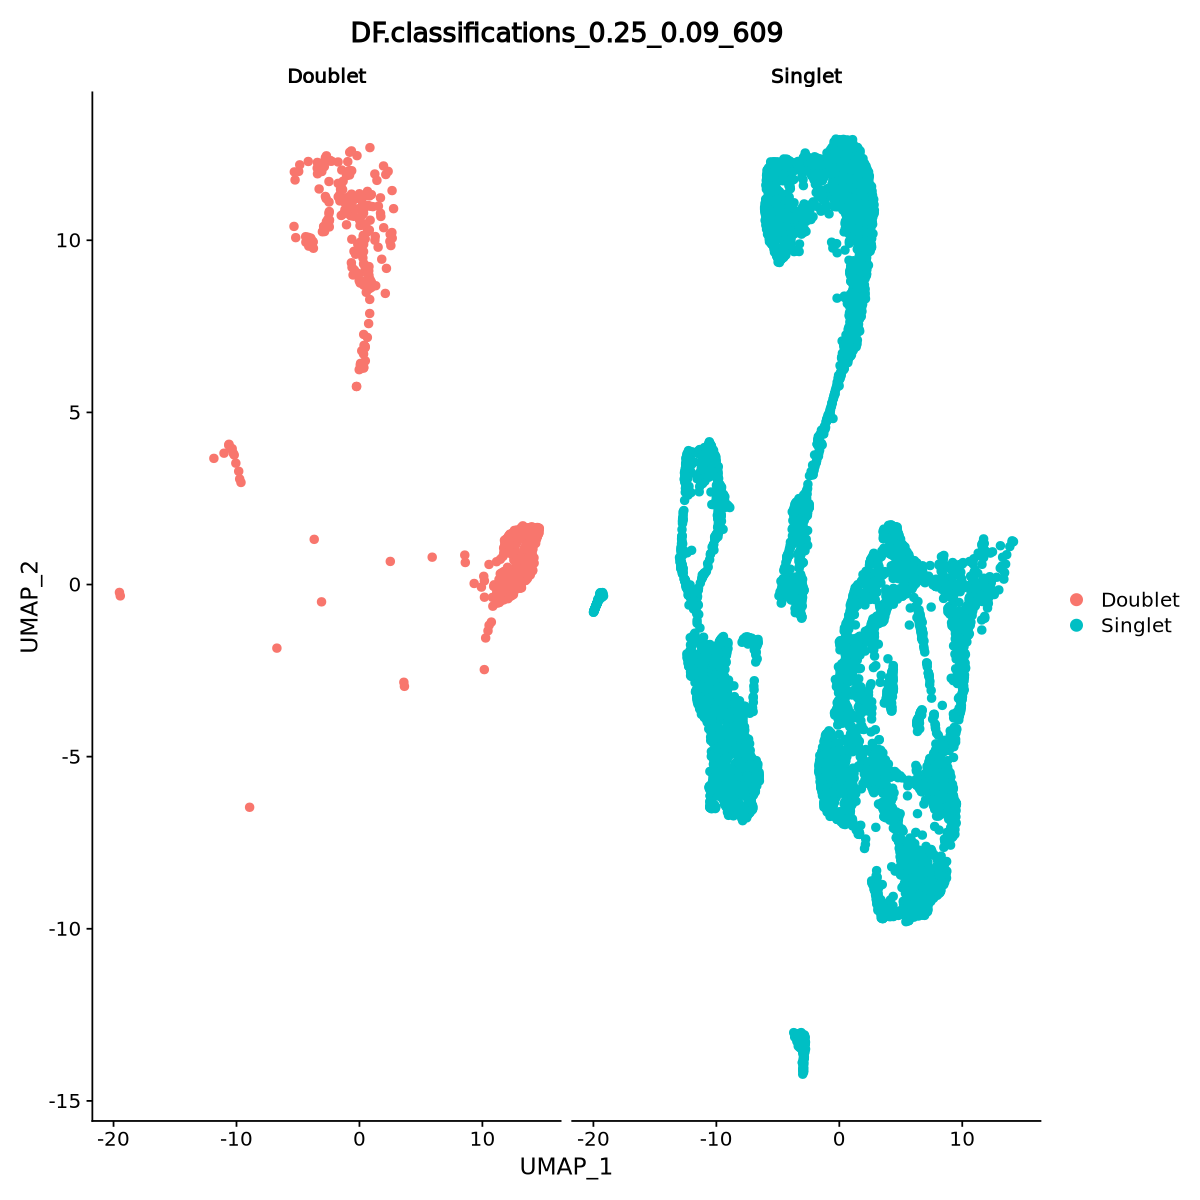

In [82]:
#| label: fig-doublets
#| fig-cap: "UMAP projection of the data coloured by doublet or singlet label"

options(repr.plot.width=10, repr.plot.height=10)

DF.name = colnames(Control1_seurat_norm@meta.data)[grepl("DF.classification", colnames(Control1_seurat_norm@meta.data))]

DimPlot(Control1_seurat_norm, group.by = DF.name, pt.size = 2, 
        split.by = DF.name)

Sometimes doublets have more detected genes than a single cell. In our case, some of the droplets have higher number of genes than the average (the red violin is large also above 3000 detected genes), so there is aclear sign of the presence of some doublets. Of course, as with any filtering, we might remove some actual cells. To be more effective in our filtering, we can select doublets with more than 2000 detected genes when we filter.

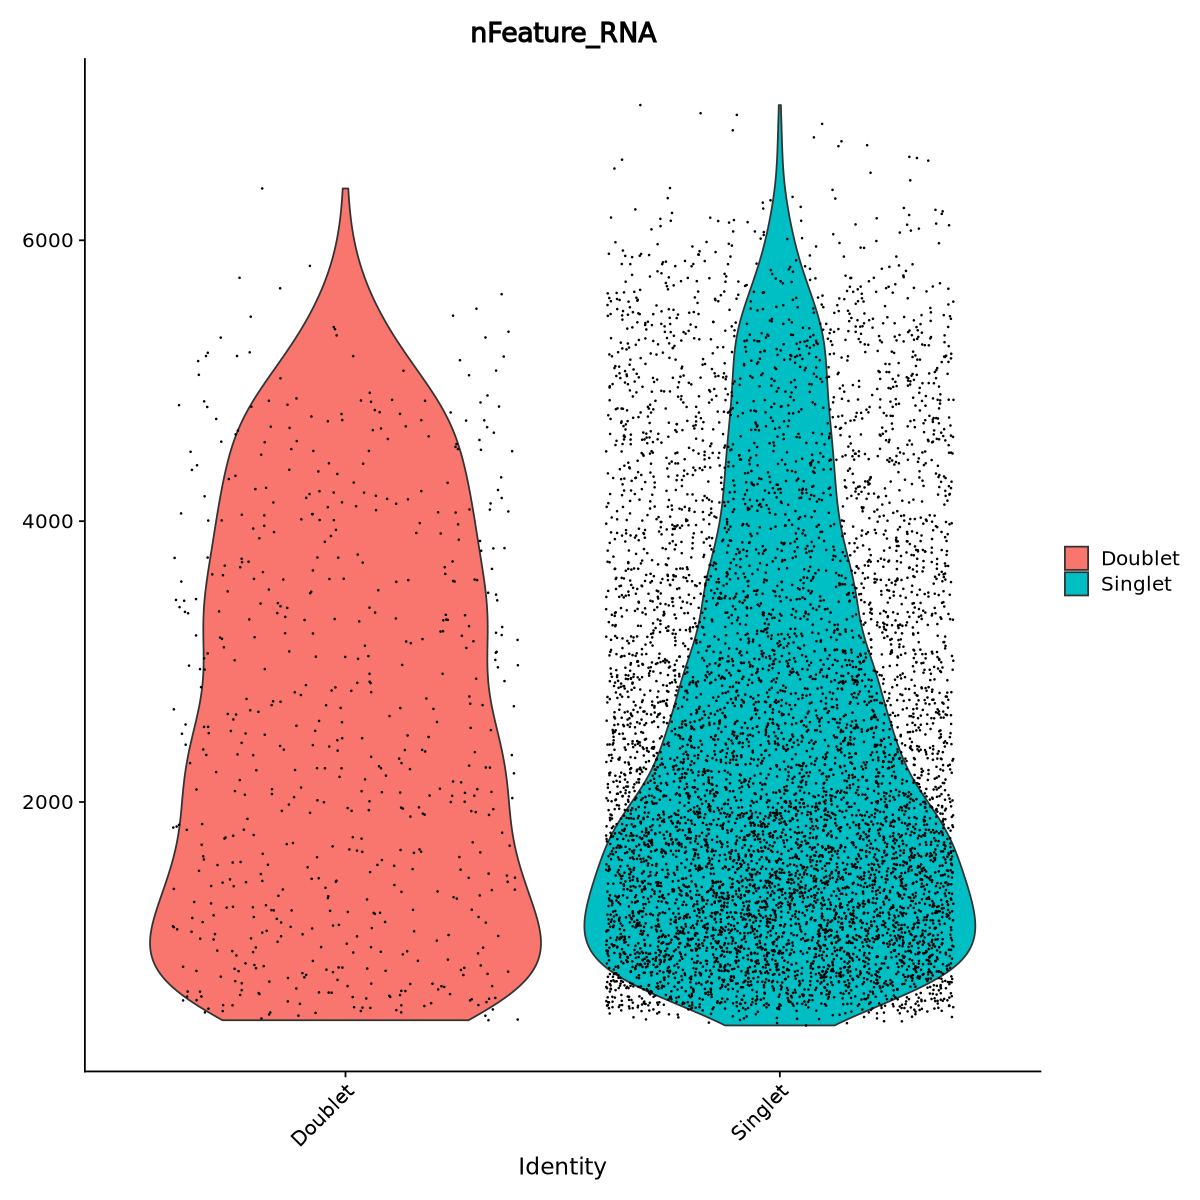

In [83]:
VlnPlot(Control1_seurat_norm, features = "nFeature_RNA", group.by = DF.name, pt.size = 0.1)

Here we keep only singlets:

In [84]:
Control1_seurat_norm = Control1_seurat_norm[, (Control1_seurat_norm@meta.data[, DF.name] == "Singlet")&(Control1_seurat_norm@meta.data$nFeature_RNA>2000)]

We save our data after all the filtering work!

In [85]:
SaveH5Seurat(object = Control1_seurat_norm, 
             filename = "control1.normalized.h5Seurat", 
             overwrite = TRUE,
             verbose = FALSE)

Warning message:
“Overwriting previous file control1.normalized.h5Seurat”
Creating h5Seurat file for version 3.1.5.9900



# Integration {#sec-integration}

Integration of scRNA-seq data is useful to combine datasets from different experimental conditions (in our case the Control vs Infected) and sequencing runs, to gain a broader understanding of cellular processes. Integration is challenging due to technical variations and biological differences between the datasets (where we want to remove the formers to study correctly the latters).

Before integrating scRNA-seq datasets, we have applyed **quality control and normalization to each sample** to ensure consistency and accuracy of the data. Integration can happen using various methods (@adossa_computational_2021). Seurat uses **canonical correlation analysis (CCA)** (@stuart_comprehensive_2019, @xinming_seurat_2022) to integrate scRNA-seq datasets from different experimental conditions. CCA identifies shared variation between two datasets while accounting for technical differences, such as batch effects.

The shared covariance patterns **can represent biological signals that are common across the datasets**, such as cell types or signaling pathways.

We load another control and two infected datasets. Those have been previously preprocessed, so you will not need to. Remember again: each dataset must be preprocessed separately before integration.

In [86]:
Control1_seurat_norm <- LoadH5Seurat("control1.normalized.h5Seurat", verbose = FALSE)

Validating h5Seurat file



In [87]:
Control2_seurat_norm <- LoadH5Seurat("../Data/control2.normalized.h5Seurat", verbose = FALSE)
Infected1_seurat_norm <- LoadH5Seurat("../Data/infected1.normalized.h5Seurat", verbose = FALSE)
Infected2_seurat_norm <- LoadH5Seurat("../Data/infected2.normalized.h5Seurat", verbose = FALSE)

Validating h5Seurat file

Validating h5Seurat file

Validating h5Seurat file



To integrate the datasets, we need to start creating a list with all datasets.

In [88]:
Gifu.list <- list(Control1_seurat_norm, 
                  Control2_seurat_norm, 
                  Infected1_seurat_norm, 
                  Infected2_seurat_norm)

We then start by normalizing each dataset of the list with `SCtransform`.

In [89]:
Gifu.list <- lapply(X = Gifu.list, FUN = function(x) {
  message("Normalizing\n")
  x <- SCTransform(x, ncells=3000, variable.features.n = 2000, return.only.var.genes = FALSE, verbose=FALSE)
})

Normalizing


Normalizing


Normalizing


Normalizing




:::{.callout-note}
Running `SCTransform` as above does not contain any variable to regress out. By definition, the normalization will remove the technical effect of the number of transcripts per cell only. This is important because the amount of transcripts greatly vary in each cell, and it might seem a sign of biological variation, rather than a sign of varying capture efficiency of the mRNA transcripts. If you want to remove other sources of technical variation, for example chloroplastic and mitochondrial transcripts percentage, then you can use this command

```
x <- SCTransform(x, vars.to.regress = c("percent.mt",  "percent.chloroplast"),
                 variable.features.n = 10000,
                 return.only.var.genes = FALSE,
                 verbose = TRUE)
```

You can also include differences due to biological variation which you want to remove, to highlight the effect of other biological processes. Find the [manual of SCTransform](https://satijalab.org/seurat/reference/sctransform) to understand all possible options of the command. [This other tutorial](https://hbctraining.github.io/scRNA-seq/lessons/06_SC_SCT_and_integration.html) has a good application of `SCTransform` which you can read.

:::

Now we apply the CCA (Canonical Correlation Analysis) to put datasets together according to their similarities, while removing differences. The number of genes to use during integration is expressed below as `nfeatures`. The default choice is 2000 as written below.

In [90]:
Gifu.features <- SelectIntegrationFeatures(object.list = Gifu.list, nfeatures = 2000)

Gifu.list <- PrepSCTIntegration(object.list = Gifu.list, anchor.features = Gifu.features)

In [91]:
Gifu.anchors <- FindIntegrationAnchors(object.list = Gifu.list, normalization.method = "SCT", 
                                       anchor.features = Gifu.features, reference = c(1,2))

seurat.integrated <- IntegrateData(anchorset = Gifu.anchors, normalization.method = "SCT")

Warning message in CheckDuplicateCellNames(object.list = object.list):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Finding anchors between all query and reference datasets

Warning message:
“Layer counts isn't present in the assay object; returning NULL”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”
Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 8720 anchors

Filtering anchors

	Retained 8558 anchors

Warning message:
“Layer counts isn't present in the assay object; returning NULL”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”
Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 8786 anchors

Filtering anchors

	Retained 8086 anchors

Warning message:
“Layer counts isn't present in the assay object; returning NULL”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”
Running CCA

M

Now the default assay used for analysis has changed into `integrated`:

In [92]:
cat("The default assay of the data is now called: ")
cat(DefaultAssay(seurat.integrated))

The default assay of the data is now called: integrated

We need to recalculate PCA and UMAP to look at all datasets integrated together. We choose again 10 principal components from @fig-elbowint. The newUMAP is in @fig-umapint.

In [93]:
seurat.integrated <- RunPCA(object = seurat.integrated, verbose = FALSE)

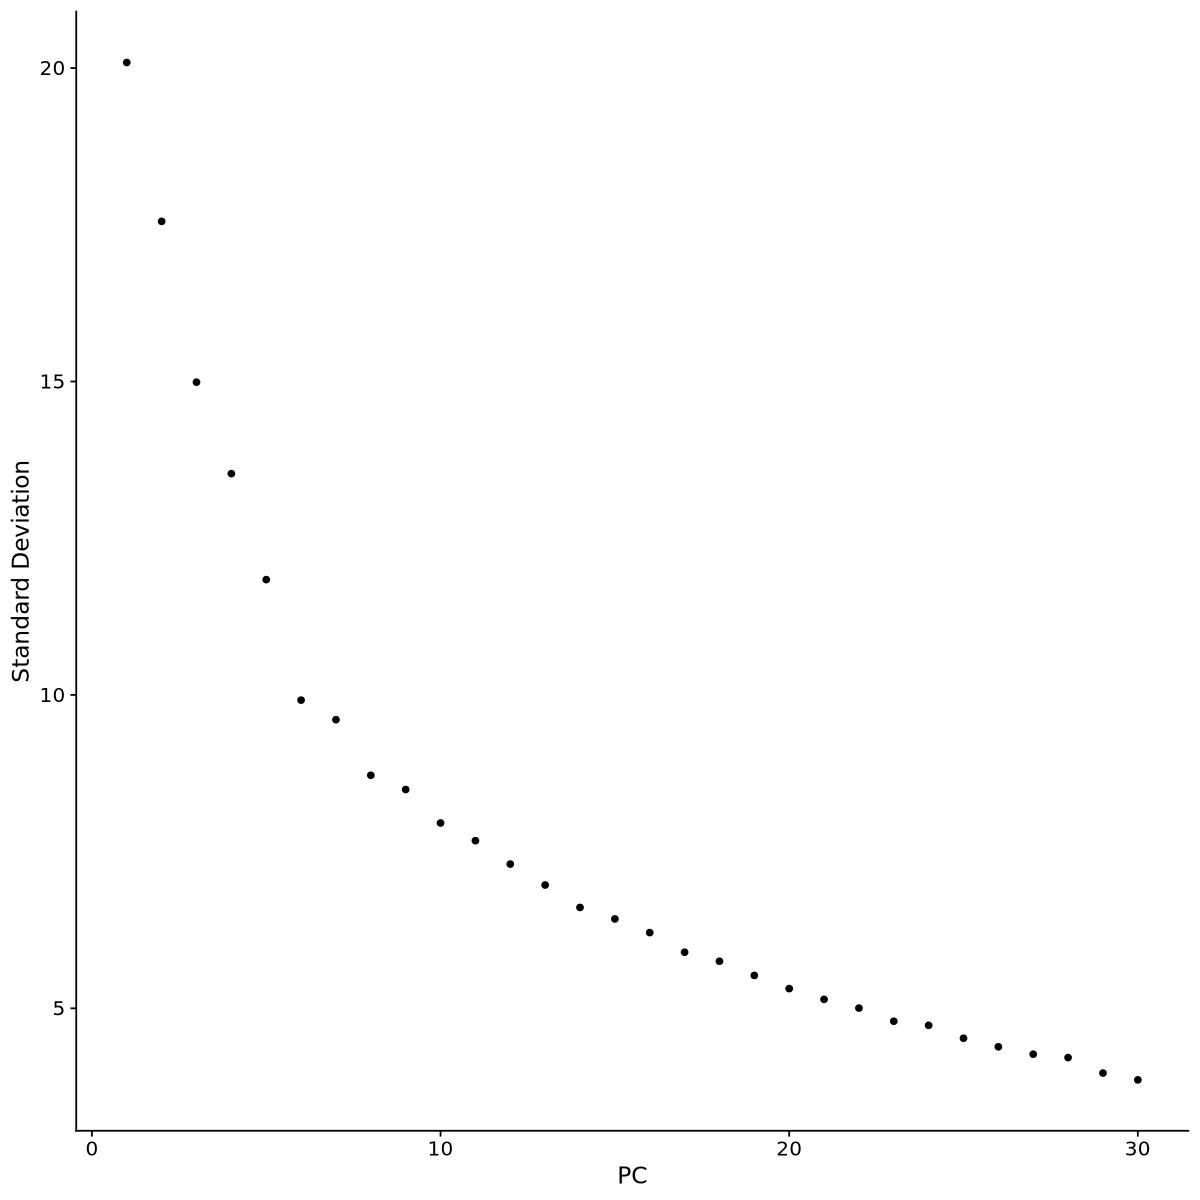

In [94]:
#| label: fig-elbowint
#| fig-cap: "Elbow plot of integrated datasets"

ElbowPlot(seurat.integrated, ndims = 30)

In [95]:
seurat.integrated <- FindNeighbors(object = seurat.integrated, dims = 1:20, k.param = 30)

Computing nearest neighbor graph

Computing SNN



In [96]:
seurat.integrated <- RunUMAP(object = seurat.integrated, dims = 1:20, a=.8, b=.8)

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

13:34:01 Read 20572 rows and found 20 numeric columns

13:34:01 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

13:34:01 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:34:03 Writing NN index file to temp file /tmp/RtmpnH6zJf/file4392b2ad167

13:34:03 Searching Annoy index using 8 threads, search_k = 3000

13:34:04 Annoy recall = 100%

13:34:05 Commencing smooth kNN distance calibration using 8 threads
 with target n_neighbors = 30

13:34:07 Initializing from normalized Laplacian + noise (using irlba)

13:34:18 Commencing optimization fo

In [97]:
seurat.integrated <- SetIdent(seurat.integrated, value = "orig.ident")

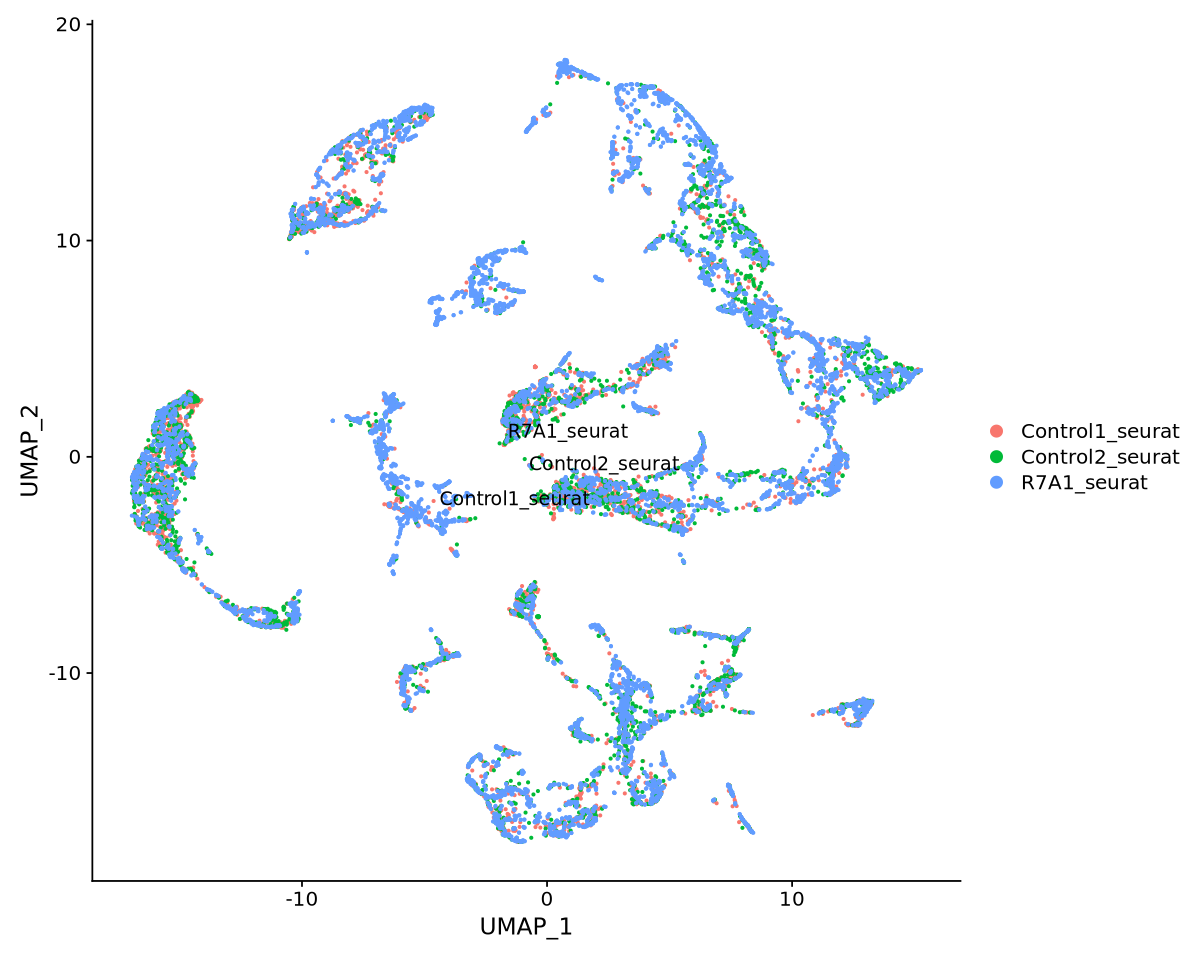

In [98]:
#| label: fig-umapint
#| fig-cap: "UMAP of the integrated datasets."

options(repr.plot.width=10, repr.plot.height=8)
DimPlot(object = seurat.integrated, reduction = "umap",  label = T, repel = TRUE, pt.size = 0.5)

We save our integrated data

In [101]:
SaveH5Seurat(object = seurat.integrated, filename = "seurat.integrated.h5Seurat", overwrite=TRUE)

Warning message:
“Overwriting previous file seurat.integrated.h5Seurat”
Creating h5Seurat file for version 3.1.5.9900

Adding counts for SCT

Adding data for SCT

Adding scale.data for SCT

No variable features found for SCT

No feature-level metadata found for SCT

Writing out SCTModel.list for SCT

Adding counts for RNA

Adding data for RNA

No variable features found for RNA

No feature-level metadata found for RNA

Adding data for integrated

Adding scale.data for integrated

Adding variable features for integrated

No feature-level metadata found for integrated

Writing out SCTModel.list for integrated

Adding cell embeddings for pca

Adding loadings for pca

No projected loadings for pca

Adding standard deviations for pca

No JackStraw data for pca

Adding cell embeddings for umap

No loadings for umap

No projected loadings for umap

No standard deviations for umap

No JackStraw data for umap



## Clustering and cell type assignment

We perform clustering on the data using the leiden algorithm (blondel_fast_2008, @traag_louvain_2019). Then, we look at a typical strategy of **naming clusters by visualizing known markers**. Since this is very subjective and biased, we then resort to naming cell types **using a reference annotated dataset**. An overview of cell type assignment procedures can be found at @cheng_review_2023.

In [102]:
seurat.integrated <-  LoadH5Seurat("seurat.integrated.h5Seurat", verbose=FALSE)

Validating h5Seurat file

Warning message:
“Adding a command log without an assay associated with it”


Clustering function `FindClusters`. The resolution is used to change the number of clusters detected. We do not need many, so we set on to 0.5. Usual values range between 0.1 and 1.

In [103]:
seurat.integrated <- FindClusters(object = seurat.integrated, 
                                  resolution = .5,
                                  random.seed = 123)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 20572
Number of edges: 1140129

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9378
Number of communities: 20
Elapsed time: 2 seconds


Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


The clusters are saved in the meta data table as `integrated_snn_res.0.25`. **Note that the name changes with the resolution**. Also observe how much metadata we have: many columns come from tools we have applied, such as doubletfinder (DF) and nearest neighbor distances (snn).

In [104]:
head( seurat.integrated@meta.data )

nCount_RNA nFeature_RNA nCount_SCT nFeature_SCT
AAACCCACATGATCTG-1_1 20942      4711         11291      4192        
AAACCCAGTAGCTTGT-1_1 29105      5157         10486      3382        
AAACCCAGTCTCTCAC-1_1  6115      2124         10086      2163        
AAACCCATCACCTTGC-1_1  7410      2988         10003      2985        
AAACGAAAGTCCTGTA-1_1  5616      2034          9866      2097        
AAACGAAAGTGTGTTC-1_1 12580      3329         11180      3328        
                     orig.ident      Condition percent.mt percent.chloroplast
AAACCCACATGATCTG-1_1 Control1_seurat Control   0.4775093  0.12415242         
AAACCCAGTAGCTTGT-1_1 Control1_seurat Control   0.2954819  0.05497337         
AAACCCAGTCTCTCAC-1_1 Control1_seurat Control   1.6026165  0.01635323         
AAACCCATCACCTTGC-1_1 Control1_seurat Control   0.5263158  0.09446694         
AAACGAAAGTCCTGTA-1_1 Control1_seurat Control   0.7122507  0.10683761         
AAACGAAAGTGTGTTC-1_1 Control1_seurat Control   0.1510334  0.06359300         
                     pANN_0.25_0.09_609 DF.classifications_0.25_0.09_609
AAACCCACATGATCTG-1_1 0.2299688          Singlet                         
AAACCCAGTAGCTTGT-1_1 0.2695109          Singlet                         
AAACCCAGTCTCTCAC-1_1 0.1904266          Singlet                         
AAACCCATCACCTTGC-1_1 0.2466181          Singlet                         
AAACGAAAGTCCTGTA-1_1 0.2382934          Singlet                         
AAACGAAAGTGTGTTC-1_1 0.2559834          Singlet                         
                     pANN_0.25_0.09_329 DF.classifications_0.25_0.09_329
AAACCCACATGATCTG-1_1 NA                 NA                              
AAACCCAGTAGCTTGT-1_1 NA                 NA                              
AAACCCAGTCTCTCAC-1_1 NA                 NA                              
AAACCCATCACCTTGC-1_1 NA                 NA                              
AAACGAAAGTCCTGTA-1_1 NA                 NA                              
AAACGAAAGTGTGTTC-1_1 NA                 NA                              
                     pANN_0.25_0.09_309 DF.classifications_0.25_0.09_309
AAACCCACATGATCTG-1_1 NA                 NA                              
AAACCCAGTAGCTTGT-1_1 NA                 NA                              
AAACCCAGTCTCTCAC-1_1 NA                 NA                              
AAACCCATCACCTTGC-1_1 NA                 NA                              
AAACGAAAGTCCTGTA-1_1 NA                 NA                              
AAACGAAAGTGTGTTC-1_1 NA                 NA                              
                     integrated_snn_res.0.5 seurat_clusters
AAACCCACATGATCTG-1_1 8                      8              
AAACCCAGTAGCTTGT-1_1 10                     10             
AAACCCAGTCTCTCAC-1_1 0                      0              
AAACCCATCACCTTGC-1_1 18                     18             
AAACGAAAGTCCTGTA-1_1 17                     17             
AAACGAAAGTGTGTTC-1_1 18                     18

We can plot the clusters in the UMAP plot

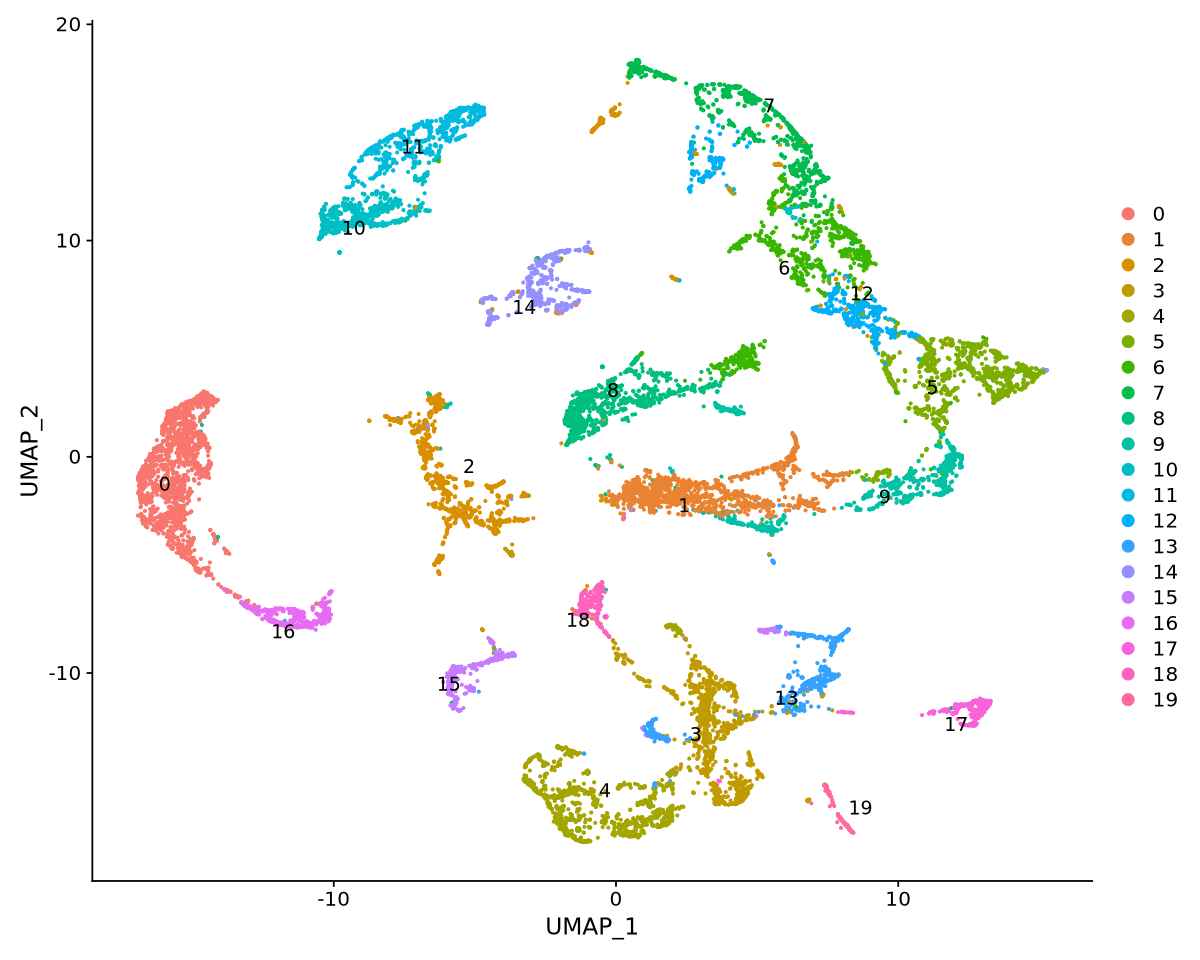

In [105]:
#| label: fig-umapleiden
#| fig-cap: "UMAP of the integrated datasets with clusters (still unassigned to cell types)."


options(repr.plot.width=10, repr.plot.height=8)
DimPlot(object = seurat.integrated, reduction = "umap",  label = T, repel = TRUE, pt.size = 0.5)

### Cluster assignment from visualized marker scores

Here, we look at how to assign names based on known markers. In this procedure, biological knowledge of the cell types is needed. Below, there is a list of known markers for each cell type, extracted from the supplementary data of @frank_single-cell_2023.

In [106]:
features_list <- list(
    'Cortex_scoring' = c("LotjaGi1g1v0006200",
                 "LotjaGi1g1v0022100",
                 "LotjaGi1g1v0261700",
                 "LotjaGi1g1v0348000",
                 "LotjaGi2g1v0303000",
                 "LotjaGi3g1v0505900"),
    'Epidermis_scoring' = c("LotjaGi1g1v0080000",
                    "LotjaGi1g1v0377600",
                    "LotjaGi1g1v0613100",
                    "LotjaGi3g1v0070500"),
    'Endodermis_scoring' = c("LotjaGi1g1v0114400",
                     "LotjaGi1g1v0221300",
                     "LotjaGi1g1v0240900-LC",
                     "LotjaGi1g1v0707500"), 
    'RootCap_scoring' = c("LotjaGi1g1v0020900",
                   "LotjaGi1g1v0039700-LC",
                   "LotjaGi1g1v0040300",
                   "LotjaGi1g1v0147500"),  
    'Meristem_scoring'= c("LotjaGi4g1v0300900",
                         "LotjaGi6g1v0056500",
                         "LotjaGi1g1v0594200"),
    'Phloem_scoring'= c("LotjaGi1g1v0028800",
                "LotjaGi1g1v0085900",
                "LotjaGi1g1v0119300",
                "LotjaGi1g1v0149100"),
    'QuiescentCenter_scoring' = c("LotjaGi1g1v0004300",
                           "LotjaGi1g1v0021400",
                           "LotjaGi1g1v0052700",
                           "LotjaGi1g1v0084000"),
    'RootHair_scoring'= c("LotjaGi1g1v0014300",
                   "LotjaGi1g1v0109000",
                   "LotjaGi1g1v0109100",
                   "LLotjaGi1g1v0143900"),  
    'Pericycle_scoring'= c("LotjaGi3g1v0222100",
                   "LotjaGi3g1v0395900-LC",
                   "LotjaGi5g1v0166000-LC",
                   "LotjaGi3g1v0395500-LC",
                   "LotjaGi1g1v0783700-LC",
                   "LotjaGi2g1v0333200",
                   "LotjaGi4g1v0293000-LC"),     
    'Stele_scoring' = c("LotjaGi2g1v0126700",
                "LotjaGi1g1v0558200",
                "LotjaGi4g1v0215500",
                "LotjaGi3g1v0174100",
                "LotjaGi5g1v0288600",
                "LotjaGi3g1v0129700"),
    'Xylem_scoring' = c("LotjaGi1g1v0623100",
                "LotjaGi1g1v0569300",
                "LotjaGi1g1v0443000",
                "LotjaGi1g1v0428800")
    )

Here, we need a function calculating the scores for each cell type. This is the average expression of the markers in the list, from which we remove the average expression of some control genes, which are supposed not to be specific for the cell type of interest. The cells matching the desired type should retain a high score.

In [107]:
seurat.clustered <- AddModuleScore(
  object = seurat.integrated,
  features = features_list,
  ctrl = 5,
  name = 'LJ_scores'
)

Warning message:
“The following features are not present in the object: LotjaGi1g1v0085900, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: LLotjaGi1g1v0143900, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: LotjaGi3g1v0129700, not searching for symbol synonyms”


We also apply a function (from `script.R`) to rename the scores in the metadata. Their names are not intuitive by default, they are all called with the name chosen above and a number after it:

In [108]:
names(seurat.clustered@meta.data)

[1] "nCount_RNA"                       "nFeature_RNA"                    
 [3] "nCount_SCT"                       "nFeature_SCT"                    
 [5] "orig.ident"                       "Condition"                       
 [7] "percent.mt"                       "percent.chloroplast"             
 [9] "pANN_0.25_0.09_609"               "DF.classifications_0.25_0.09_609"
[11] "pANN_0.25_0.09_329"               "DF.classifications_0.25_0.09_329"
[13] "pANN_0.25_0.09_309"               "DF.classifications_0.25_0.09_309"
[15] "integrated_snn_res.0.5"           "seurat_clusters"                 
[17] "LJ_scores1"                       "LJ_scores2"                      
[19] "LJ_scores3"                       "LJ_scores4"                      
[21] "LJ_scores5"                       "LJ_scores6"                      
[23] "LJ_scores7"                       "LJ_scores8"                      
[25] "LJ_scores9"                       "LJ_scores10"                     
[27] "LJ_scores11"

In [109]:
seurat.clustered <- renameScores(markers_list = features_list, seurat_data = seurat.clustered)      

Scores renamed FROM




LJ_scores1
LJ_scores2
LJ_scores3
LJ_scores4
LJ_scores5
LJ_scores6
LJ_scores7
LJ_scores8
LJ_scores9
LJ_scores10
LJ_scores11




TO




Cortex_scoring
Epidermis_scoring
Endodermis_scoring
RootCap_scoring
Meristem_scoring
Phloem_scoring
QuiescentCenter_scoring
RootHair_scoring
Pericycle_scoring
Stele_scoring
Xylem_scoring


Now we run the function `plotScoresUMAP` (from the file `script.R`). In @fig-scores we can see that some clusters are easy to classify (phloem and xylem), but many others are not. This is mainly due to the fact that the change of many cell types is a continuum, and this manual annotation is very subjective.

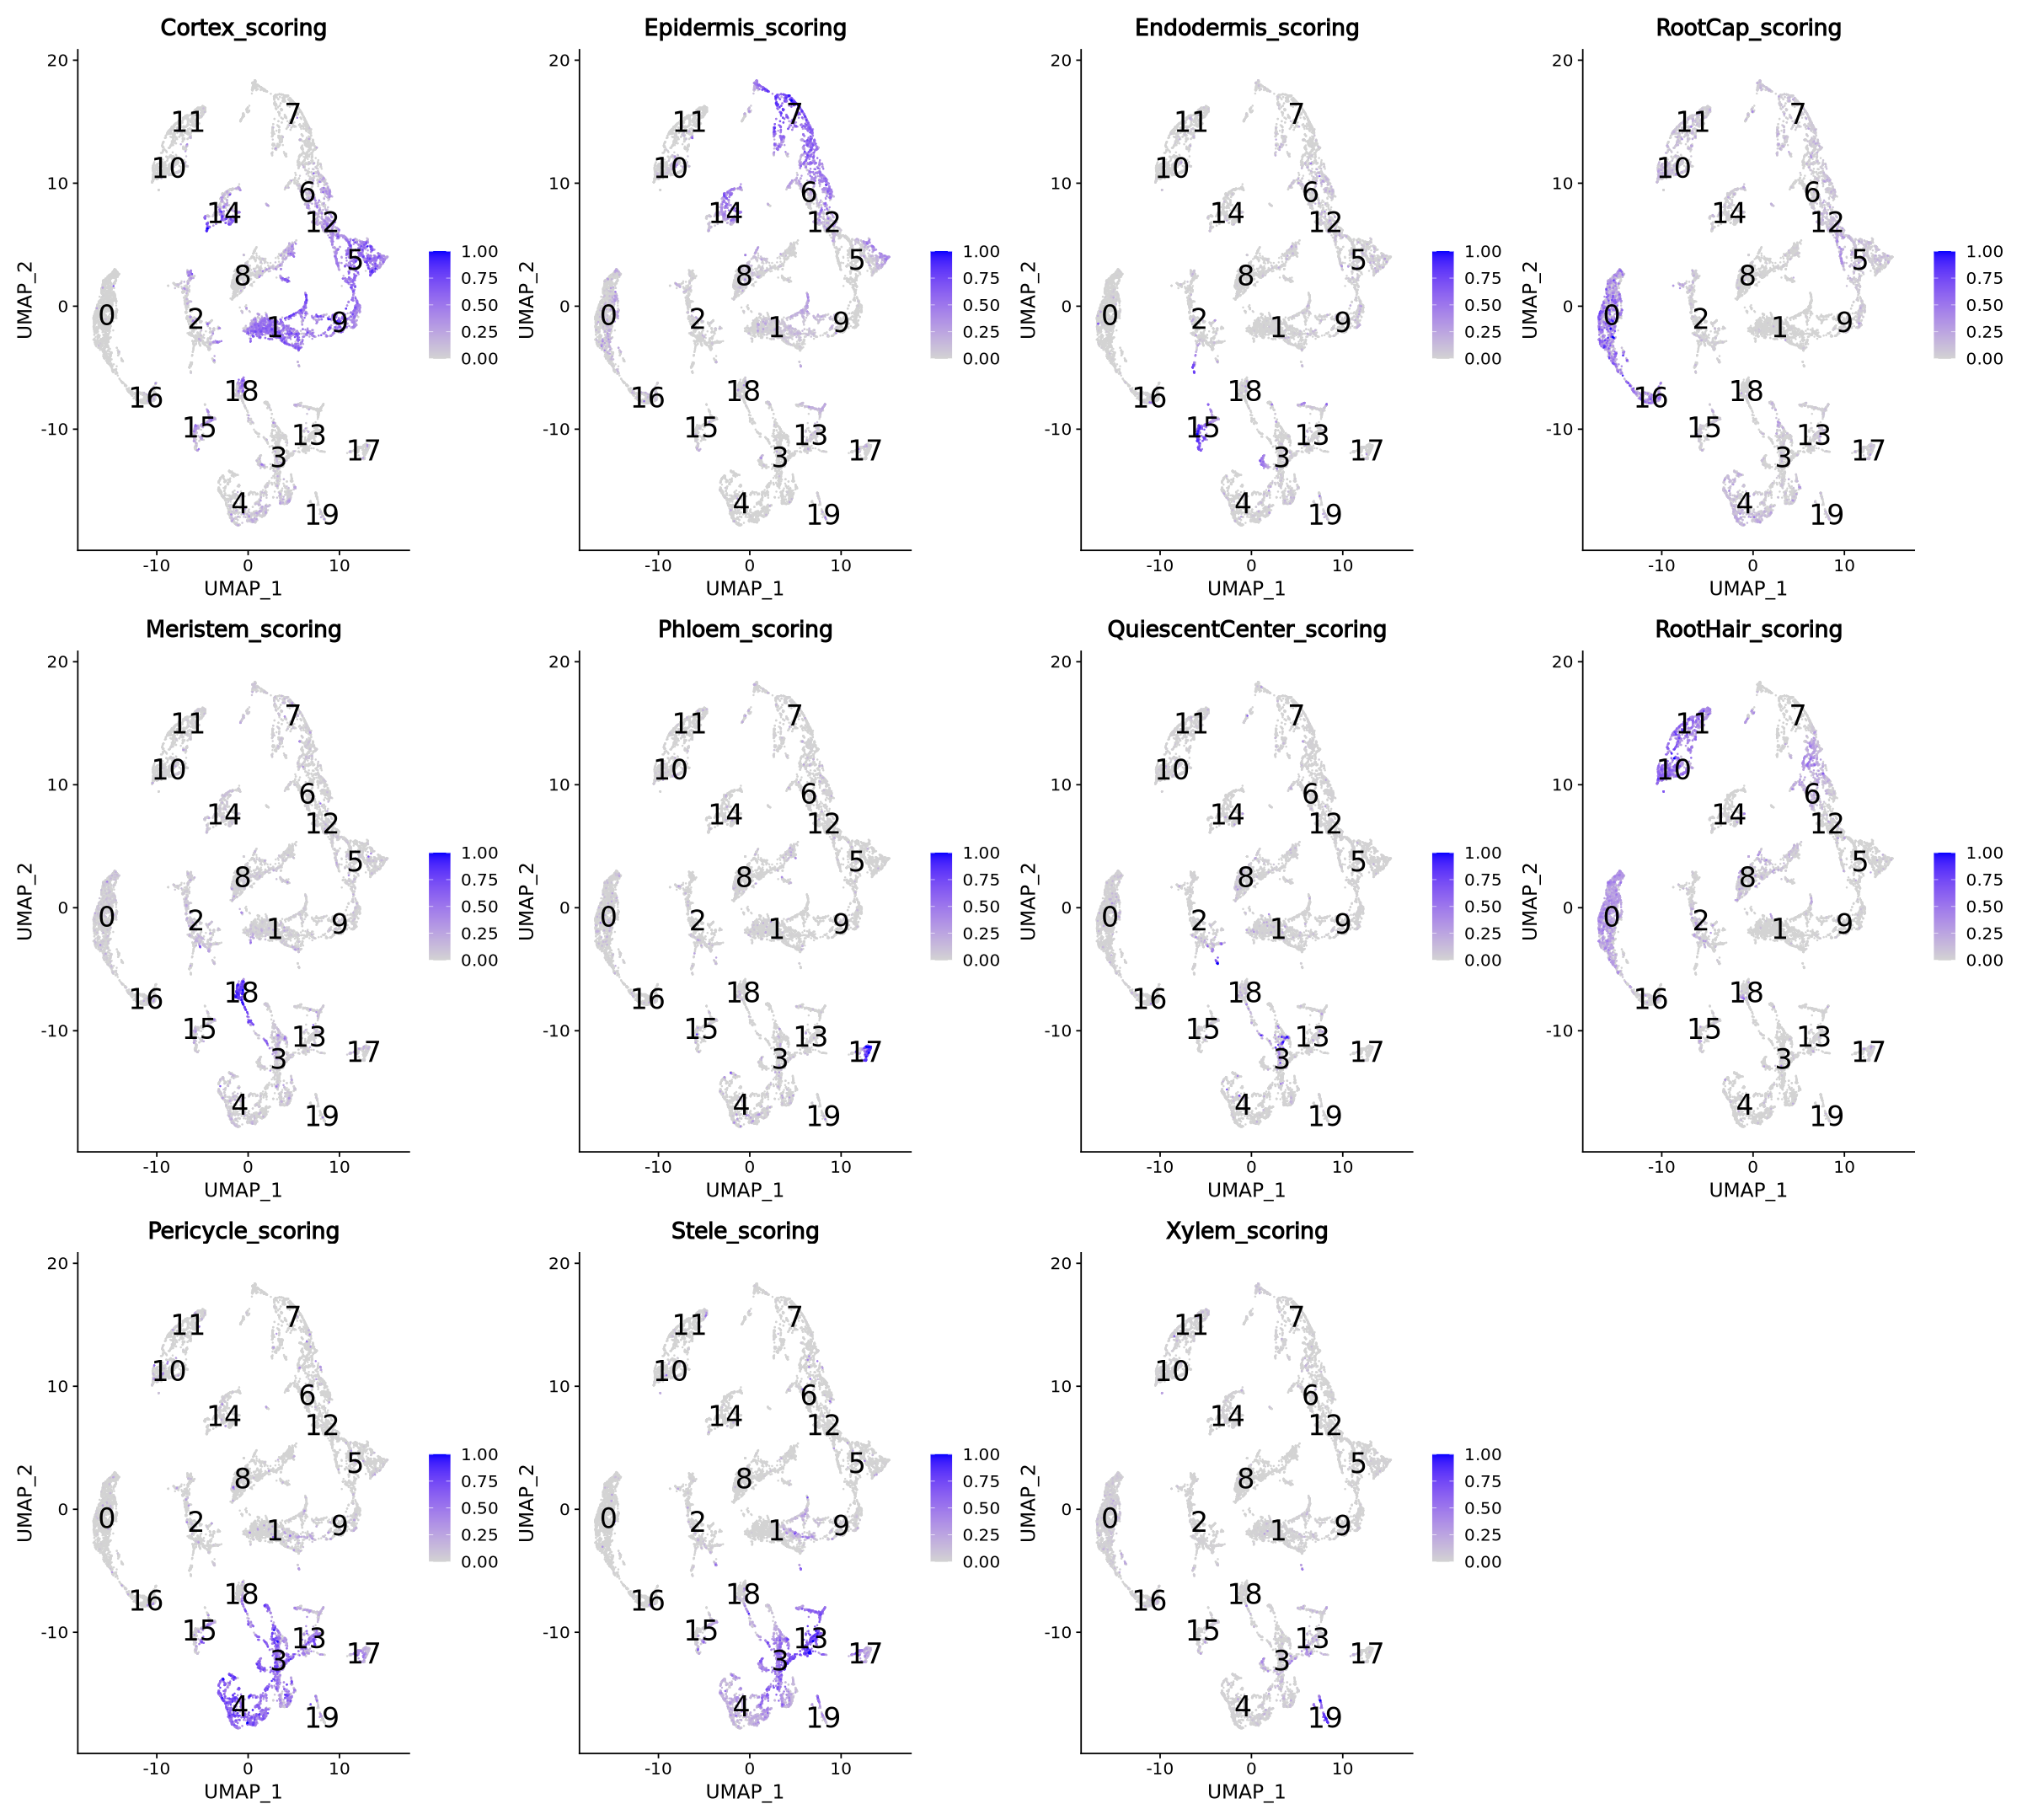

In [110]:
#| label: fig-scores
#| fig-cap: "Scores of the list of markers for the Lotus Japonicus clusters. Those should help identifying cell types by plotting the average of markers subtracted the average of other random genes in the data."

plotScoresUMAP(markers_list = features_list, seurat_data = seurat.clustered)                                  

One easy solution is to use the highest scoring of each cluster to assign the cluster name. Below, in the function `clusterNames`, for each cluster, we sum the scores of each cell type, and the highest value decides the cluster name.

In [111]:
#use the clustering above
Idents(seurat.clustered) <- 'integrated_snn_res.0.5' 
#assign names
seurat.clustered@meta.data["Cell_types"] <- clusterNames(seurat.clustered, features_list)
#use the new names as clustering labels
Idents(seurat.clustered) <- 'Cell_types'

Cluster assignment started

--- QuiescentCenter assigned to 8

--- RootHair assigned to 10

--- RootCap assigned to 0

--- Meristem assigned to 18

--- Phloem assigned to 17

--- Pericycle assigned to 4

--- Stele assigned to 13

--- Endodermis assigned to 2

--- Epidermis assigned to 12

--- Cortex assigned to 5

--- Epidermis assigned to 7

--- Epidermis assigned to 6

--- Pericycle assigned to 3

--- Xylem assigned to 19

--- Cortex assigned to 1

--- RootCap assigned to 16

--- RootHair assigned to 11

--- Cortex assigned to 9

--- Epidermis assigned to 14

--- Endodermis assigned to 15

Cluster assignment finished



:::{.callout-note title="Manual assignment"}
If you wanted to manually assign cell types, then you could use the command `RenameIdents`, for example

```
Idents(seurat.clustered) <- 'integrated_snn_res.0.5'

seurat.clustered <- RenameIdents(object = seurat.clustered,
                               "2"="Cortex", "5"="Cortex", "11"="Cortex",
                               "6"="Epidermis", "12"="Epidermis", "7"="Epidermis",
                               "15"="Endodermis",  
                               "0"="Root_Cap", "13"="Root_Cap",
                               "16"="Meristem",  
                               "17"="Phloem",
                               "10"="Root_Hair", "9"="Root_Hair",
                               "1"="PericycleStele", 
                               "3"="Pericycle", "19"="Pericycle",
                               "20"="Xylem")
```

(the names do not match correctly the numbers of our clustering, they are just for the sake of the example)

:::

It seems from @fig-umapbyeye that we have quite consistent clustering across the various cell types.

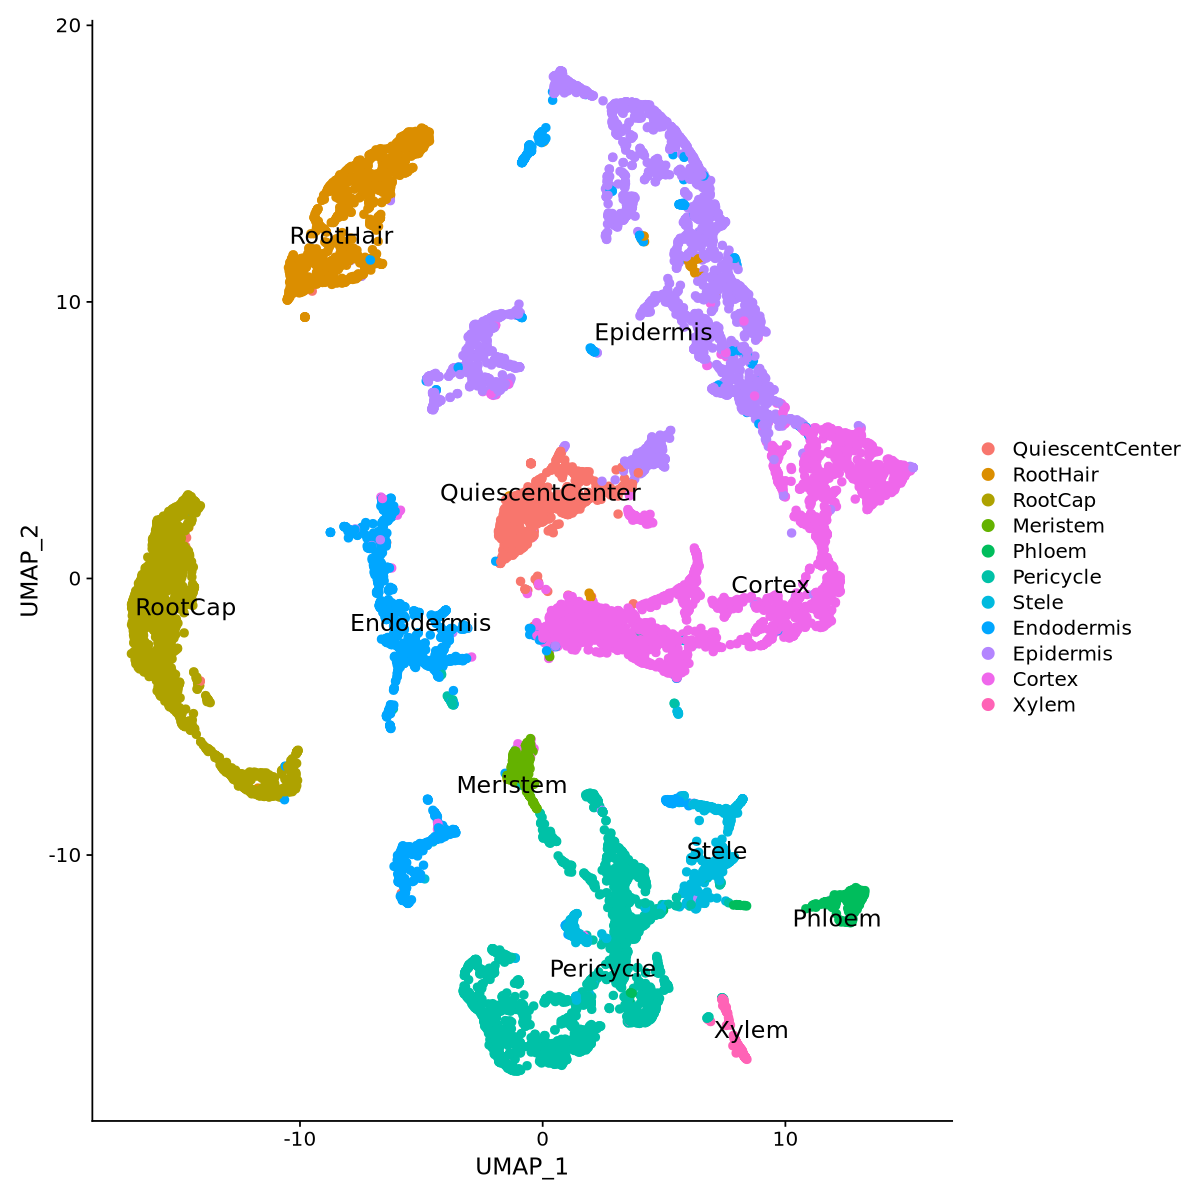

In [112]:
#| label: fig-umapbyeye
#| fig-cap: "UMAP of the integrated datasets with clusters assigned by looking at markers scores and using a function to assign score-based names. Note that there are a few cells here and there that are not labelled correctly, which often happens as a few datapoints are noisy." 

options(repr.plot.width=10, repr.plot.height=10)
DimPlot(object = seurat.clustered, reduction = "umap", repel = TRUE, label=T, pt.size = 2, label.size = 5)

#### Optional: assigning a mixed cluster

Consider the marker plots for pericycle and Stele cell types in @fig-scores. Here you can see overlap of the markers, which is not unnormal, since biological processes often transition gradually and eventually share some markers. We can try to separate the two cell types more precisely by assigning the cell type to each single data point, by comparing its score for Pericycle and Stele, instead of renaming each cluster as a whole.

The code below runs such comparison for each cell in the pericycle and stele clusters.

In [118]:
peri <- seurat.clustered@meta.data$Pericycle_scoring[ seurat.clustered@meta.data$Cell_types == 'Pericycle' | seurat.clustered@meta.data$Cell_types == 'Stele']
stel <- seurat.clustered@meta.data$Stele_scoring[ seurat.clustered@meta.data$Cell_types == 'Pericycle' | seurat.clustered@meta.data$Cell_types == 'Stele' ]
peri_stele <- peri>=stel
finalcl = c()
for(i in peri_stele)
    finalcl = c(finalcl, ifelse(i, "Pericycle", "Stele"))

celltypes <- seurat.clustered@meta.data$Cell_types
celltypes[ seurat.clustered@meta.data$Cell_types == 'Pericycle' | seurat.clustered@meta.data$Cell_types == 'Stele' ] <- finalcl
seurat.clustered@meta.data$Cell_types <- celltypes
Idents(seurat.clustered) <- 'Cell_types'

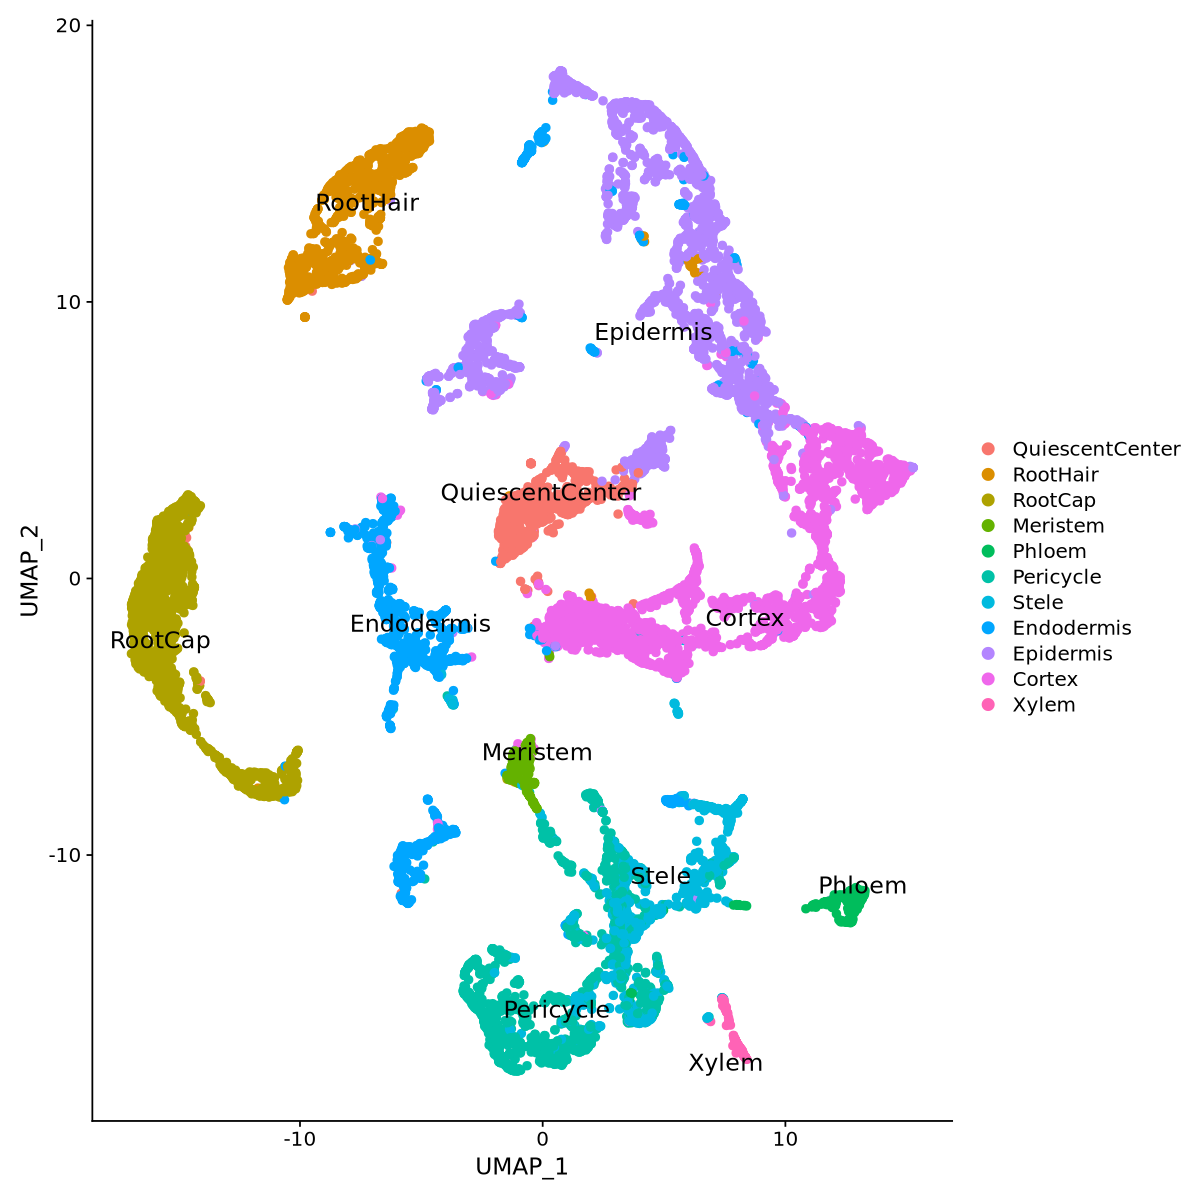

In [119]:
#| label: fig-umapsubcluster
#| fig-cap: "UMAP of the integrated datasets with clusters assigned by refining Pericycle and Stele." 

options(repr.plot.width=10, repr.plot.height=10)
DimPlot(object = seurat.clustered, reduction = "umap", repel = TRUE, label=T, pt.size = 2, label.size = 5)

### Cluster assignment from an annotated dataset

We now use the annotated data from @frank_single-cell_2023 (which is the same we are using in the tutorial) to transfer data labels to our own processed data. More about label transfer can be read at @stuart_comprehensive_2019. We load the data from the paper and define reference and query data. 

In [120]:
seurat.reference <- readRDS("../Data/data_lavinia.RDS")

In [121]:
seurat.query <- seurat.clustered

We have to define the data integration between query and reference before we can transfer the cluster names. For the algorithm to work, we need to use the "RNA" assay, which contains raw expression values.

In [122]:
DefaultAssay(seurat.query) <- "RNA"

In [123]:
lotusjaponicus.anchors <- FindTransferAnchors(reference = seurat.reference, 
                                        features = intersect( rownames(seurat.query), 
                                                   rownames( seurat.reference[['SCT']]@scale.data ) ),
                                        query = seurat.query, dims = 1:20, 
                                        reference.reduction = "pca",
                                        reference.assay='RNA')

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 26902 anchors

Filtering anchors

	Retained 13016 anchors



Calculating the integration of the labels from the reference takes time. So we save the calculated anchors for the integration. If you need to rerun the code, skip the command above and instead load the data with `readRDS` below.

In [124]:
saveRDS(lotusjaponicus.anchors, file = "anchors.RDS")

In [125]:
lotusjaponicus.anchors <- readRDS("anchors.RDS")

Now it is finally time to transfer the labels and add them to the metadata. The column in the metadata is called by default `predicted.id`.

In [126]:
predictions <- TransferData(anchorset = lotusjaponicus.anchors, 
                            refdata = Idents(seurat.reference), 
                            dims = 1:20)

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [127]:
seurat.clustered <- AddMetaData(seurat.clustered, metadata = predictions['predicted.id'])

Just as a reminder of what is in the metadata, we can quickly look at the column names. Those are ordered by when we added things along the analysis. If you read the names, you can recognize part of the analysis steps until now.

In [128]:
names( seurat.clustered@meta.data )

[1] "nCount_RNA"                       "nFeature_RNA"                    
 [3] "nCount_SCT"                       "nFeature_SCT"                    
 [5] "orig.ident"                       "Condition"                       
 [7] "percent.mt"                       "percent.chloroplast"             
 [9] "pANN_0.25_0.09_609"               "DF.classifications_0.25_0.09_609"
[11] "pANN_0.25_0.09_329"               "DF.classifications_0.25_0.09_329"
[13] "pANN_0.25_0.09_309"               "DF.classifications_0.25_0.09_309"
[15] "integrated_snn_res.0.5"           "seurat_clusters"                 
[17] "Cortex_scoring"                   "Epidermis_scoring"               
[19] "Endodermis_scoring"               "RootCap_scoring"                 
[21] "Meristem_scoring"                 "Phloem_scoring"                  
[23] "QuiescentCenter_scoring"          "RootHair_scoring"                
[25] "Pericycle_scoring"                "Stele_scoring"                   
[27] "Xylem_scoring"                    "Cell_types"                      
[29] "predicted.id"

Here we define as clustering for the data and the plots, the one transfered just before. We then have a look at @fig-transfer to observe that the labels look fine.

In [129]:
Idents(seurat.clustered) <- 'predicted.id'

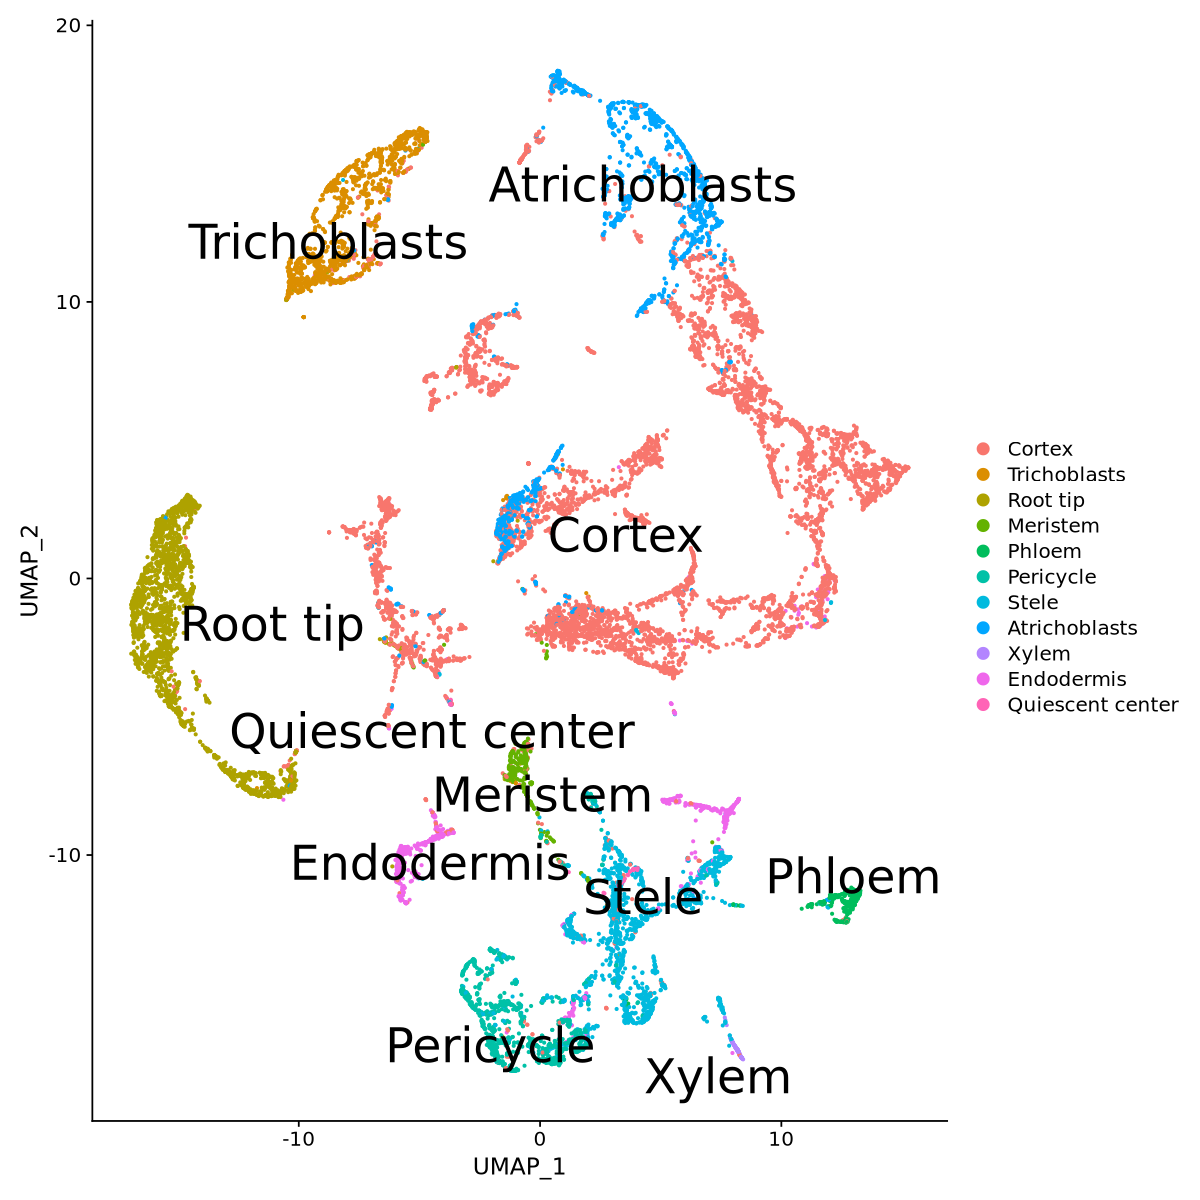

In [130]:
#| label: fig-transfer
#| fig-cap: "UMAP of the integrated datasets with cell types named through label transfer."

options(repr.plot.width=10, repr.plot.height=10)
DimPlot(object = seurat.clustered, 
        reduction = "umap", 
        repel = TRUE, label=T, 
        pt.size = 0.5, label.size = 10, )

We save the data

In [131]:
SaveH5Seurat(object = seurat.clustered, 
             filename = "seurat.clustered.h5Seurat", 
             overwrite = TRUE,
             verbose=FALSE)

Warning message:
“Overwriting previous file seurat.clustered.h5Seurat”
Creating h5Seurat file for version 3.1.5.9900



# Gene Expression Analysis {#sec-geneanalysis}

In this section we explore the gene expression through

- determining **differentially expressed genes** for the infected condition against the control. Differentially expressed genes are significantly more epressed in one of the two groups used for the comparison. Usually the wild type is used as query for the comparison, such that differentially expressed genes are referred to the perturbated condition (infection, knock-out, illness, ...)
- studying **coexpression modules** (a module is a group of gene similarly expressed across cells in the data) to find if
    - any of them contains the gene of interest,
    - they are significantly more expressed in specific cell groups (**Differential module expression**)
    - if there are specific known functions associated to some modules

We will also use gene ontology terms for understanding the function of groups of genes.

## Differential Gene Expression (DGE)

Here we test each cluster to see which are significantly more expressed genes in the infected samples compared to the wild-type samples. We also see if we find the gene RINRK1 as being significant. Again, the resulting genes can be useful to be integrated with the GO terms as we did before.

We first have a quick look to see how much the RINRK1 gene is expressed in the data. We use the `RNA` assay to plot the true expression values. The UMAP plot shows few cells expressing the genes, meaning its average expression is going to be very low, so it is likely we will not find the gene to be differentially expressed anywhere.

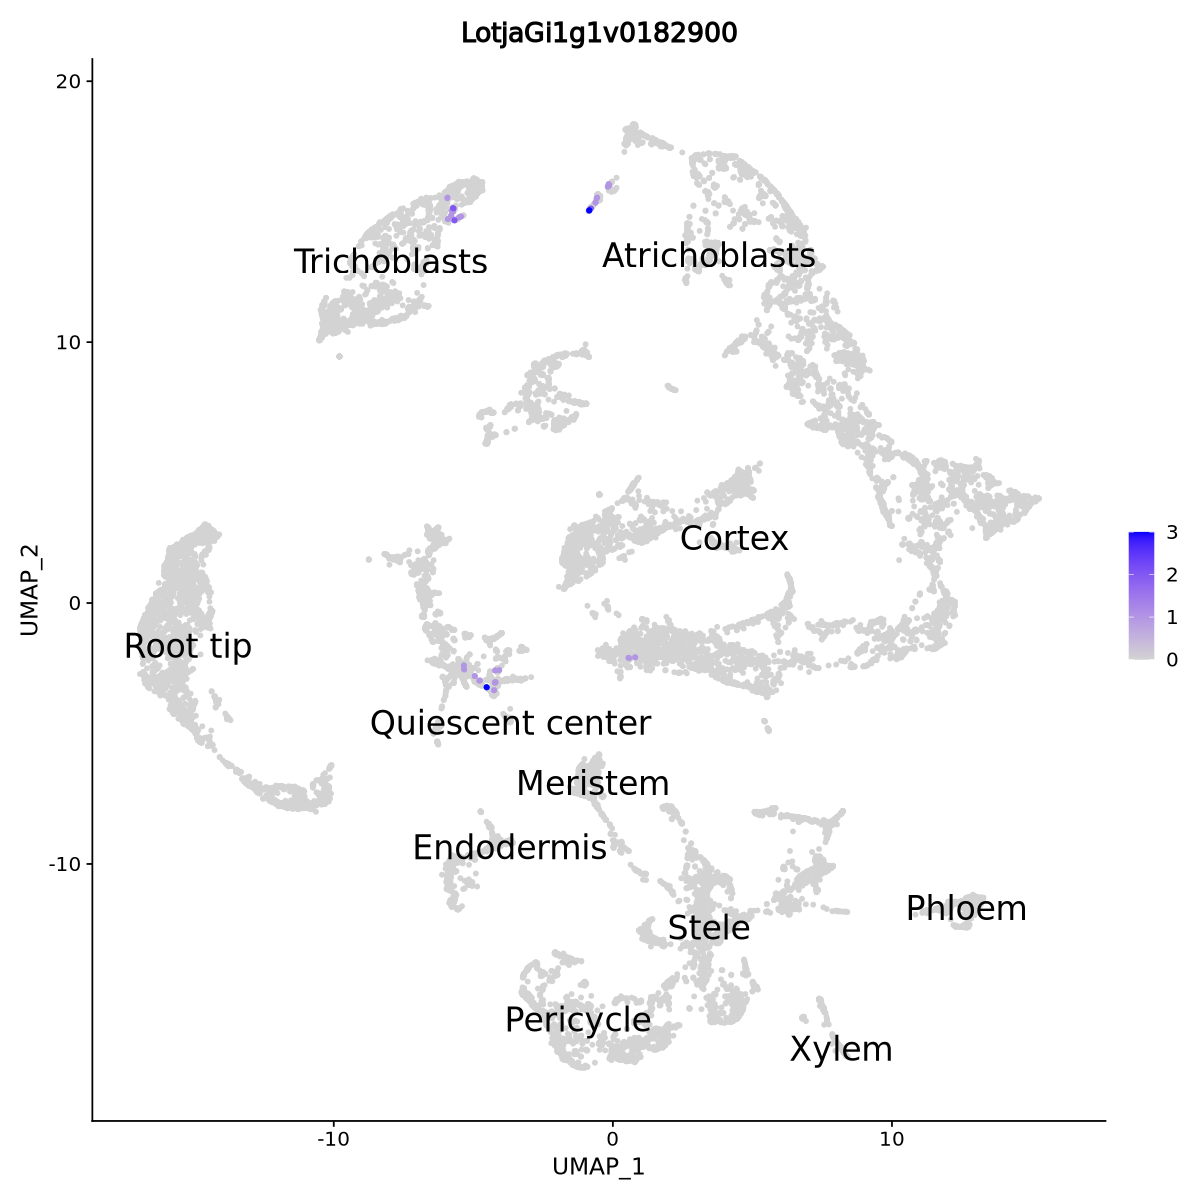

In [132]:
#| label: fig-rinrk
#| fig-cap: UMAP plot for the expression of gene RINRK1 in the data

RINRK1.id <- 'LotjaGi1g1v0182900'

DefaultAssay(seurat.clustered) <- "RNA"

FeaturePlot(seurat.clustered,
            reduction = "umap", 
            features = c(RINRK1.id), 
            order = TRUE,
            min.cutoff = 0, 
            pt.size = 1,
            label = TRUE,
            label.size = 7) + theme(legend.position = "right")

From biological knowledge, we expect the gene mostly expressed in the cortex and trichoblasts upon inoculation with rhizobia, and that is what happens in our data as well. We can see it in the code and violin plot of @fig-vln

In [133]:
cat("Cells in inoculated L.J. expressing", RINRK1.id, "\n")

cat( sum( as.numeric(GetAssayData(seurat.clustered[RINRK1.id,]))>0 & 
     seurat.clustered@meta.data$Condition=="R7A" ) )

cat("\nCells in control L.J. expressing", RINRK1.id, "\n")

cat( sum( as.numeric(GetAssayData(seurat.clustered[RINRK1.id,]))>0 & 
    seurat.clustered@meta.data$Condition=="Control" ) )

Cells in inoculated L.J. expressing LotjaGi1g1v0182900 
56
Cells in control L.J. expressing LotjaGi1g1v0182900 
0

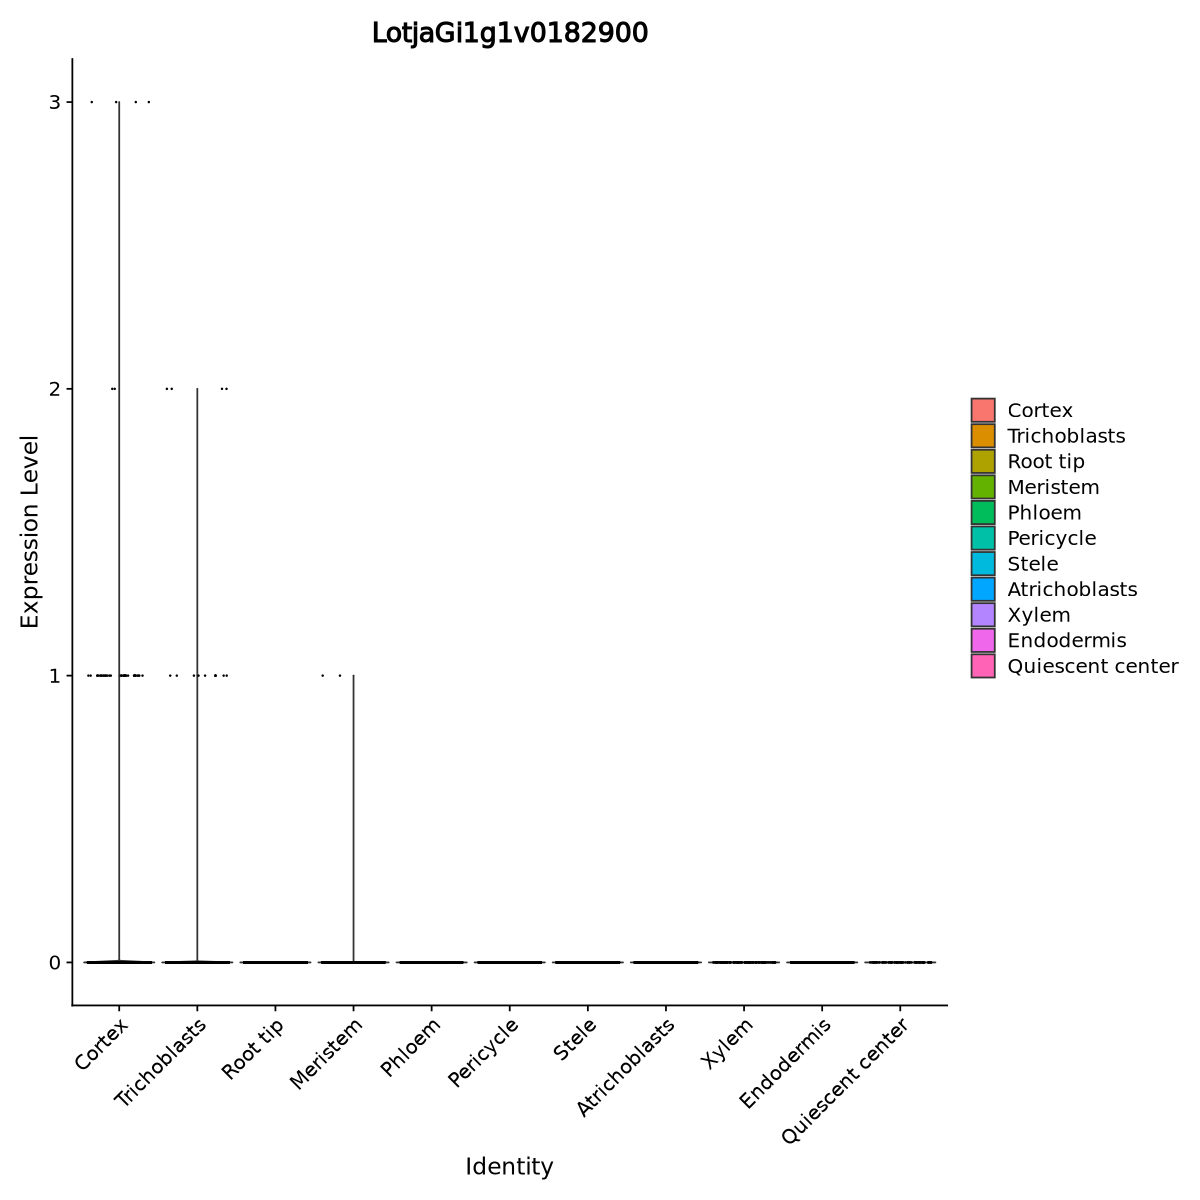

In [134]:
#| label: fig-vln
#| fig-cap: Violin plot for the expression of gene RINRK1 in various clusters

VlnPlot(seurat.clustered, 
        features = RINRK1.id)



The code below uses `FindMarkers` to compare `R7A` condition against `Control` for each cluster, with a filter to remove non-singnificant genes (keeping p-value below 0.001 and log fold change > 1 and < -1). We keep also genes expressed 30% more than in the condition where they are underexpressed. We use only the 2000 most variable genes, since we are interested in very variable gene expressions across data.

In [135]:
seurat.clustered <- FindVariableFeatures(seurat.clustered, nfeatures = 2000, assay = "integrated")

Warning message:
“Not all features provided are in this Assay object, removing the following feature(s): LotjaGi2g1v0240800, LotjaGi2g1v0095600, LotjaGi1g1v0324300, LotjaGi2g1v0394200, LotjaGi5g1v0341600, LotjaGi2g1v0130600-LC, LotjaGi6g1v0167000-LC, LotjaGi1g1v0358100, LotjaGi3g1v0487600, LotjaGi1g1v0766200, LotjaGi1g1v0781500, LotjaGi1g1v0578800, LotjaGi3g1v0274700, LotjaGi2g1v0228100, LotjaGi4g1v0338800, LotjaGi2g1v0341400, LotjaGi1g1v0315100, LotjaGi1g1v0544500, LotjaGi5g1v0019000, LotjaGi5g1v0202500, LotjaGi4g1v0107800, LotjaGi3g1v0150400, LotjaGi1g1v0098500, LotjaGi2g1v0000800, LotjaGi2g1v0177400, LotjaGi5g1v0178500, LotjaGi6g1v0097400, LotjaGi2g1v0005400, LotjaGi1g1v0667100, LotjaGi4g1v0006600, LotjaGi3g1v0347800, LotjaGi2g1v0430200, LotjaGi2g1v0143500, LotjaGi4g1v0074400, LotjaGi4g1v0346500, LotjaGi4g1v0068000, LotjaGi5g1v0226200, LotjaGi3g1v0464000, LotjaGi6g1v0005900, LotjaGi3g1v0468000, LotjaGi3g1v0280300, LotjaGi5g1v0323100, LotjaGi4g1v0193600-LC, LotjaGi6g1v0155700, LotjaG

In [136]:
DEG_table <- FindMarkers(seurat.clustered, 
                             assay='integrated',
                             ident.1 = "R7A",
                             ident.2 = "Control", 
                             group.by = "Condition",
                             subset.ident="Cortex",
                             min.diff.pct = 0.3,
                             verbose = TRUE, 
                             features = seurat.clustered@assays$integrated@var.features,
                             test.use = "wilcox") %>%
                             filter(p_val_adj <= 0.001 & abs(avg_log2FC)>1) %>%
                             select(-p_val)

In [137]:
DefaultAssay(seurat.clustered) <- "integrated" #return to the integrated data
DEG <- data.frame()
cluster.names <- unique(Idents(seurat.clustered))

for(CLUSTER in cluster.names){
    DEG_table <- FindMarkers(seurat.clustered,
                             assay='integrated',
                             ident.1 = "R7A",
                             ident.2 = "Control", 
                             group.by = "Condition",
                             subset.ident=CLUSTER,
                             verbose = TRUE, 
                             min.diff.pct = 0.3,
                             features = seurat.clustered@assays$integrated@var.features,
                             test.use = "wilcox") %>%
                             filter(p_val_adj <= 0.001 & abs(avg_log2FC)>1) %>%
                             select(-p_val)
    if(dim(DEG_table)[1]>0){
        DEG_table$'cluster' <- CLUSTER
        DEG <- rbind(DEG, DEG_table)}
    else{
        message(paste0("---> Warning: No DE genes in cluster ", CLUSTER), appendLF=FALSE)}
    message(paste0("Done with cluster ",CLUSTER), appendLF=FALSE)
    }

DEG <- as.data.frame(DEG)
DEG$gene <- rownames(DEG)

Done with cluster Cortex
Done with cluster Trichoblasts
Done with cluster Root tip
Done with cluster Meristem
Done with cluster Phloem
Done with cluster Pericycle
Done with cluster Stele
Done with cluster Atrichoblasts
Done with cluster Xylem
Done with cluster Endodermis
Done with cluster Quiescent center


The table looks like this. Columns represent: 

* average logfoldchange between R7A and Control
* percentage of cells in R7A expressing the gene
* percentage of cells in Control expressing the gene
* adjusted p-value
* cluster
* gene

There are some genes in the table

In [138]:
dim(DEG)[1]

[1] 712

We now integrate GO terms using a table of predefined GO terms. The function doing that is `addGOterms`:

In [139]:
go_table <- read.table("../Data/LJ_GO_terms.gaf", skip=6, sep='\t', fill=TRUE, quote = "\"")

In [140]:
DEG <- addGOterms(DEG, go_table, n.cores = 16)

So we can see which GO terms are relevant in each cluster for the infected samples against the control:

In [141]:
DEG %>% filter(cluster=="Cortex" & GO!="Undefined")

avg_log2FC pct.1 pct.2 p_val_adj     cluster
LotjaGi2g1v0246800 3.061302   0.414 0.072 1.208504e-294 Cortex 
LotjaGi1g1v0066900 1.438645   0.403 0.072 5.606684e-140 Cortex 
LotjaGi1g1v0154100 4.261879   0.452 0.119 8.705013e-128 Cortex 
                   gene              
LotjaGi2g1v0246800 LotjaGi2g1v0246800
LotjaGi1g1v0066900 LotjaGi1g1v0066900
LotjaGi1g1v0154100 LotjaGi1g1v0154100
                   GO                                                                                                                      
LotjaGi2g1v0246800 L-threonine 3-dehydrogenase; TAIR: AT1G23740.1 Oxidoreductase, zinc-binding dehydrogenase family protein; Swiss-Prot: sp
LotjaGi1g1v0066900 1-aminocyclopropane-1-carboxylate oxidase; TAIR: AT1G05010.1 ethylene-forming enzyme; Swiss-Prot: sp                    
LotjaGi1g1v0154100 Flavonol synthase; TAIR: AT5G08640.1 flavonol synthase 1; Swiss-Prot: sp

Finally, we do not expect to find the RINRK1 gene as differentially expressed, because its expression is on average too low.

In [142]:
DEG %>% filter(gene==RINRK1.id)

avg_log2FC pct.1 pct.2 p_val_adj cluster gene GO

We can save the table for future use. Such a table can be downloaded and open in any table processor (such as Excel).

In [143]:
write.csv(DEG_table, "DEG_table.csv")

## Coexpression analysis {#sec-networks}

We use the package hdWGCNA to detect groups of cells expressed simultaneously, and we find which modules are differentially expressed in specific clusters. We look at the GO terms to gain biological insight in the data.

::: {.callout-note}

Before running hdWGCNA, we first have to set up the Seurat object. Most of the information computed by hdWGCNA will be stored in the Seurat object’s `@misc` slot. 

:::

Here we will set up the Seurat object using the `SetupForWGCNA` function, specifying the name of the `hdWGNCA` experiment. This function also selects the genes that will be used for WGCNA. The user can select genes using three different approaches using the posse gene_select parameter:

- variable: use the genes stored in the Seurat object’s VariableFeatures.
- fraction: use genes that are expressed in a certain fraction of cells for in the whole dataset or in each group of cells, specified by `group.by`.
- custom: use genes that are specified in a custom list.

In this example, we will select genes that are expressed in at least 5% of cells in this dataset, and we will name our `hdWGCNA` experiment “tutorial”.

In [144]:
seurat.clustered <- LoadH5Seurat("seurat.clustered.h5Seurat", verbose=FALSE)

Validating h5Seurat file

Warning message:
“Adding a command log without an assay associated with it”


In [145]:
seurat.clustered <- SetupForWGCNA(
  seurat.clustered,
  gene_select = "variable",
  fraction = 0.05, # fraction of cells that a gene needs to be expressed in order to be included
  wgcna_name = "tutorial" # the name of the hdWGCNA experiment
)

### Construct metacells

After we have set up our Seurat object, the first step in running the hdWGCNA pipeline is to construct metacells from the single-cell dataset. Briefly, metacells are **aggregates of small groups of similar cells originating from the same biological sample of origin**. 

![Workflow of hdWGCNA. Similar cells are summed or averaged together to form metacells. The resulting matrix is then used as the basis for inferring modules of coexpressed genes. The metacells expression matrix is the base for all the downstream analysis, such as differential expression of genes modules in specific clusters](./images/hdwgcna.jpg) {#fig-hdwgcna, width=800}

::: {.callout-tip title="Something more about hdWGCNA" collapse="true"}

The k-Nearest Neighbors (KNN) algorithm is used to identify groups of similar cells to aggregate, and then the average or summed expression of these cells is computed, thus yielding a metacell gene expression matrix (**as if you had many bulk samples**). The **sparsity of the metacell expression matrix is considerably reduced** when compared to the original expression matrix, and therefore it is preferable to use. We were originally motivated to use metacells in place of the original single cells because correlation **network approaches such as WGCNA are sensitive to data sparsity**.

`hdWGCNA` includes a function `MetacellsByGroups` to construct metacell expression matrices given a single-cell dataset. This function constructs a new Seurat object for the metacell dataset which is stored internally in the `hdWGCNA` experiment. The `group.by` parameter determines which groups metacells will be constructed in. We only want to construct metacells from cells that came from the same biological sample of origin, so it is critical to pass that information to `hdWGCNA` via the `group.by` parameter. Additionally, we usually construct metacells for each cell type separately. Thus, in this example, we are **grouping by Sample and cell type** to achieve the desired result.

**The number of cells to be aggregated `k` should be tuned based on the size of the input dataset**, in general a lower number for `k` can be used for small datasets. We generally use `k` values between 20 and 75. The dataset used for this tutorial has 21,369 cells, and here we use `k=30`. The amount of allowable overlap between metacells can be tuned using the `max_shared` argument. There should be a range of `k` values that are suitable for reducing the sparsity while retaining cellular heterogeneity for a given dataset, rather than a single optimal value.

Note: the authors of `hdWGCNA` have found that the metacell aggregation approach does not yield good results for extremely underrepresented cell types. For example, in this dataset, the `Meristem` and `Xylem` are the least represented, and will be excluded them from this analysis. `MetacellsByGroups` has a parameter `min_cells` to exclude groups that are smaller than a specified number of cells. **Errors are likely to arise if the selected value for `min_cells` is too low**.

:::

Here **we construct metacells and normalize the resulting expression matrix** using the following code (read the additional text in the box above to understand the parameters). Note how the clusters Xylem and Quiescent center are removed, simply because they contain too few cells and cannot be used. So from now on we do not consider them for the coexpression analysis. Note that we use the scaled integrated data matrix (assay `integrated` and slot `scale.data`), so that we take advantage of the integration procedure we have been running before to unbias the data from technical features.

In [147]:
# construct metacells  in each group
seurat.clustered <- MetacellsByGroups(
  seurat_obj = seurat.clustered,
  group.by = c("predicted.id", "Condition"), # specify metadata to split by cluster and condition
  reduction = 'pca', # select the dimensionality reduction to perform KNN on
  k = 30, # nearest-neighbors parameter
  max_shared = 10, # maximum number of shared cells between two metacells
  ident.group = 'predicted.id', # set the Idents of the metacell seurat object
  assay = "integrated",
  slot = "scale.data",
  min_cells = 100,
  wgcna_name = "tutorial",
  verbose=TRUE
)

Warning message in MetacellsByGroups(seurat_obj = seurat.clustered, group.by = c("predicted.id", :
“Removing the following groups that did not meet min_cells: Quiescent center#Control, Quiescent center#R7A, Xylem#Control, Xylem#R7A”
Overlap QC metrics:
Cells per bin: 30
Maximum shared cells bin-bin: 10
Mean shared cells bin-bin: 1.64052287581699
Median shared cells bin-bin: 0

Overlap QC metrics:
Cells per bin: 30
Maximum shared cells bin-bin: 10
Mean shared cells bin-bin: 1.26674432149097
Median shared cells bin-bin: 1

Overlap QC metrics:
Cells per bin: 30
Maximum shared cells bin-bin: 10
Mean shared cells bin-bin: 0.346860782529572
Median shared cells bin-bin: 0

Overlap QC metrics:
Cells per bin: 30
Maximum shared cells bin-bin: 10
Mean shared cells bin-bin: 0.888643725646683
Median shared cells bin-bin: 1

Overlap QC metrics:
Cells per bin: 30
Maximum shared cells bin-bin: 10
Mean shared cells bin-bin: 1.5741935483871
Median shared cells bin-bin: 0

Overlap QC metrics:
Cells per b

The metacell matrix always needs to be normalized, which is immediately done below

In [148]:
#normalize metacell expression matrix:
seurat.clustered <- NormalizeMetacells(seurat.clustered)

Warning message:
“Cannot find a parent environment called Seurat”


Here we specify the expression matrix that we will use for network analysis. It is natural to choose the integrated data matrix (which is chosen with the assay `integrated` and the matrix slot `counts`). We still need the data matrix after building the gene coexpression network when we want to evaluate the expression of each cell and gene in the original data.

In [150]:
seurat.clustered <- SetDatExpr(
  seurat.clustered,
  group_name = c('Pericycle','Cortex','Trichoblasts','Root tip',
                 'Phloem','Stele','Endodermis','Atrichoblasts',
                 'Meristem'), #all groups of interest in the data (we use all clusters)
  group.by='predicted.id', # the metadata column containing the cell type info. This same column should have also been used in MetacellsByGroups
  assay = 'integrated', # using integrated assay
  slot = 'counts' # using count data
)

### Select soft-power threshold

Next we will select the soft power threshold. This is an extremely important step in the pipeline. `hdWGCNA` constructs a gene-gene correlation adjacency matrix to infer co-expression relationships between genes. The correlations are **raised to a power to reduce the amount of noise present in the correlation matrix**, thereby **retaining the strong connections and removing the weak connections**. Therefore, it is critical to determine a proper value for the soft power threshold.

We use the function `TestSoftPowers` to perform a parameter sweep for different soft power thresholds. This function helps us to guide our choice in a soft power threshold for constructing the co-expression network by inspecting the resulting network topology for different power values.
The following code performs the parameter sweep and outputs a summary figure.

pickSoftThreshold: will use block size 2000.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 2000 of 2000


Warning message:
“executing %dopar% sequentially: no parallel backend registered”


   Power SFT.R.sq  slope truncated.R.sq  mean.k. median.k.  max.k.
1      1   0.7040  5.810          0.864 1.19e+03  1.21e+03 1400.00
2      2   0.3190  1.640          0.800 7.29e+02  7.42e+02 1020.00
3      3   0.0118  0.208          0.806 4.59e+02  4.63e+02  762.00
4      4   0.1290 -0.619          0.869 2.96e+02  2.93e+02  585.00
5      5   0.3790 -1.050          0.929 1.95e+02  1.88e+02  459.00
6      6   0.5690 -1.340          0.961 1.31e+02  1.22e+02  367.00
7      7   0.6620 -1.500          0.965 9.02e+01  8.02e+01  298.00
8      8   0.7310 -1.630          0.977 6.31e+01  5.31e+01  246.00
9      9   0.7900 -1.710          0.979 4.50e+01  3.54e+01  205.00
10    10   0.8280 -1.760          0.983 3.26e+01  2.37e+01  173.00
11    11   0.8590 -1.800          0.988 2.40e+01  1.60e+01  147.00
12    12   0.8690 -1.840          0.986 1.79e+01  1.08e+01  127.00
13    13   0.8730 -1.880          0.984 1.36e+01  7.50e+00  110.00
14    14   0.8930 -1.860          0.988 1.04e+01  5.15e+00   9

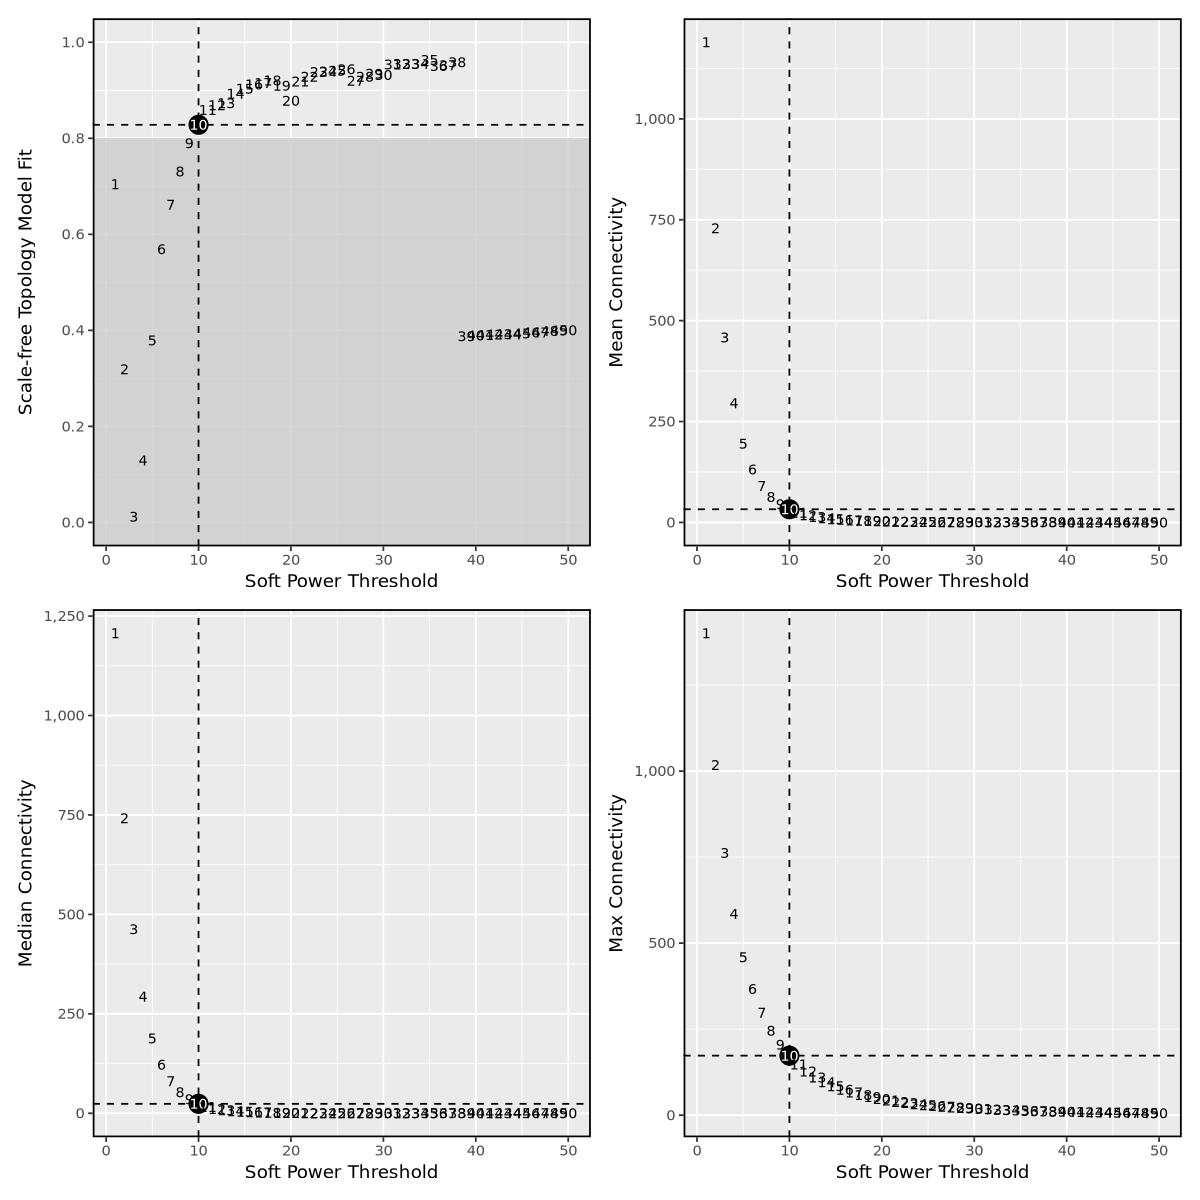

In [151]:
#| label: fig-sweep
#| fig-cap: Parameter sweep to choose the soft power threshold

# Test different soft powers:
seurat.clustered <- TestSoftPowers(powers = 1:50,
  seurat.clustered,
  networkType = 'signed'
)

# plot the results:
plot_list <- PlotSoftPowers(seurat.clustered)

# assemble with patchwork
wrap_plots(plot_list, ncol=2)

The general guidance for `hdWGCNA` is to pick the lowest soft power threshold that has Model Fit greater than or equal to 0.8. We will do it automatically, so you do not need to do it manually following the illustration fo @fig-sweep.

## Construction of co-expression network

We now have everything that we need to construct our co-expression network. Here we use the `hdWGCNA` function `ConstructNetwork`. This function has quite a few parameters to play with if you are an advanced user (read [this manual](https://rdrr.io/github/smorabit/hdWGCNA/man/ConstructNetwork.html) and the function `ConstructNetwork` is based on [here](https://www.rdocumentation.org/packages/WGCNA/versions/1.72-5/topics/blockwiseConsensusModules)), but we use default parameters that work well with many single-cell datasets. 

The following code selects the power threshold from the values plotted in @fig-sweep and constructs the co-expression network.

In [154]:
# automatic choice of soft power value
softPowerValue <- which(seurat.clustered@misc$tutorial$wgcna_powerTable$SFT.R.sq > .8)[1]
message(paste0("Chosen Soft Power Value: ",softPowerValue))

#multithreading for faster calculations
enableWGCNAThreads(nThreads = 8)

# construct co-expression network
seurat.clustered <- ConstructNetwork(na.rm=TRUE,
  seurat.clustered,
  soft_power=softPowerValue,                                   
  setDatExpr=FALSE,
  tom_name = 'Network', # name of the topoligical overlap matrix written to disk
  overwrite_tom = TRUE,
  randomSeed = 123
)

Chosen Soft Power Value: 10



Allowing parallel execution with up to 8 working processes.


Warning message in ConstructNetwork(na.rm = TRUE, seurat.clustered, soft_power = softPowerValue, :
“Overwriting TOM TOM/Network_TOM.rda”


 Calculating consensus modules and module eigengenes block-wise from all genes
 Calculating topological overlaps block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
    TOM calculation: adjacency..
    ..will use 8 parallel threads.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
 ..Working on block 1 .
 ..Working on block 1 .
 ..merging consensus modules that are too close..


We can plot the network dendrogram in @fig-dendro. Each leaf on the dendrogram represents a single gene, and the color at the bottom indicates the co-expression module assignment. Clusters with similar brancing heights contain genes that are more similar to each other in terms of expression patterns when compared to genes in clusters with higher variation in merging heights.

:::{.callout-note}
the “gray” module consists of genes that were not grouped into any co-expression module. The gray module is to be ignored for all downstream analysis and interpretation.**
:::

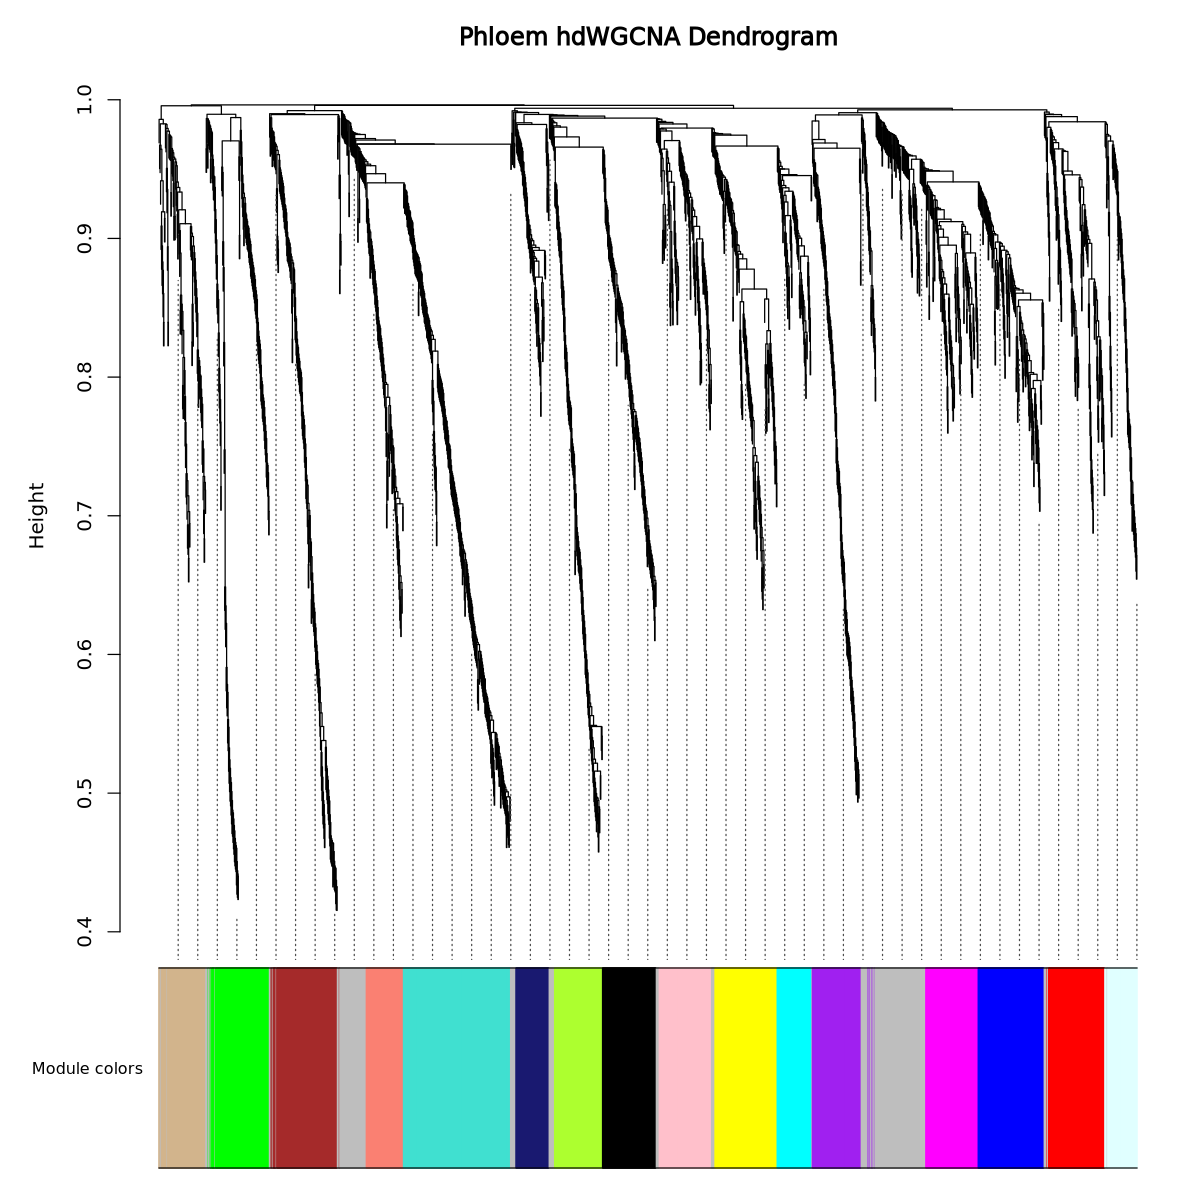

In [155]:
#| label: fig-dendro
#| fig-cap: Dendrogram of the genes coexpression network. Leaves at the bottom are genes, and the colours represent a module of coexpression for the corresponding genes. Gray areas are for genes not included in any module.

PlotDendrogram(seurat.clustered, main='Phloem hdWGCNA Dendrogram')

### Module Eigengenes (MEs)

We calculate harmonized module eigengenes. This is a way of doing PCA of the expression matrix of metacells including the genes of one coexpression module at a time. Thus we have a PCA of the data for each module. The first principal component of each PCA is called module eigengene: it is enough to distinguish one module from all the others and characterize the expression pattern of the module (@langfelder_eigengene_2007)!

Dimensionality reduction techniques are a very hot topic in single-cell genomics (@xiang_comparison_2021). It is well known that technical artifacts can muddy the analysis of single-cell datasets, and over the years there have been many methods that aim to reduce the effects of these artifacts. Therefore it stands to reason that MEs would be subject to these technical artifacts as well, and `hdWGCNA` seeks to alleviate these effects by using the integration software `Harmony` (@korsunsky_fast_2019).

The following code performs the module eigengene computation harmonizing by the Sample of origin using the `group.by.vars` parameter. We need to run `ScaleData` to avoid errors from the `harmony` software.

In [156]:
# need to run ScaleData first or else harmony throws an error:
seurat.clustered <- ScaleData(seurat.clustered, 
                              features=VariableFeatures(seurat.clustered), 
                              verbose = FALSE)

We still want to use the integrated data matrix to calculate the modules eigengenes, so we assign the scaled matrix to the `counts` slot, which is where `hdWGCNA` looks by default for computing module eigengenes.

In [157]:
seurat.clustered@assays$integrated@counts <- seurat.clustered@assays$integrated@scale.data

In [158]:
# compute all MEs in the full single-cell dataset
seurat.clustered <- ModuleEigengenes( 
 seurat.clustered,
 group.by.vars="orig.ident",
 verbose = FALSE
)

[1] "yellow"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcayellow to pcayellow_”


[1] "turquoise"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcaturquoise to pcaturquoise_”
Warning message:
“Key ‘harmony_’ taken, using ‘xlofa_’ instead”


[1] "tan"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcatan to pcatan_”


[1] "brown"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcabrown to pcabrown_”
Warning message:
“Key ‘harmony_’ taken, using ‘ujakm_’ instead”


[1] "red"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcared to pcared_”


[1] "lightcyan"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcalightcyan to pcalightcyan_”
Warning message:
“Key ‘harmony_’ taken, using ‘uyrtn_’ instead”


[1] "cyan"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcacyan to pcacyan_”


[1] "pink"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcapink to pcapink_”
Warning message:
“Key ‘harmony_’ taken, using ‘sakpn_’ instead”


[1] "salmon"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcasalmon to pcasalmon_”


[1] "grey"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagrey to pcagrey_”
Warning message:
“Key ‘harmony_’ taken, using ‘esfhp_’ instead”


[1] "purple"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcapurple to pcapurple_”


[1] "greenyellow"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagreenyellow to pcagreenyellow_”
Warning message:
“Key ‘harmony_’ taken, using ‘wajvi_’ instead”


[1] "green"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagreen to pcagreen_”


[1] "midnightblue"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcamidnightblue to pcamidnightblue_”
Warning message:
“Key ‘harmony_’ taken, using ‘rtnba_’ instead”


[1] "blue"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcablue to pcablue_”


[1] "black"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcablack to pcablack_”
Warning message:
“Key ‘harmony_’ taken, using ‘logay_’ instead”


[1] "magenta"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcamagenta to pcamagenta_”


### Compute module connectivity

In co-expression network analysis, we often want to focus on the **hub genes, those which are highly connected within each module**. Therefore we wish to determine the eigengene-based connectivity, also known as kME, of each gene. The `ModuleConnectivity` function computes the kMEs in the single-cell dataset (rather than the metacell dataset). This function essentially computes pairwise correlations between genes and module eigengenes. 
kME can be computed for all cells in the dataset, but it is recommended computing kMEs in the cell type(s) or group(s) previously used to run `ConstructNetwork`.

In [159]:
# compute eigengene-based connectivity (kME):
seurat.clustered <- ModuleConnectivity(
  seurat.clustered,
  group.by = 'predicted.id', 
  group_name = c('Pericycle','Cortex','Trichoblasts','Root tip',
                 'Phloem','Stele','Endodermis','Atrichoblasts',
                 'Meristem'),
)

For convenience, we re-name the hdWGCNA modules to indicate such that they are not called `cluster##`, but `Lotus-Mod##` instead, which is a more meaningful name.

In [160]:
# rename the modules
seurat.clustered <- ResetModuleNames(
  seurat.clustered,
  new_name = "Lotus-Mod"
)

We can visualize the genes in each module ranked by kME using the `PlotKMEs` function. Each plot shows the kME-score (which is at most 1) for a module. On the left side of the y axis you see the kME scores (how much a gene is well-correlated with others in the module). On the right side of the y axis you have a bar showing how many genes have the corresponding kME score. The x axis should show the number of genes corresponding to the bar (but no number is shown by this plotting function). What is important to observe is that only few genes have high kME score in each module, and those are the ones you want to focus on. The top ten names are plotted for each module as well.

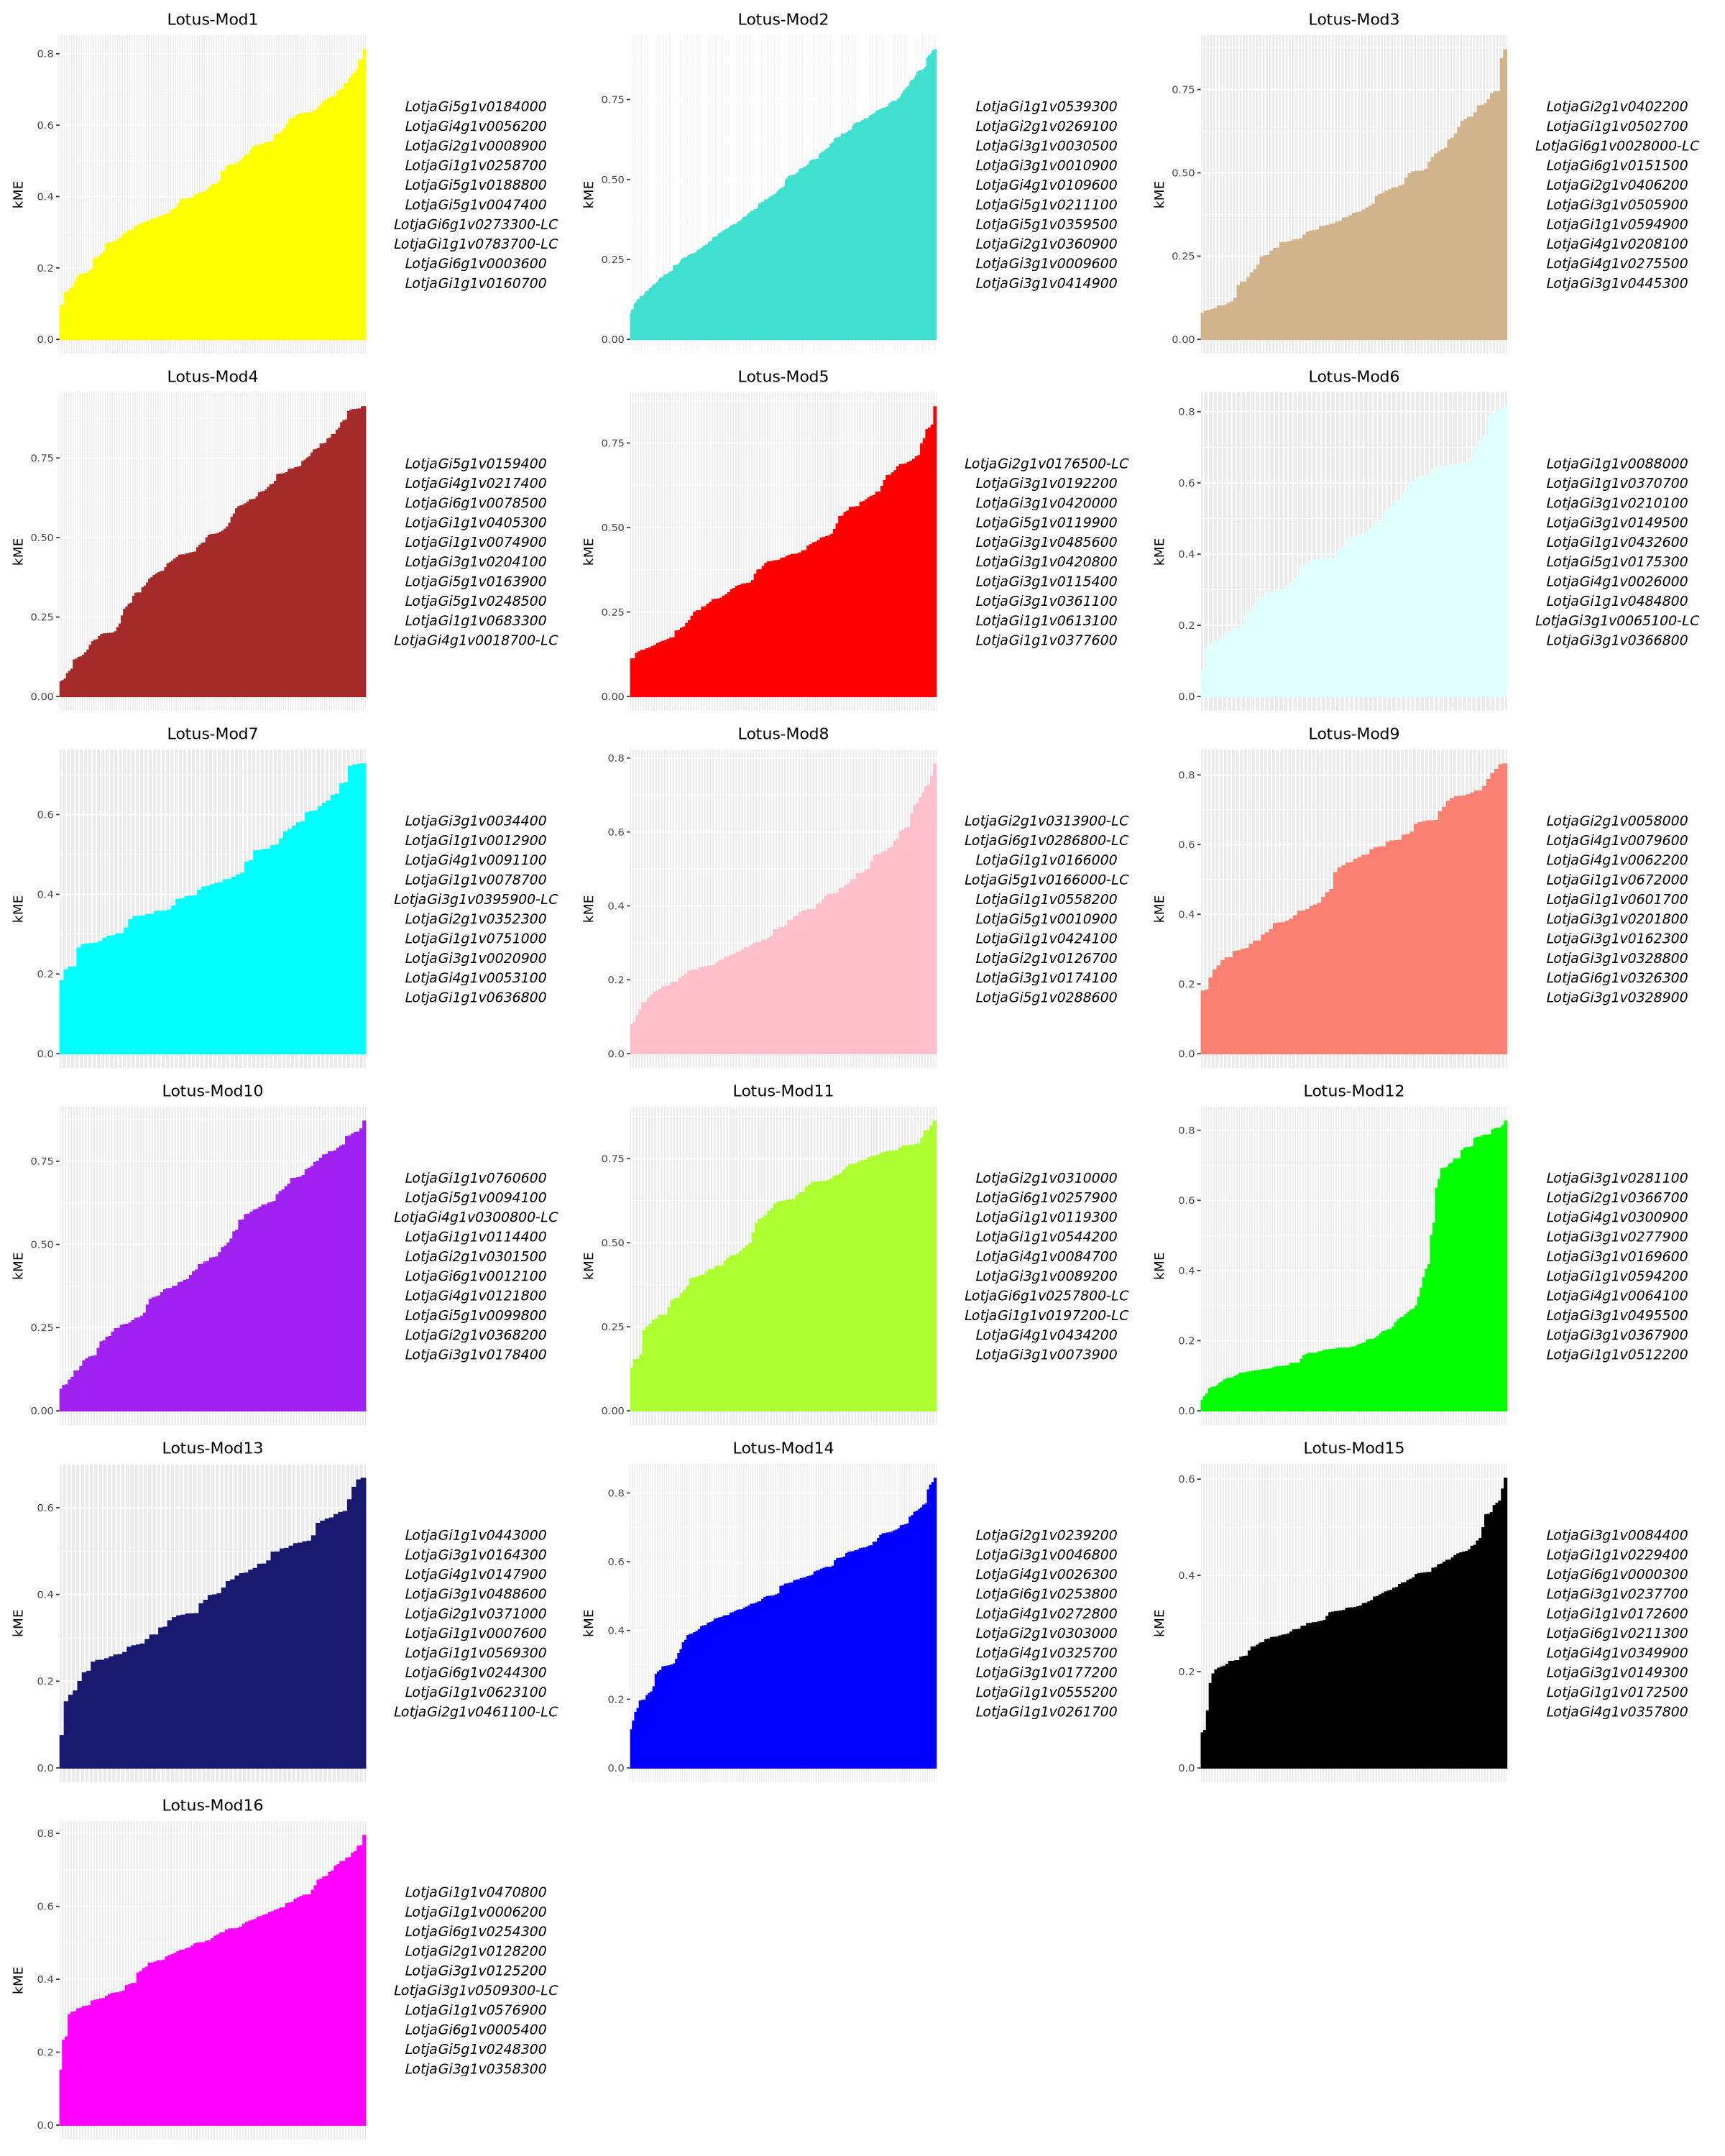

In [161]:
#| label: fig-kme
#| fig-cap: "KMEs for each module, where the genes on the right of each plot gives the top genes based on the module's KMEs. Each plot is a histogram which has been rotated, so that bars starting on the left side of the y axis represent the counts of how many genes have the connectivity written on the right side of the y axis. The number of counts should be written on the x axis, but is not plotted by the function."

options(repr.plot.width=20, repr.plot.height=25)
p <- capture.output({PlotKMEs(seurat.clustered, ncol=3, text_size = 4);})

### Getting the module assignment table

The plots of @fig-kme are a bit hard to read, though fancy to plot. `hdWGCNA` allows for easy access of the module assignment table using the `GetModules` function. This table consists of three columns: `gene_name` stores the gene’s symbol or ID, module stores the gene’s module assignment, and color stores a color mapping for each module (which is used in plotting steps). If `ModuleConnectivity` has been used on this hdWGCNA experiment, as it is our case, this table has additional columns with the connectivities plotted in @fig-kme

In [162]:
# get the module assignment table:
modules <- GetModules(seurat.clustered)

# show the first 6 columns:
head(modules[,1:6])

gene_name          module     color     kME_Lotus-Mod1
LotjaGi3g1v0222100 LotjaGi3g1v0222100 Lotus-Mod1 yellow     0.66927700   
LotjaGi2g1v0360900 LotjaGi2g1v0360900 Lotus-Mod2 turquoise -0.14382340   
LotjaGi3g1v0445300 LotjaGi3g1v0445300 Lotus-Mod3 tan       -0.18127709   
LotjaGi3g1v0506700 LotjaGi3g1v0506700 Lotus-Mod2 turquoise -0.13031149   
LotjaGi2g1v0160200 LotjaGi2g1v0160200 Lotus-Mod4 brown     -0.12981105   
LotjaGi5g1v0119900 LotjaGi5g1v0119900 Lotus-Mod5 red        0.02807917   
                   kME_Lotus-Mod2 kME_Lotus-Mod3
LotjaGi3g1v0222100 -0.16607049    -0.20407421   
LotjaGi2g1v0360900  0.90236572    -0.24851350   
LotjaGi3g1v0445300 -0.21469999     0.86945694   
LotjaGi3g1v0506700  0.72715888    -0.20028857   
LotjaGi2g1v0160200 -0.02298910    -0.08982969   
LotjaGi5g1v0119900 -0.09403294    -0.17121588

A table of the top N hub genes sorted by kME can be extracted using the `GetHubGenes` function. Here we choose the top 10 genes, but you can change the value if you want. The table contains all the top 10 genes for each module, the name of the module they come from and the kME score.

In [163]:
# get hub genes
hub_df <- GetHubGenes(seurat.clustered, n_hubs = 10)
# print the first lines of the table to see its structure
head( hub_df )

gene_name             module     kME      
1 LotjaGi1g1v0160700    Lotus-Mod1 0.8112420
2 LotjaGi6g1v0003600    Lotus-Mod1 0.7821258
3 LotjaGi1g1v0783700-LC Lotus-Mod1 0.7813964
4 LotjaGi6g1v0273300-LC Lotus-Mod1 0.7544668
5 LotjaGi5g1v0047400    Lotus-Mod1 0.7442475
6 LotjaGi5g1v0188800    Lotus-Mod1 0.7403723

Again, we can assign GO terms to better check associated functions

In [164]:
go_table <- read.table("../Data/LJ_GO_terms.gaf", skip=6, sep='\t', fill=TRUE, quote = "\"")

In [165]:
hub_df <- addGOterms(input_table = hub_df, 
                     go_table = go_table, 
                     gene_column = 'gene_name',
                     n.cores = 16)

Now it is easy to look at each module and relevant GO terms.

In [166]:
hub_filtered <- hub_df %>% filter(module == "Lotus-Mod3")

In [167]:
hub_filtered

gene_name             module     kME       GO       
1  LotjaGi3g1v0445300    Lotus-Mod3 0.8694569 Undefined
2  LotjaGi4g1v0275500    Lotus-Mod3 0.8430255 Undefined
3  LotjaGi4g1v0208100    Lotus-Mod3 0.7431116 Undefined
4  LotjaGi1g1v0594900    Lotus-Mod3 0.7429926 Undefined
5  LotjaGi3g1v0505900    Lotus-Mod3 0.7373019 Undefined
6  LotjaGi2g1v0406200    Lotus-Mod3 0.7185567 Undefined
7  LotjaGi6g1v0151500    Lotus-Mod3 0.7072212 Undefined
8  LotjaGi6g1v0028000-LC Lotus-Mod3 0.7023895 Undefined
9  LotjaGi1g1v0502700    Lotus-Mod3 0.7008408 Undefined
10 LotjaGi2g1v0402200    Lotus-Mod3 0.6794909 Undefined

We save the table for later use

In [168]:
write.csv(hub_df, "top_genes_networks.csv")

We can also plot the modules to see where they are most relevant on the UMAP plot. First we calculate the scores of each module and renames each module from `Cluster##` to `Lotus-Mod##`. The scores are the same for the markers plots for clustering, but calculated instead on the genes of each module.

Scores renamed FROM




Cluster1
Cluster2
Cluster3
Cluster4
Cluster5
Cluster6
Cluster7
Cluster8
Cluster9
Cluster10
Cluster11
Cluster12
Cluster13
Cluster14
Cluster15
Cluster16




TO




Lotus-Mod1
Lotus-Mod2
Lotus-Mod3
Lotus-Mod4
Lotus-Mod5
Lotus-Mod6
Lotus-Mod7
Lotus-Mod8
Lotus-Mod9
Lotus-Mod10
Lotus-Mod11
Lotus-Mod12
Lotus-Mod13
Lotus-Mod14
Lotus-Mod15
Lotus-Mod16


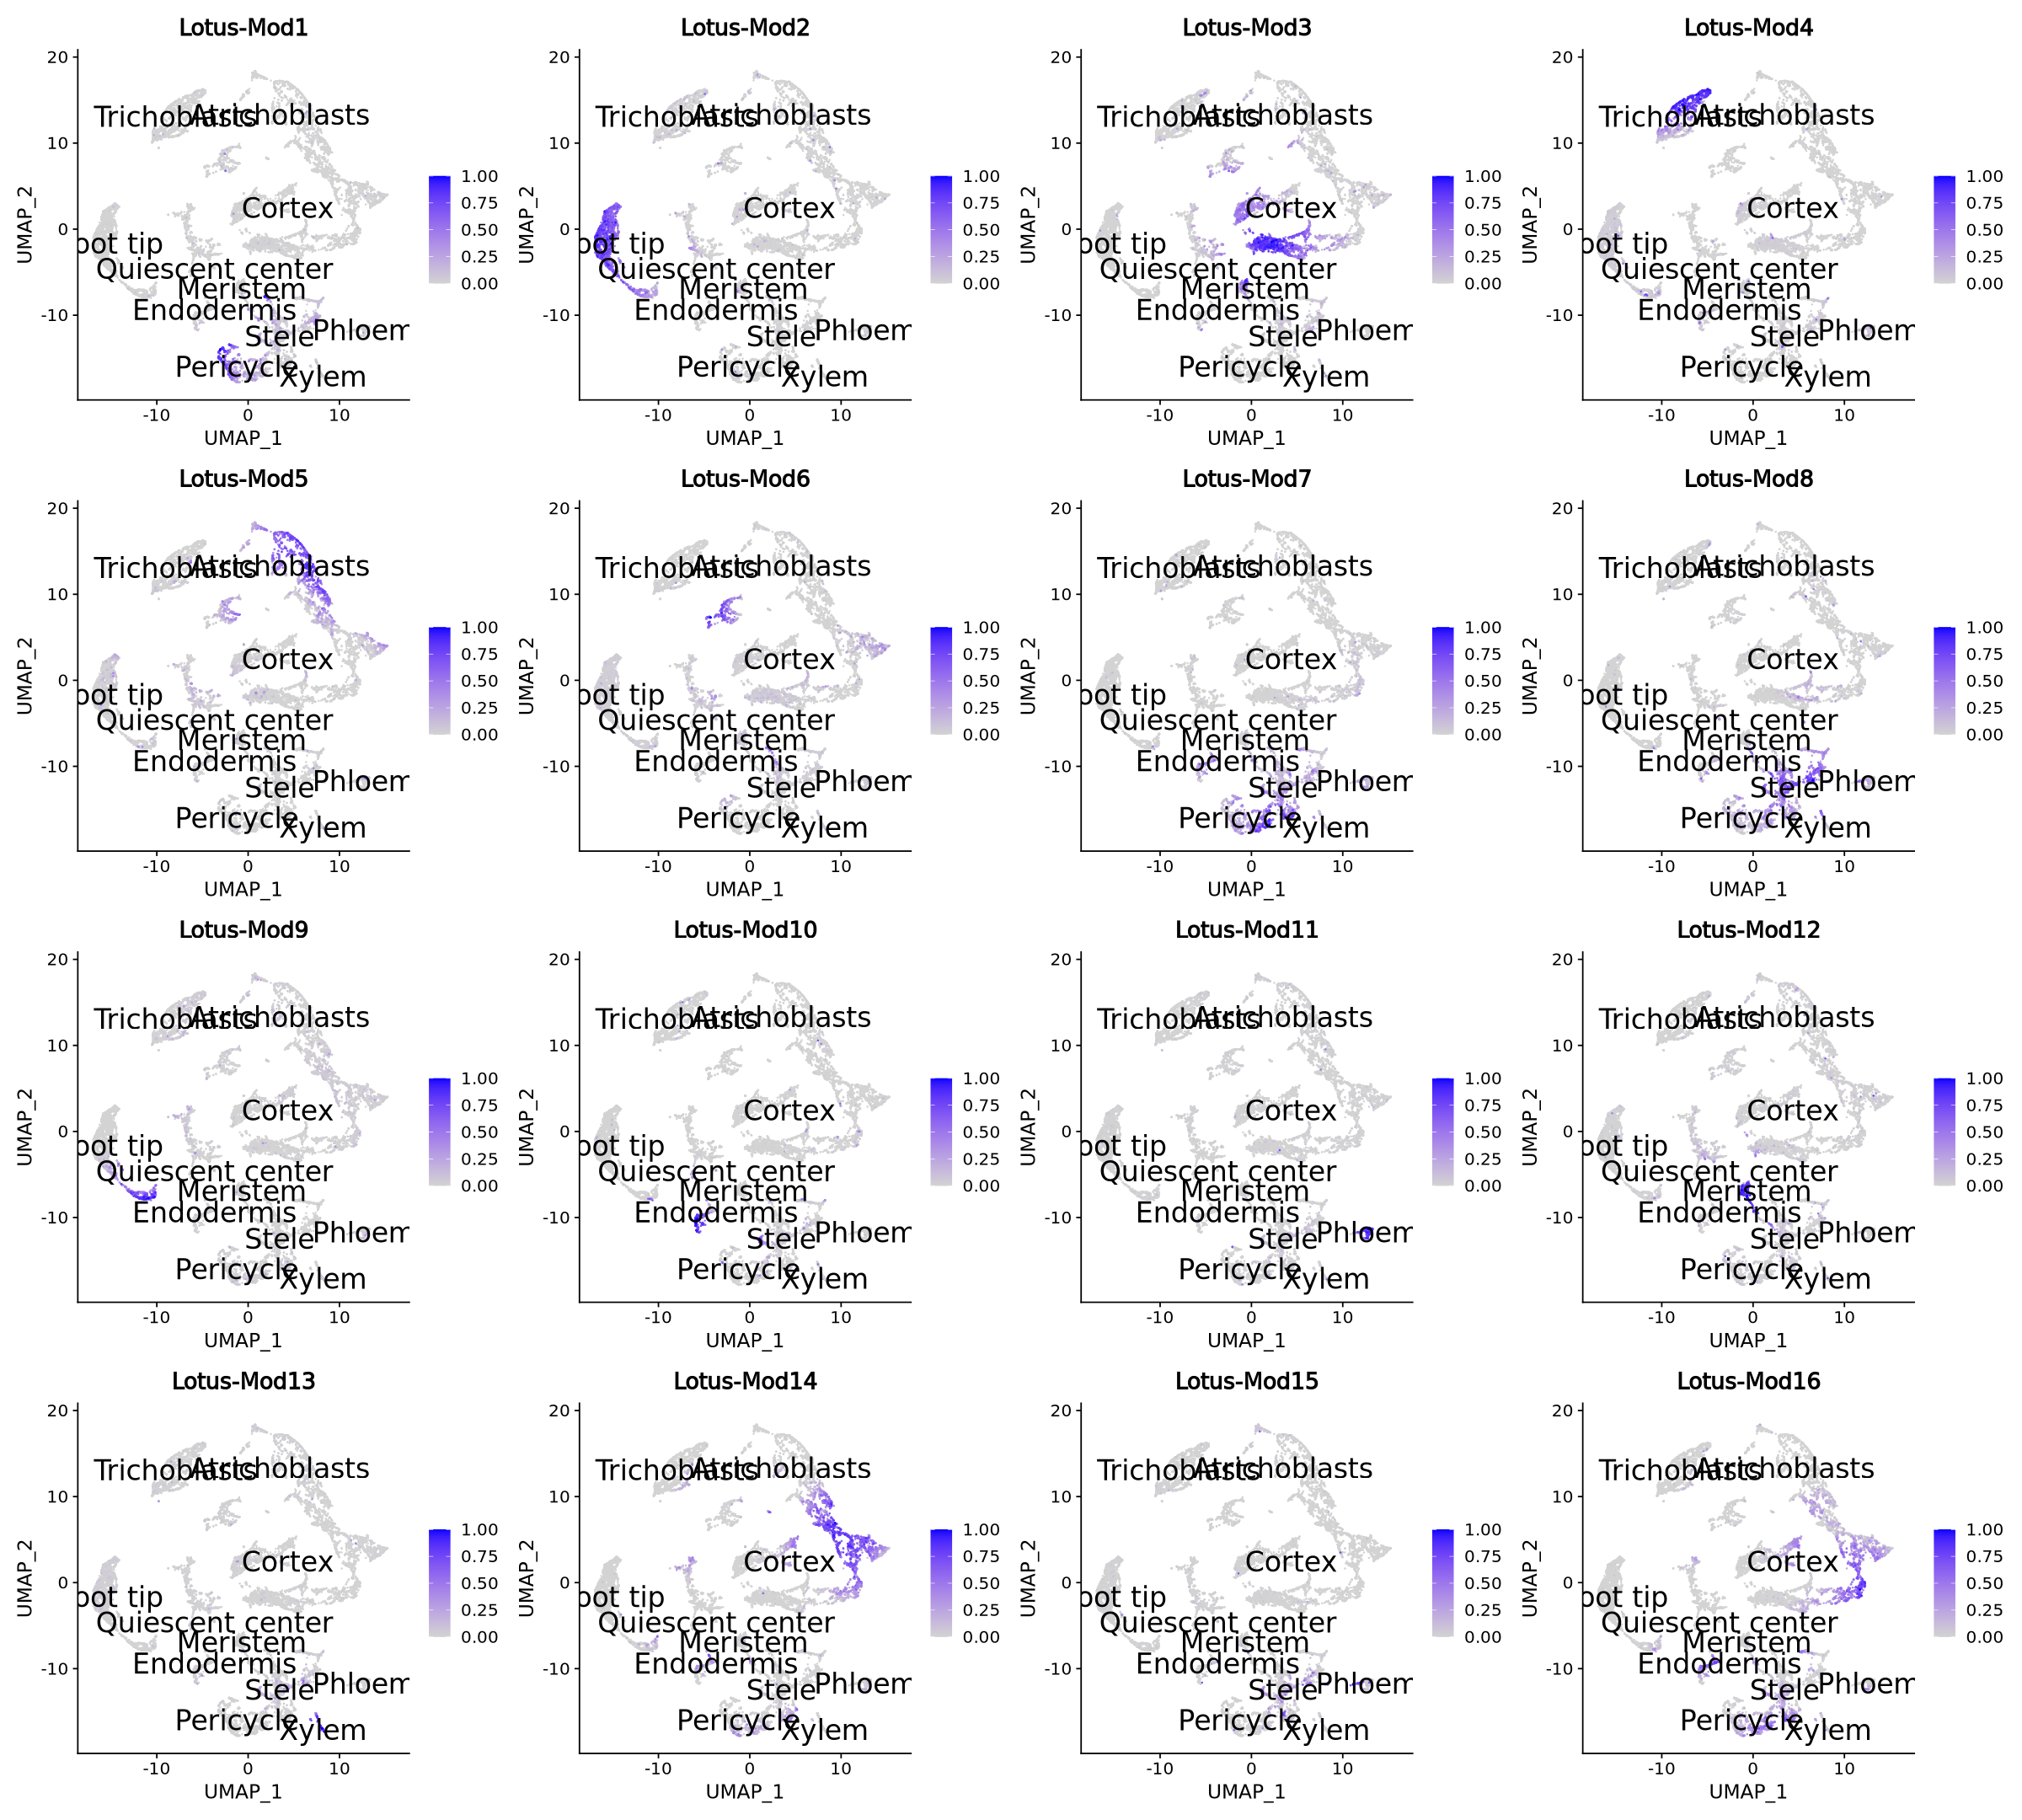

In [169]:
features_list <- list()

for(MOD in hub_df$module){
    genes <- hub_df %>% filter(module == MOD)
    genes_mod <- genes$gene_name
    features_list[[MOD]] <- genes_mod
    }

seurat.clustered <- AddModuleScore(
  object = seurat.clustered,
  features = features_list,
  ctrl = 5,
)

seurat.clustered <- renameScores(markers_list = features_list, seurat_data = seurat.clustered)
plotScoresUMAP(markers_list = features_list, seurat_data = seurat.clustered)


:::{.callout-tip}
Plots can be hard to see when they are small. You can plot any module singularly. For example Mod1. You simply need to choose one of the elements from `feature_list` (below we chose `feature_list[1]` for `Lotus-Mod1`)
:::

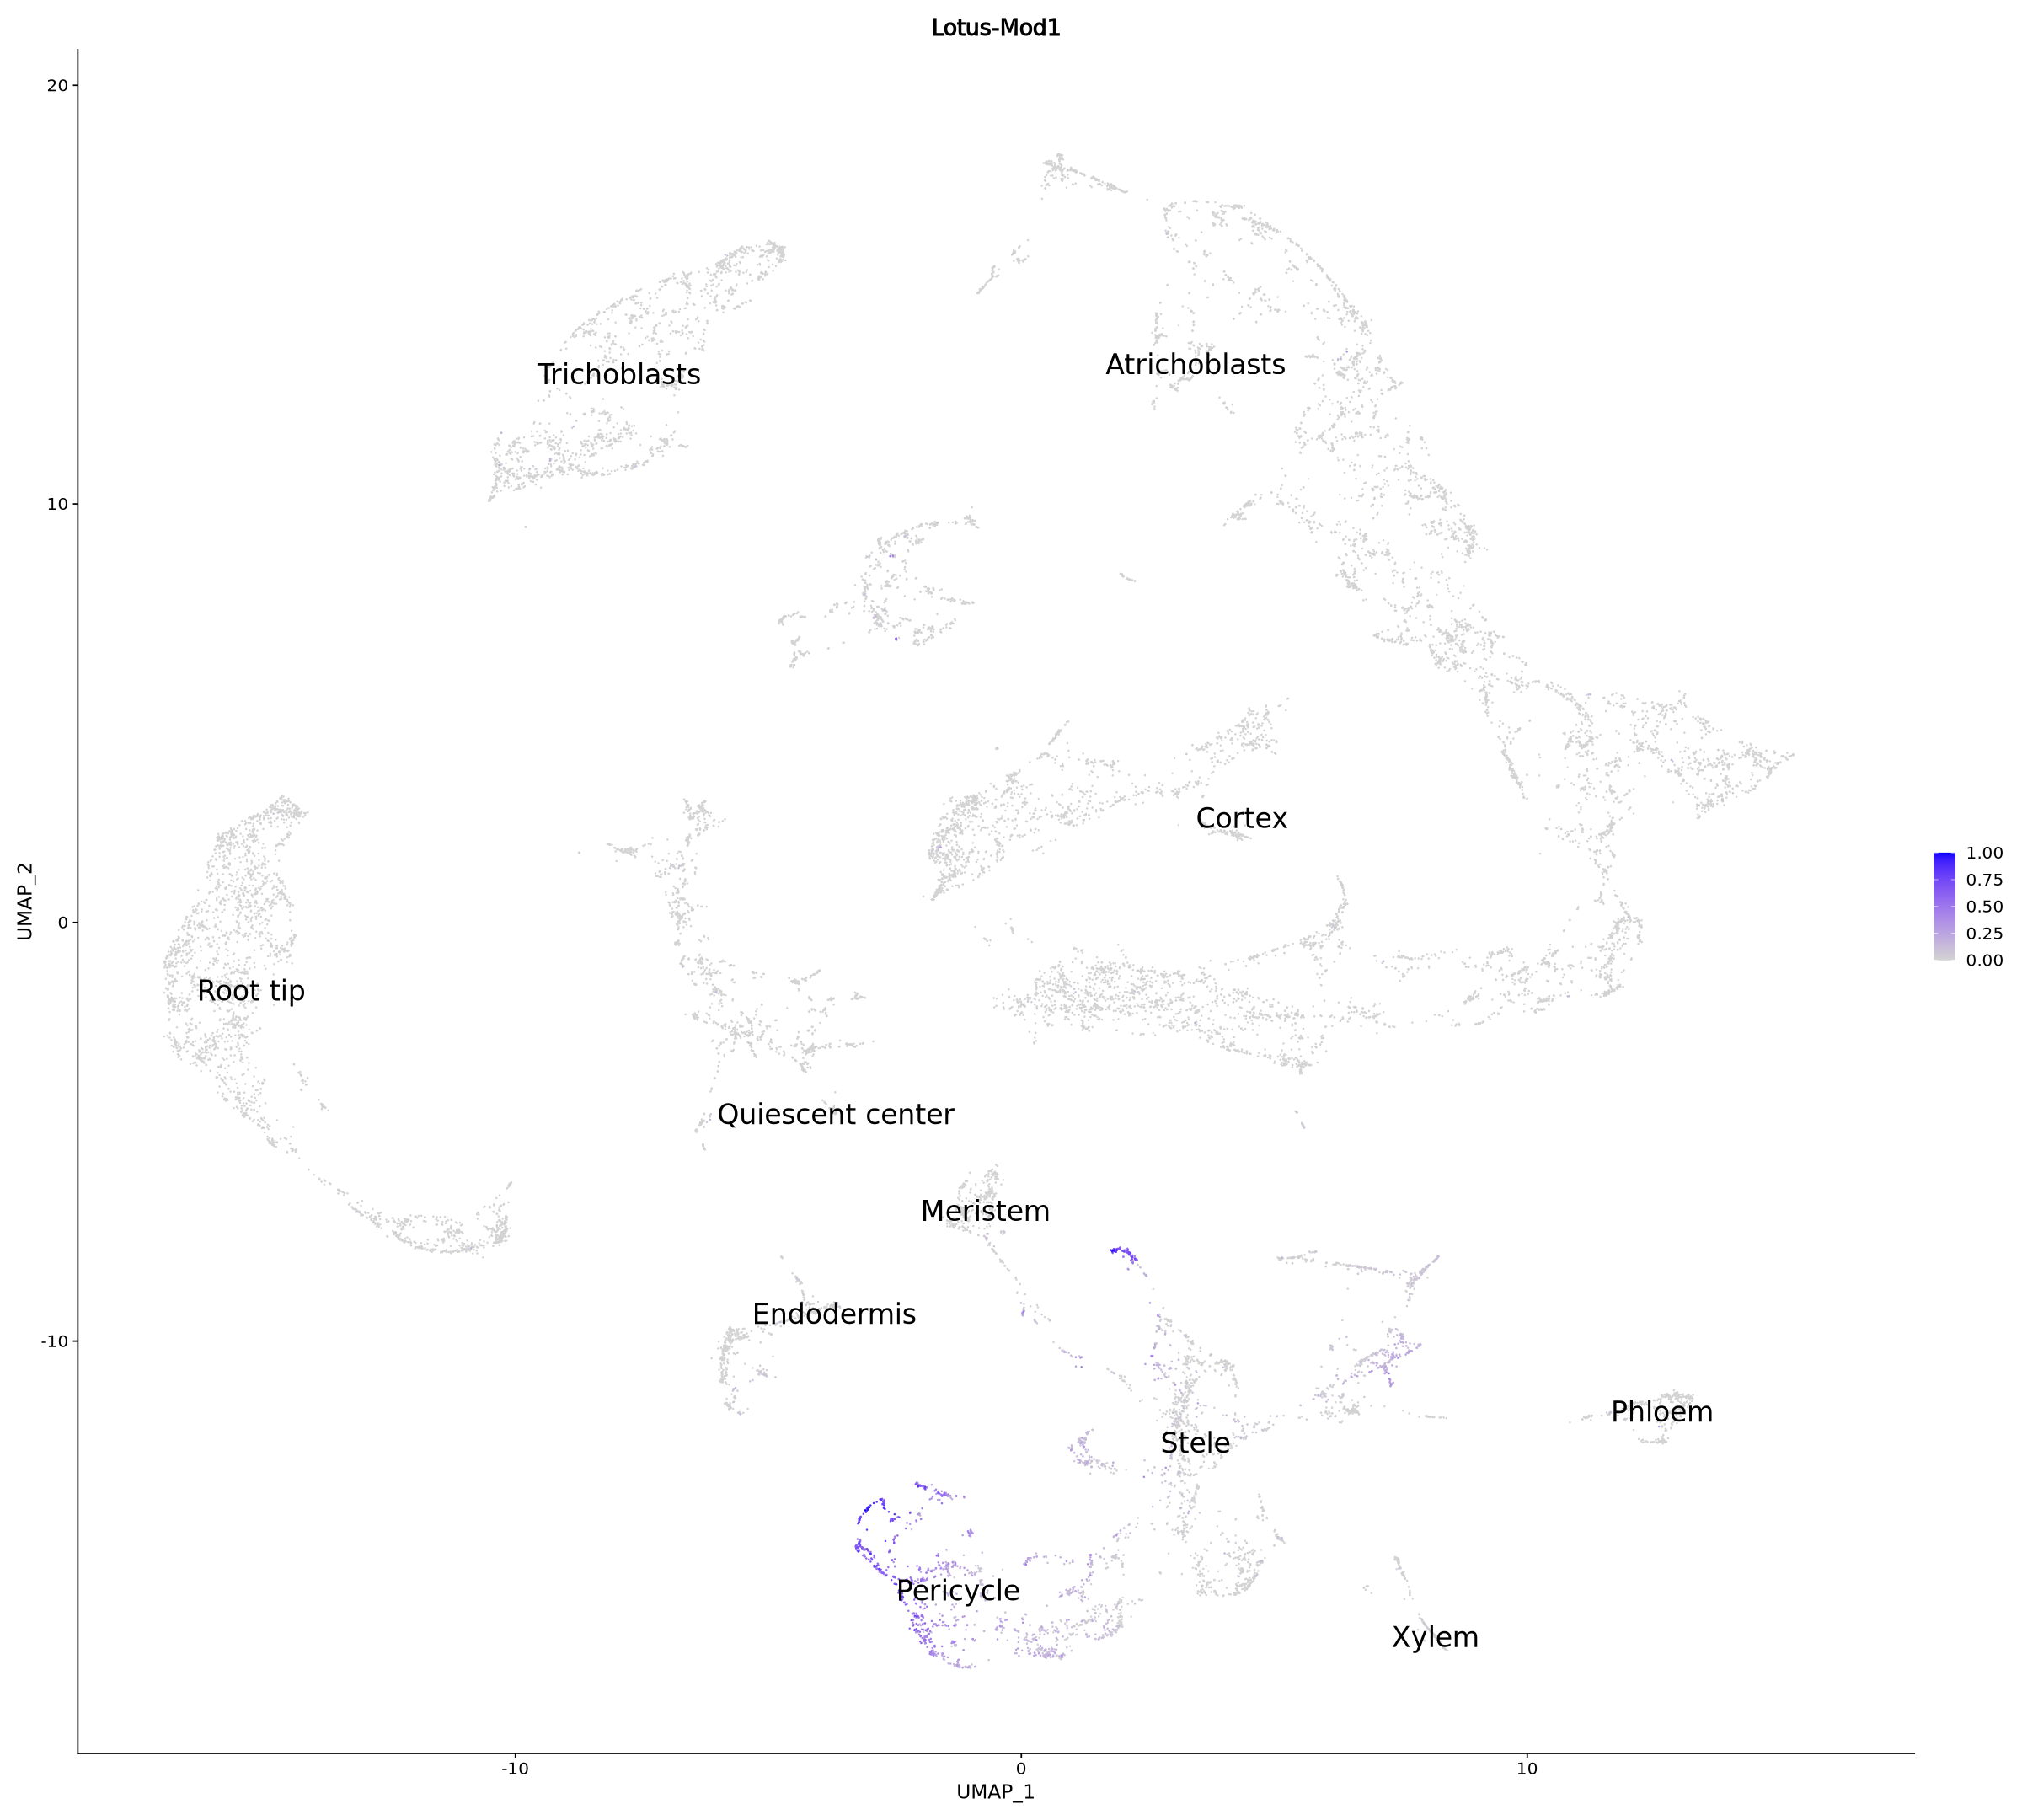

In [170]:
plotScoresUMAP(markers_list = features_list[1], seurat_data = seurat.clustered)

We save the seurat object and the network separately (because for some inscrutable error, `hdWGCNA` cannot load together with the Seurat object when it is needed again).

In [171]:
SaveH5Seurat(seurat.clustered, 'seurat.network.h5Seurat', overwrite = TRUE, verbose=FALSE)

Warning message:
“Overwriting previous file seurat.network.h5Seurat”
Creating h5Seurat file for version 3.1.5.9900



In [172]:
saveRDS(seurat.clustered@misc, "network_lotus.RDS")

## Differential module Expression (DME) analysis

Lastly, we can see which modules are most expressed in a specific cluster against the others, in a similar way to differential gene expression.

In [173]:
seurat.network <- LoadH5Seurat('seurat.network.h5Seurat', misc=FALSE, verbose=FALSE)

Validating h5Seurat file

Warning message:
“Adding a command log without an assay associated with it”


[1] "Couldn't delete        144115188075857558"


In [174]:
seurat.network@misc <- readRDS("network_lotus.RDS")

Here we discuss how to perform **DME testing between two different groups**. We use the `hdWGCNA` function `FindDMEs`, which is similar to the Seurat function FindMarkers. We use the Mann-Whitney U test, also known as the Wilcoxon test, to compare two groups, but other tests can be used at the user’s discretion with the `test.use` parameter.

We are interested in defining our two groups both by condition. We filter DMEs by p-value and fold-change, so to remove non-significant ones from the list.

In [175]:
R7Agroup <- seurat.network@meta.data %>% subset(Condition == 'R7A') %>% rownames
WTgroup <- seurat.network@meta.data %>% subset(Condition == 'Control') %>% rownames

In [176]:
DMEs <- FindDMEs(
  seurat.network,
  barcodes1 = R7Agroup,
  barcodes2 = WTgroup,
  test.use='wilcox',
  wgcna_name='tutorial'
) %>% filter(p_val_adj < 0.001 & abs(avg_log2FC)>1) %>% select(-p_val)


The resulting table below is very similar to the one for differential gene expression. Now the p-values and fold changes are referred to the differential module expression in the inoculated VS the control cells. We can see there are some differences and one could study those modules in depth by looking at the top genes and their GO terms.

In [177]:
DMEs

avg_log2FC pct.1 pct.2 p_val_adj    module     
Lotus-Mod2  -1.078807  0.130 0.239 5.577347e-93 Lotus-Mod2 
Lotus-Mod6   1.120521  0.276 0.193 8.258406e-49 Lotus-Mod6 
Lotus-Mod15  2.009786  0.215 0.165 5.693663e-27 Lotus-Mod15

Graphically, you can always produce a lollipop plot as in @fig-lol, where the size of each circle is the p-value, and the x-axis is the log-fold change. A cross on a circle means the p-value is not significant. In our case we filtered out p-values that were too high, so we have only significant modules in the plot.

Loading required package: ggforestplot



[1] "Please be aware comparison group/groups are not provided, which may casue an ERROR. PlotDMEsLollipop function will automatically assume all values are within the same group."


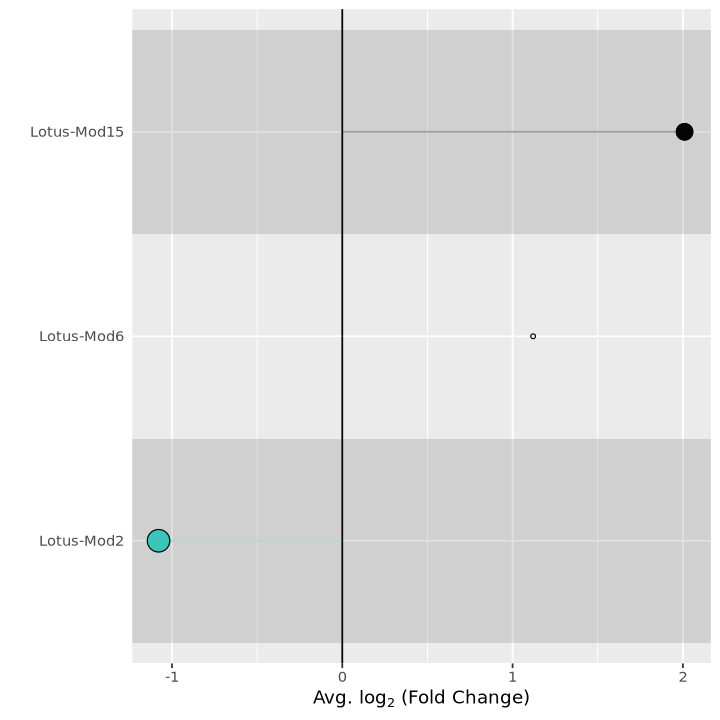

In [178]:
#| label: fig-lol
#| fig-cap: "Lollipop plot that shovs the average log-fold change of each module and the p-value (size of each circle). Crossed circles, when present, have a non-significant p-value"

options(repr.plot.width=6, repr.plot.height=6)

PlotDMEsLollipop(
  seurat.network, 
  DMEs, 
  wgcna_name='tutorial', 
  pvalue = "p_val_adj",
)

### One-versus-all DME analysis

This is another case of DME analysis, where each cluster is tested against the rest of the data to see which modules are differentially expressed and are specific of each cell type. We can test by cell type (`predicted.id`) or by condition (`Condition`), or by any other label a dataset might have and that is contained in the meta data.

In [179]:
DMEs_all <- FindAllDMEs(
  seurat.network,
  group.by = 'predicted.id',
  wgcna_name = 'tutorial'
) 

[1] "Cortex"
[1] "Trichoblasts"
[1] "Root tip"
[1] "Meristem"
[1] "Phloem"
[1] "Pericycle"
[1] "Stele"
[1] "Atrichoblasts"
[1] "Xylem"
[1] "Endodermis"
[1] "Quiescent center"


The table is usually big, but you can choose to filter by various parameters as below, and to look only at one cluster of interest

In [180]:
DMEs_cortex <- DMEs_all %>% filter(p_val_adj < .001 & abs(avg_log2FC)>1 
                                       & is.finite(avg_log2FC)
                                       & group=='Cortex')

The DME analysis results in a lot of significant results for the cortex. The most significant modules for a cluster are the ones where `pct.1` and `pct.2` are very different, and at the same time have a large fold-change and a small p-value. The column `group` tells you in which cluster the module is differentially overexpressed (positive fold-change `avg_log2FC`) or underexpressed (negative fold-change).

In [181]:
DMEs_cortex

p_val         avg_log2FC pct.1 pct.2 p_val_adj    
Cortex.Lotus-Mod3   0.000000e+00  2.371340  0.480 0.152  0.000000e+00
Cortex.Lotus-Mod6   0.000000e+00  2.666149  0.408 0.125  0.000000e+00
Cortex.Lotus-Mod14  0.000000e+00  2.453980  0.523 0.225  0.000000e+00
Cortex.Lotus-Mod1   0.000000e+00 -4.708455  0.061 0.277  0.000000e+00
Cortex.Lotus-Mod7   0.000000e+00 -4.395113  0.082 0.370  0.000000e+00
Cortex.Lotus-Mod11  0.000000e+00 -4.699137  0.034 0.296  0.000000e+00
Cortex.Lotus-Mod8   0.000000e+00 -3.563797  0.108 0.368  0.000000e+00
Cortex.Lotus-Mod15  0.000000e+00 -2.962244  0.071 0.289  0.000000e+00
Cortex.Lotus-Mod2   0.000000e+00 -5.524643  0.033 0.273  0.000000e+00
Cortex.Lotus-Mod4  1.859292e-188 -3.855152  0.070 0.211 2.974867e-187
Cortex.Lotus-Mod13 3.339974e-141 -3.844141  0.073 0.194 5.343958e-140
Cortex.Lotus-Mod9   2.981487e-99 -2.893193  0.147 0.254  4.770380e-98
Cortex.Lotus-Mod10  3.126878e-65 -3.120111  0.108 0.188  5.003005e-64
Cortex.Lotus-Mod12  1.669763e-07 -1.290486  0.185 0.215  2.671620e-06
                   module      group 
Cortex.Lotus-Mod3  Lotus-Mod3  Cortex
Cortex.Lotus-Mod6  Lotus-Mod6  Cortex
Cortex.Lotus-Mod14 Lotus-Mod14 Cortex
Cortex.Lotus-Mod1  Lotus-Mod1  Cortex
Cortex.Lotus-Mod7  Lotus-Mod7  Cortex
Cortex.Lotus-Mod11 Lotus-Mod11 Cortex
Cortex.Lotus-Mod8  Lotus-Mod8  Cortex
Cortex.Lotus-Mod15 Lotus-Mod15 Cortex
Cortex.Lotus-Mod2  Lotus-Mod2  Cortex
Cortex.Lotus-Mod4  Lotus-Mod4  Cortex
Cortex.Lotus-Mod13 Lotus-Mod13 Cortex
Cortex.Lotus-Mod9  Lotus-Mod9  Cortex
Cortex.Lotus-Mod10 Lotus-Mod10 Cortex
Cortex.Lotus-Mod12 Lotus-Mod12 Cortex

You can look at any other cluster. For example trichoblasts. Here you can see how module 4 pops up as being basically entirely expressed only in Trichoblasts.

In [182]:
DMEs_tricho <- DMEs_all %>% filter(p_val_adj < .001 & abs(avg_log2FC)>1 
                                       & is.finite(avg_log2FC)
                                       & group=='Trichoblasts')

In [183]:
DMEs_tricho

p_val         avg_log2FC pct.1 pct.2 p_val_adj    
Trichoblasts.Lotus-Mod4   0.000000e+00  6.750784  0.996 0.076  0.000000e+00
Trichoblasts.Lotus-Mod16 5.097196e-185 -6.481375  0.014 0.371 8.155514e-184
Trichoblasts.Lotus-Mod14 3.025439e-146 -4.349619  0.069 0.376 4.840702e-145
Trichoblasts.Lotus-Mod8  1.126480e-121 -4.872991  0.014 0.279 1.802368e-120
Trichoblasts.Lotus-Mod7  6.713357e-119 -6.178666  0.012 0.269 1.074137e-117
Trichoblasts.Lotus-Mod6  1.863436e-115 -5.773750  0.013 0.266 2.981498e-114
Trichoblasts.Lotus-Mod5   2.017255e-92 -3.586865  0.072 0.299  3.227608e-91
Trichoblasts.Lotus-Mod1   7.273801e-83 -6.444630  0.010 0.201  1.163808e-81
Trichoblasts.Lotus-Mod11  3.116022e-75 -5.254196  0.018 0.199  4.985635e-74
Trichoblasts.Lotus-Mod3   7.598832e-73 -3.568617  0.117 0.306  1.215813e-71
Trichoblasts.Lotus-Mod12  8.732984e-73 -3.106583  0.033 0.217  1.397277e-71
Trichoblasts.Lotus-Mod15  3.656164e-65 -3.844803  0.039 0.210  5.849862e-64
Trichoblasts.Lotus-Mod9   5.426530e-44 -3.051174  0.081 0.220  8.682448e-43
Trichoblasts.Lotus-Mod10  1.031038e-29 -3.738713  0.061 0.162  1.649662e-28
Trichoblasts.Lotus-Mod13  4.773544e-17 -2.852839  0.075 0.149  7.637670e-16
                         module      group       
Trichoblasts.Lotus-Mod4  Lotus-Mod4  Trichoblasts
Trichoblasts.Lotus-Mod16 Lotus-Mod16 Trichoblasts
Trichoblasts.Lotus-Mod14 Lotus-Mod14 Trichoblasts
Trichoblasts.Lotus-Mod8  Lotus-Mod8  Trichoblasts
Trichoblasts.Lotus-Mod7  Lotus-Mod7  Trichoblasts
Trichoblasts.Lotus-Mod6  Lotus-Mod6  Trichoblasts
Trichoblasts.Lotus-Mod5  Lotus-Mod5  Trichoblasts
Trichoblasts.Lotus-Mod1  Lotus-Mod1  Trichoblasts
Trichoblasts.Lotus-Mod11 Lotus-Mod11 Trichoblasts
Trichoblasts.Lotus-Mod3  Lotus-Mod3  Trichoblasts
Trichoblasts.Lotus-Mod12 Lotus-Mod12 Trichoblasts
Trichoblasts.Lotus-Mod15 Lotus-Mod15 Trichoblasts
Trichoblasts.Lotus-Mod9  Lotus-Mod9  Trichoblasts
Trichoblasts.Lotus-Mod10 Lotus-Mod10 Trichoblasts
Trichoblasts.Lotus-Mod13 Lotus-Mod13 Trichoblasts

For better visualization, you can always use the lolliplot plots using the correct table as an argument, so that you can plot multiple instances for the various clusters. In @fig-lol2 we plot boyh for cortex and trichoblasts from the tables determined in the code above.

[1] "Please be aware comparison group/groups are not provided, which may casue an ERROR. PlotDMEsLollipop function will automatically assume all values are within the same group."
[1] "Please be aware comparison group/groups are not provided, which may casue an ERROR. PlotDMEsLollipop function will automatically assume all values are within the same group."


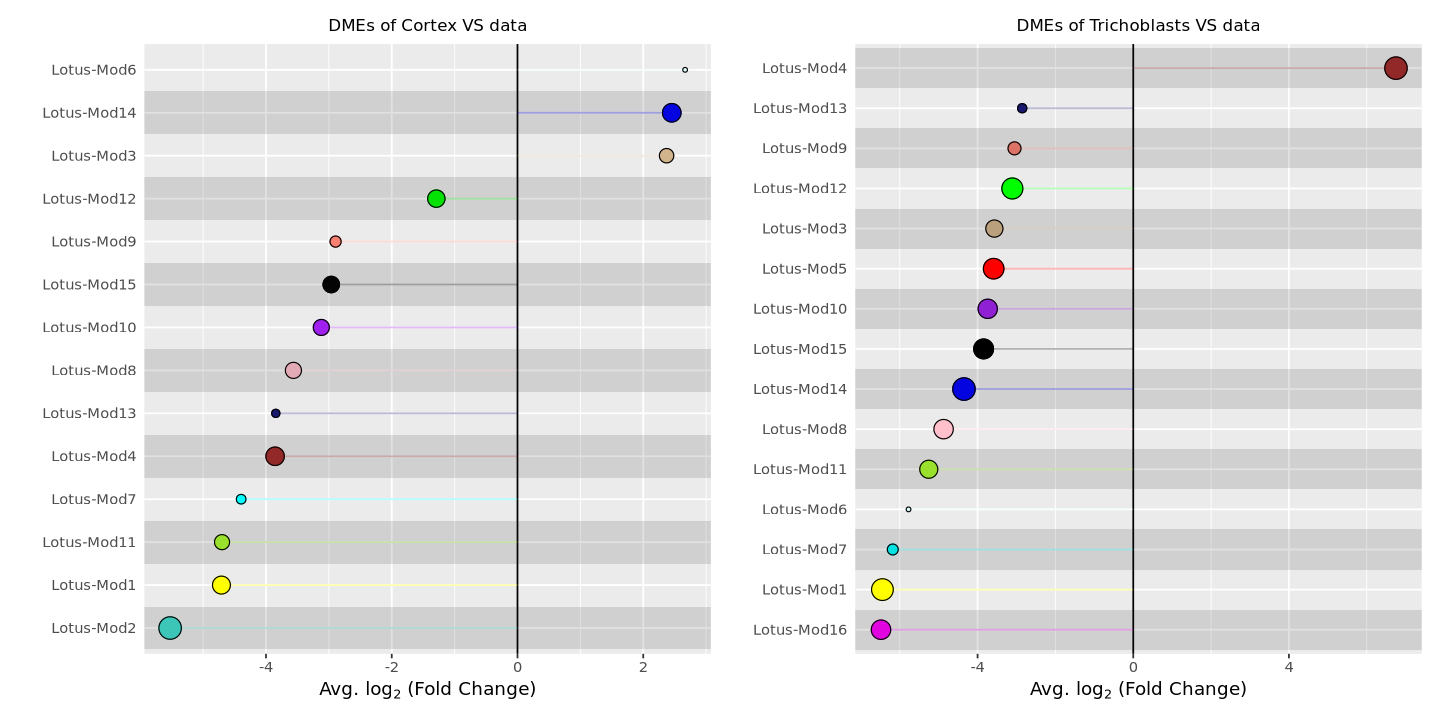

In [184]:
#| label: fig-lol2
#| fig-cap: "Lollipop plot that shovs the average log-fold change of each module and the p-value (size of each circle). Crossed circles, when present, have a non-significant p-value. Plotting lolliplot plots for various clusters can be useful to detect modules being simultaneously significant."

options(repr.plot.width=12, repr.plot.height=6)

#lollipop with cortex table
p1 <- PlotDMEsLollipop(
  seurat.network, 
  DMEs_cortex, 
  wgcna_name='tutorial', 
  pvalue = "p_val_adj",
)

#lollipop with trichoblasts table
p2 <- PlotDMEsLollipop(
  seurat.network, 
  DMEs_tricho, 
  wgcna_name='tutorial', 
  pvalue = "p_val_adj",
)

#plot an add a title
p1 + ggtitle("DMEs of Cortex VS data") + 
p2 + ggtitle("DMEs of Trichoblasts VS data")

:::{.callout-note title="Wrapping Up"}

This is the end of the tutorial. We have not shown much biological conclusion from the analysis - this is something that comes out by studying for example the GO terms of the various genes and modules identified. The scope of the tutorial was mainly to give all the means to perform your own analysis, from which you can then gain biological insight.

If you are interested in more resources to learn single cell analysis, you can find them at some of our courses. We have other single-cell analysis tutorials including different tools at

- **Introduction to NGS data analysis** (found in the `Genomics Sandbox` **[at this link](https://cloud.sdu.dk/app/jobs/create?app=genomics&version=2023.03.01)** - note that this is in the `python` language )
- **Introduction to scRNAseq analysis in R** (found in the `Transcriptomics Sandbox` **[at this link](https://cloud.sdu.dk/app/jobs/create?app=transcriptomics&version=2023.11)** )

You can also find a lot of material in the **[`Seurat` webpage](https://satijalab.org/seurat/articles/get_started.html)**. If you create a new notebook in this environment, you are likely to have all the packages needed to try the `Seurat` tutorials.

:::